# Code Description

Code Steps:

1. Load clusterings to compare (at least two)

2. Cluster Tracking - These functions take care of measuring how the clusters change over time.  This is done by comparing the intersection of each cluster from the first clustering to the second.  This number is weighted with respect to the size of the cluster in the second clustering. This is used to build a directed graph (a matrix) that measures how each cluster in the first cluster time compares the each cluster in the second. 

        a. create_locs - Finds the (x,y) location of the class and returns a dictionary with classes and locations.  Use clusters without nan.

        b. count_intersection - Given two arrays of coordinate points, count the intersection between them

        c. edge_weight - Given two classes from time 1 and time 2, compute the edge weight

        d. cluster_tracking - Given the dicts of class/locations, compute the cluster tracking matrix

        e. re_index_graph - Given a cluster tracking graph E, sort the clusters in the first time according to their relation to clusters in the second time

        f. re_ind_plot - On the lat/lon plot, reindex the first clustering with respect to the second


In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask.array as da
import time
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import math
import pywt
import scipy
from scipy import ndimage
from sklearn.metrics import silhouette_score, calinski_harabaz_score
import matplotlib.colors as color

In [2]:
import random

In [3]:
#Change viewing options
from IPython.core.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

In [4]:
#from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
#client

In [5]:
#Bring in the whole dataset
start = time.time()
ds = xr.open_mfdataset('/Users/ddesantis/Downloads/livneh_NAmerExt_15Oct2014.*.mon.nc', autoclose=True)
end = time.time()
print(end - start)

11.372095108


In [6]:
#Grab data for graphing
lat_space = np.linspace(start = np.min(ds.lat.data), stop = np.max(ds.lat.data), num = 7)
lat_space = np.round(lat_space, decimals = 1)
lon_space = np.linspace(start = np.min(ds.lon.data), stop = np.max(ds.lon.data), num = 7)
lon_space = np.round(lon_space, decimals = 1)

## Load data and count number of clusterings

In [7]:
nan_mask_slice = np.load('nan_mask_slice.npy')

In [1258]:
label_sets = np.load('label_sets_0_1_240.npy')

In [1260]:
#Collect keys from the label_sets:
label_set_keys = label_sets[()].keys()

num_clusterings = max(label_set_keys)+1

In [1261]:
num_clusterings

42

# Cluster Tracking

In [13]:
def create_locs(classes):
    '''
    Finds the (x,y) location of the class and returns a dictionary with classes and locations.  Use clusters without nan.
    
    Inputs:
    classes = final combined clustering from MR_Cluster_K
    
    Outputs:
    t_loc = a dictionary with keys equal to cluster numbers, and values equal to array of data points associted with cluster value
    '''
    
    #Find locs
    t_loc = {}
    for i in np.unique(classes):
        t_loc[i] = np.argwhere(classes==i)
        
    return t_loc

In [14]:
def count_intersection(class1,class2):
    """
    Given two arrays of coordinate points, count the intersection between them
    
    Inputs:
    class1 = the array of points corresponding to a cluster class at first time (value associated to a key from create_locs)
    class2 = the array of points corresponding to a cluster class at second time (value associated to a key from create_locs)
    
    Outputs:
    counter = the number of points that intersect between the two arrays
    """
    
    counter = 0
    for i in range(class1.shape[0]):
        if np.any((class2==class1[i]).all(1)):
            counter+=1
            
    return counter

In [15]:
def edge_weight(class1, class2):
    """
    Given two classes from time 1 and time 2, compute the edge weight
    
    Inputs:
    class1 = the array of points corresponding to a cluster class at first time (value associated to a key from create_locs)
    class2 = the array of points corresponding to a cluster class at second time (value associated to a key from create_locs)
    
    Outputs:
    edge = the percent of class2 that is filled up by class1
    """
    
    intersect = count_intersection(class1,class2)
    edge = float(intersect)/float(class2.shape[0])
    
    return edge

In [16]:
def cluster_tracking(t1_loc,t2_loc):
    '''
    Given the dicts of class/locations, compute the cluster tracking matrix
    
    Inputs:
    t1_loc = the dictionary of locations of clusters for time 1 (output of create_locs)
    t2_loc = the dictionary of locations of clusters for time 1 (output of create_locs)
    
    Outputs:
    E = this is the cluster tracking graph.  E is a matrix that contains all the relationships between clusterings at time 1 and clusterings at time 2.  Each row corresponds to a cluster form class1, 
    each column is a cluster from class2. The value at entry (i,j) is the edge weight from cluster i at time 1 to cluster j at time 2 (output of edge_weight).
    '''
    start = time.time()
    num_class1 = len(t1_loc.keys())
    num_class2 = len(t2_loc.keys())
    
    E = np.zeros((num_class1-1,num_class2-1))
    
    for key1 in np.sort(t1_loc.keys())[1:]:  #this lists all the keys in order, skipping the nan class -1
        print("Class: " + str(key1))
        for key2 in np.sort(t2_loc.keys())[1:]:
            E[int(key1),int(key2)] = edge_weight(t1_loc[key1],t2_loc[key2])
    end=time.time()
    print("Tracking Time: " + str(end-start))
    print("")
    
    
    return E

In [63]:
def re_index_graph(E):
    """
    Given a cluster tracking graph E, sort the clusters in the first time according to their relation to clusters in the second time
    
    Inputs:
    E = cluster tracking graph
    
    Outputs:
    ind_last = the array that describes the association of clusters from time one to time two. E.g., if the 6'th entry is 8, then the cluster labeled 6 at time 1 is most correlated with cluster 8 at time 2.
    ordered_last = Sorting the matrix E according the ind_last
    """
    ind_last = np.argmax(E,axis=1)
    ordered_last = E[:,ind_last]
    
    return ind_last, ordered_last

In [65]:
def re_ind_plot(first_cluster, ind_last):
    """
    On the lat/lon plot, reindex the first clustering with respect to the second
    
    Inputs:
    first_cluster = the clustering provided by MR_Cluster_K for the first time series
    ind_last = output of re_index_graph
    
    Returns:
    final_ordered = the reindexed clustering over time 1 with respect to time 2
    """
    temp_ind = np.insert(ind_last,0,-1)
    temp_label = np.copy(first_cluster)
    save_unique = np.copy(np.unique(first_cluster))
    for i in range(np.unique(first_cluster).size):
            #replace the class i in j'th time chunk with the new labels
        temp_label[first_cluster == np.unique(save_unique[i])] = temp_ind[i] 

    final_ordered = temp_label
    
    return final_ordered

# First versus last time:

In [9]:
#Load first and last clusterings to compare
first_cluster = np.load('label_first_0_1_240.npy')
last_cluster = np.load('label_last_0_1_240.npy')

In [18]:
#Find locations of clusterings
t_loc_first = create_locs(first_cluster)
t_loc_last = create_locs(last_cluster)

In [20]:
#Compute the cluster tracking
E = cluster_tracking(t_loc_first,t_loc_last)

Class: 0.0
Class: 1.0
Class: 2.0
Class: 3.0
Class: 4.0
Class: 5.0
Class: 6.0
Class: 7.0
Class: 8.0
Class: 9.0
Class: 10.0
Class: 11.0
Class: 12.0
Class: 13.0
Class: 14.0
Class: 15.0
Class: 16.0
Class: 17.0
Class: 18.0
Class: 19.0
Class: 20.0
Class: 21.0
Class: 22.0
Class: 23.0
Tracking Time: 344.121809959



In [64]:
#Grab correlation and sorting
ind_last, ordered_last = re_index_graph(E)

Before


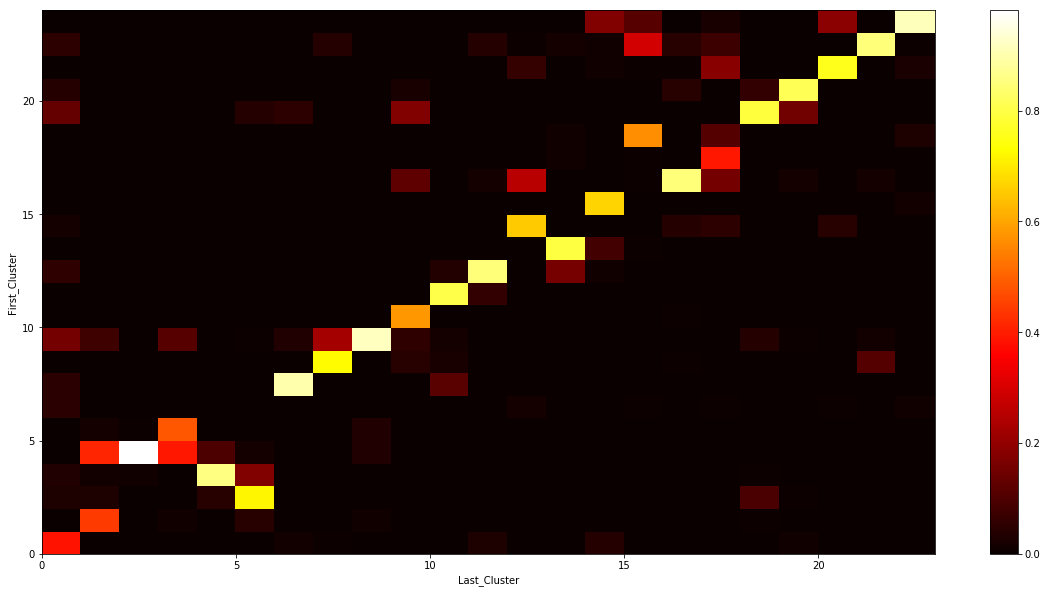

After


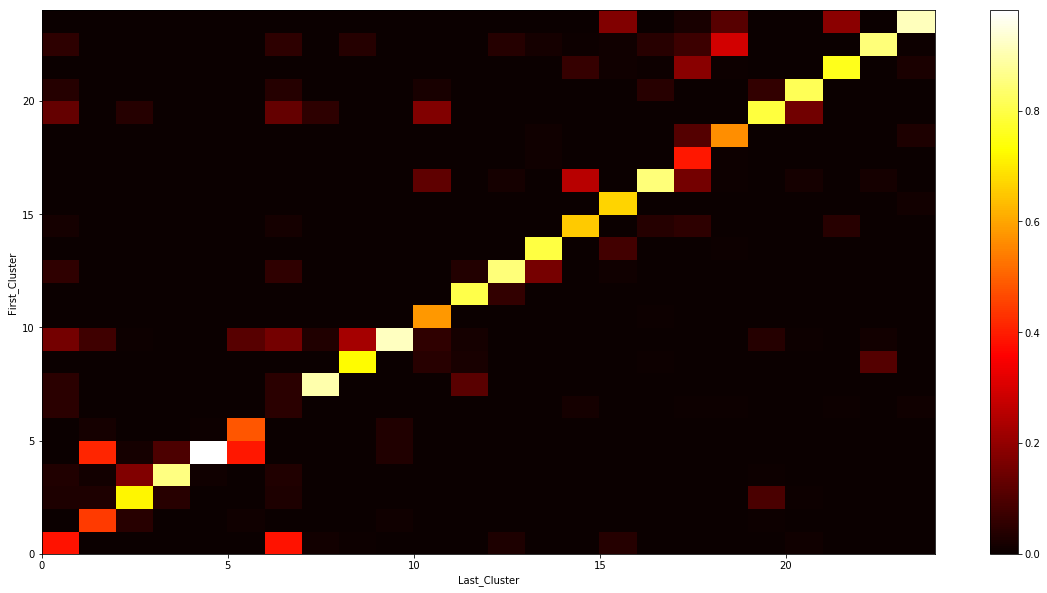

In [21]:
#Plotting the cluster tracking:
    
print("Before")
    
plt.figure(figsize=(20,10))
p0= plt.pcolormesh(E, cmap="hot")
plt.colorbar(p0)
plt.ylabel("First_Cluster")
plt.xlabel("Last_Cluster")
plt.show()
    
print("After")
    
plt.figure(figsize=(20,10))
p= plt.pcolormesh(ordered_last, cmap="hot")
plt.colorbar(p)
plt.ylabel("First_Cluster")
plt.xlabel("Last_Cluster")
plt.show()

In [67]:
#Build the re_index lat/lon clustering
final_ordered = re_ind_plot(first_cluster, ind_last)

In [68]:
#Apply a nan-mask
final_ordered = final_ordered + nan_mask_slice

In [24]:
#This cell builds a colormap to be used for plotting the combined clusterings:

#Find the largest number of colors needed
color_counter = [np.max(first_cluster), np.max(last_cluster)]
    
color_count = np.max(color_counter)

#Produce colorbar:

#Take a cube root of the largest number of colors needed to split across RBG
k = np.ceil(int(color_count)**(.3333))

#Build the numpy array of the evenly spaced colors
c_space = np.linspace(0,1,k)
l = c_space.size
colormap = np.zeros((l**3,3))

index= -1
for i in range(l):
    for j in range(l):
        for k in range(l):
            index+=1
            colormap[index] = [c_space[i],c_space[j],c_space[k]]

#This produces too many colors - in particular it includes the color of (1,1,1) reserved for the nan values.  
#Randomize to subset-take only as many as needed
color_ind = random.sample(range(l**3-1), int(color_count))
color_ind = np.array(color_ind)
colormap = colormap[color_ind,:]

/Users/ddesantis/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  


In [26]:
#For plotting, we need to add the nan_mask.
plot_sets = {0:first_cluster + nan_mask_slice, 1: last_cluster+nan_mask_slice}

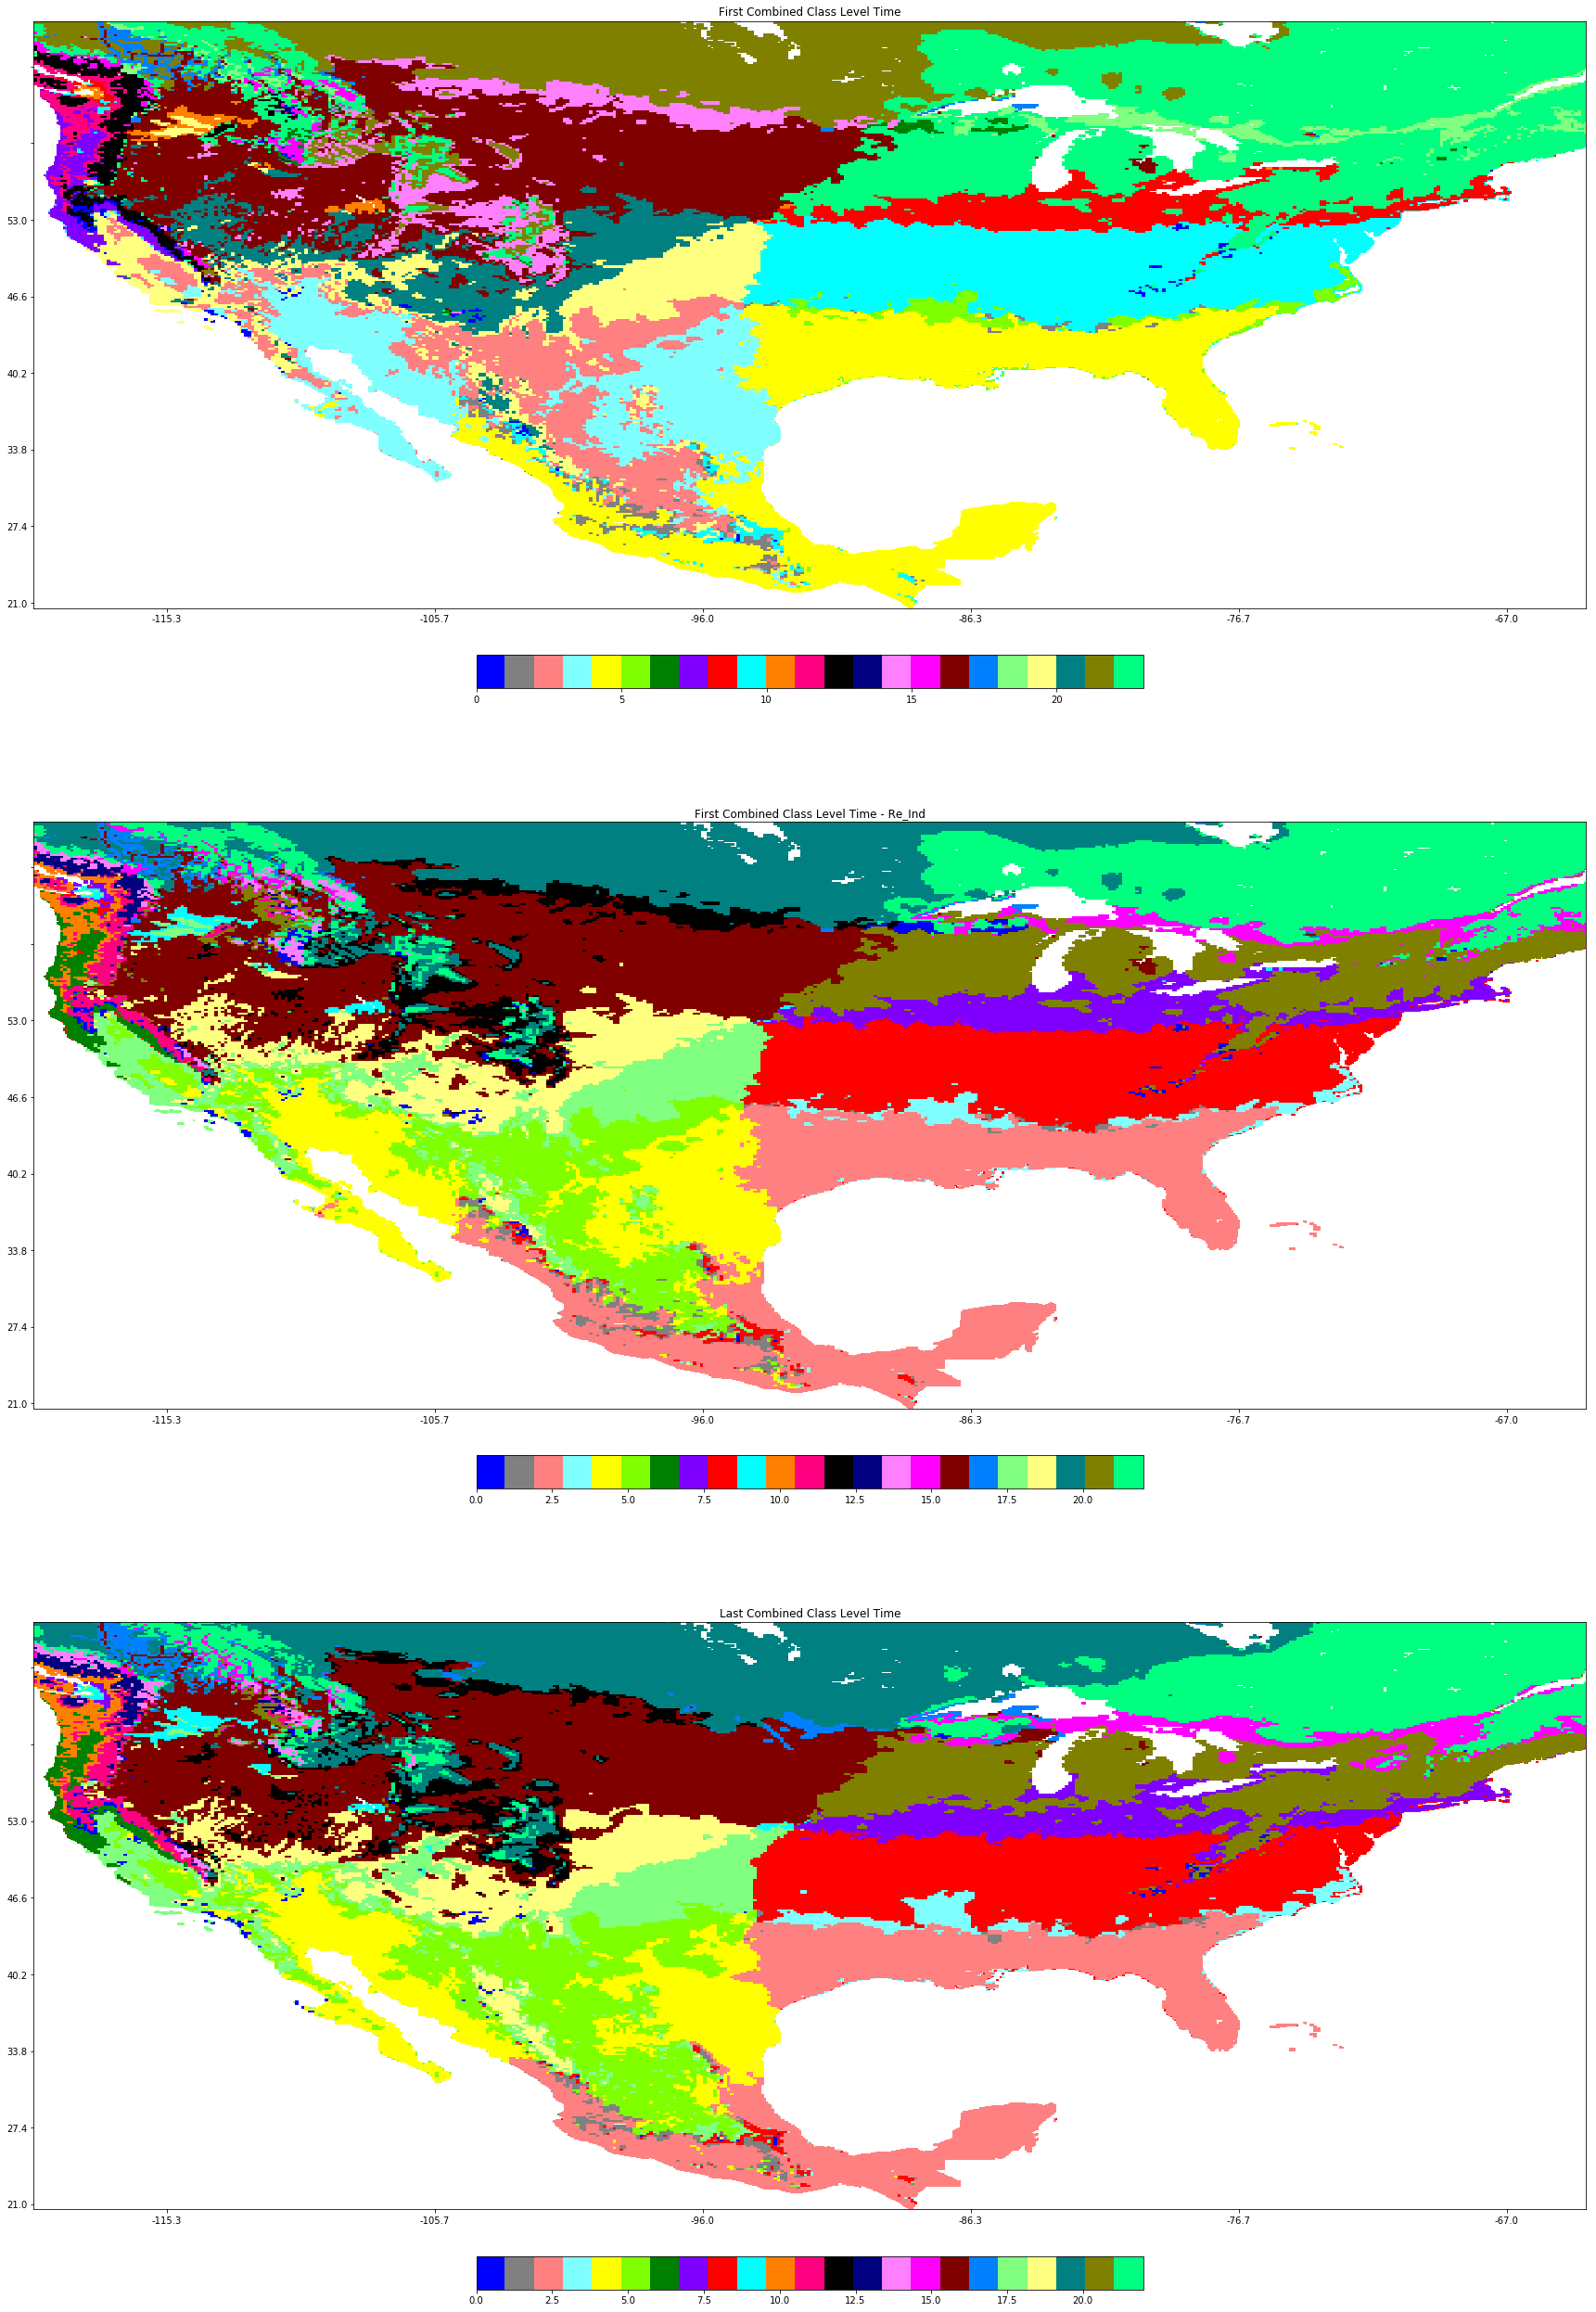

In [46]:
f, ax = plt.subplots(figsize=(30, 45), ncols=1, nrows=3)
    
    ###
    #First plot is the regular combined classes:
    ###
    
number_labels = np.nanmax(first_cluster)    
cmap = color.ListedColormap(colormap)
            #Plot Prec
p0 = ax[0].pcolormesh(ds.lon, ds.lat, plot_sets[0], vmin=0, vmax=number_labels, cmap=cmap)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
plt.colorbar(p0, ax=ax[0], orientation='horizontal',
                     pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
ax[0].set_title('First Combined Class Level Time')

ax[0].set_xticklabels(lon_space, minor=False)
ax[0].set_yticklabels(lat_space, minor=False)
    #####
    #The second plot is the re_ind versions
    #####
    
number_labels = np.nanmax(final_ordered)    
cmap = color.ListedColormap(colormap)
            #Plot Prec
p0 = ax[1].pcolormesh(ds.lon, ds.lat, final_ordered, vmin=0, vmax=number_labels, cmap=cmap)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
plt.colorbar(p0, ax=ax[1], orientation='horizontal',
                     pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
ax[1].set_title('First Combined Class Level Time - Re_Ind')

ax[1].set_xticklabels(lon_space, minor=False)
ax[1].set_yticklabels(lat_space, minor=False)

    #####
    #Last is the regular combined class of next time:
    #####
    
number_labels = np.nanmax(last_cluster)    
cmap = color.ListedColormap(colormap)
            #Plot Prec
p0 = ax[2].pcolormesh(ds.lon, ds.lat, plot_sets[1], vmin=0, vmax=number_labels, cmap=cmap)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
plt.colorbar(p0, ax=ax[2], orientation='horizontal',
                     pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
ax[2].set_title('Last Combined Class Level Time')

ax[2].set_xticklabels(lon_space, minor=False)
ax[2].set_yticklabels(lat_space, minor=False)
    
plt.show()

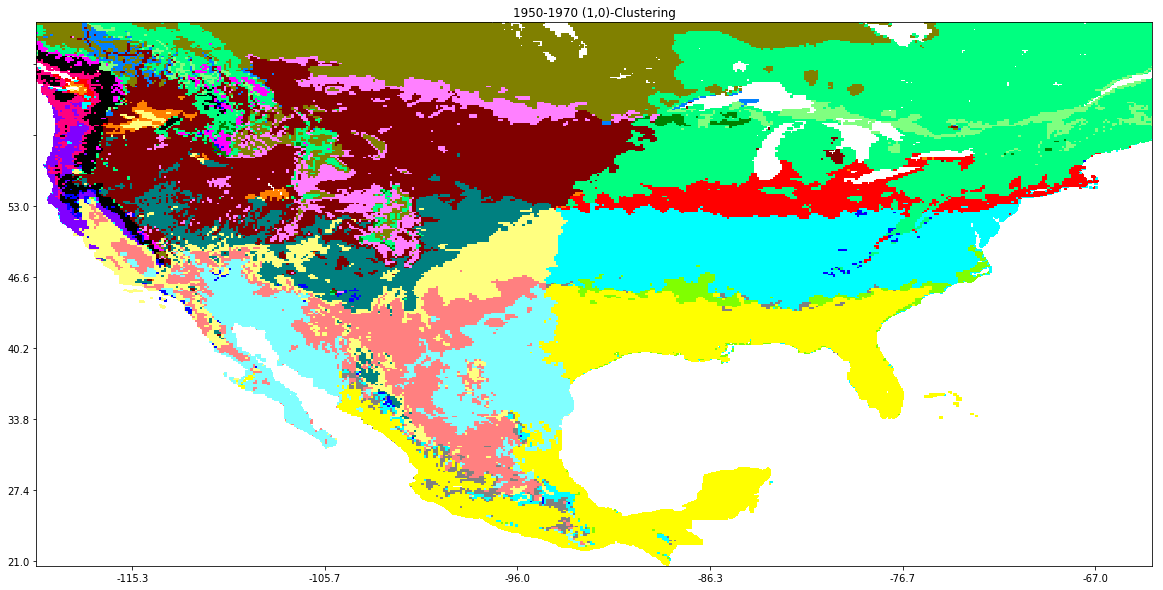

In [51]:
f, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)
    
    ###
    #First plot is the regular combined classes:
    ###
    
number_labels = np.nanmax(first_cluster)    
cmap = color.ListedColormap(colormap)
            #Plot Prec
p0 = ax.pcolormesh(ds.lon, ds.lat, plot_sets[0], vmin=0, vmax=number_labels, cmap=cmap)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
    #plt.colorbar(p0, ax=ax, orientation='horizontal',
    #                 pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
ax.set_title(str(1950) + "-" + str(1970) + " (1,0)-Clustering")

ax.set_xticklabels(lon_space, minor=False)
ax.set_yticklabels(lat_space, minor=False)

plt.show()

### Plots for talk

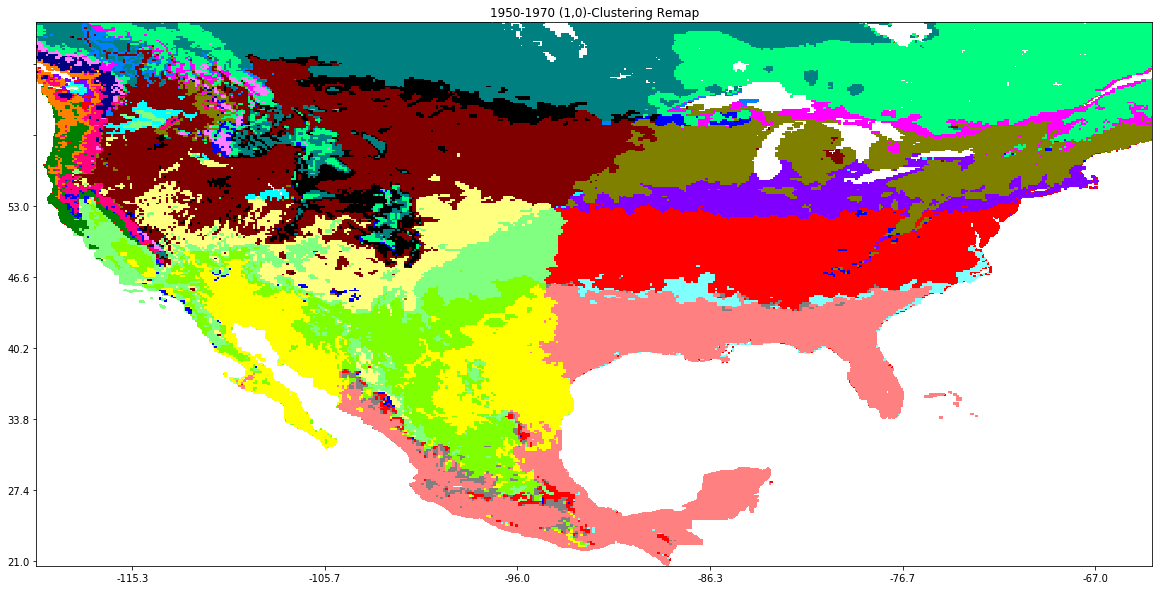

In [56]:
f, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)
    
    ###
    #First plot is the regular combined classes:
    ###
    
number_labels = np.nanmax(final_ordered)    
cmap = color.ListedColormap(colormap)
            #Plot Prec
p0 = ax.pcolormesh(ds.lon, ds.lat, final_ordered, vmin=0, vmax=number_labels, cmap=cmap)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
    #plt.colorbar(p0, ax=ax, orientation='horizontal',
    #                 pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
ax.set_title(str(1950) + "-" + str(1970) + " (1,0)-Clustering Remap")

ax.set_xticklabels(lon_space, minor=False)
ax.set_yticklabels(lat_space, minor=False)

plt.show()

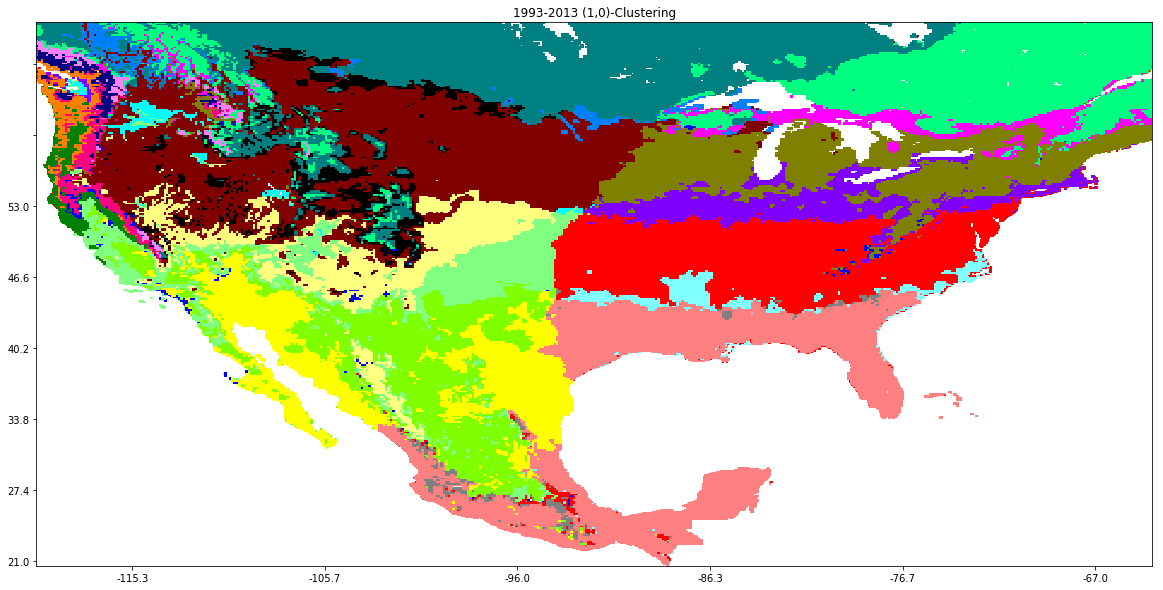

In [57]:
f, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)
    
    ###
    #First plot is the regular combined classes:
    ###
    
number_labels = np.nanmax(last_cluster)    
cmap = color.ListedColormap(colormap)
            #Plot Prec
p0 = ax.pcolormesh(ds.lon, ds.lat, plot_sets[1], vmin=0, vmax=number_labels, cmap=cmap)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
    #plt.colorbar(p0, ax=ax, orientation='horizontal',
    #                 pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
ax.set_title(str(1993) + "-" + str(2013) + " (1,0)-Clustering")

ax.set_xticklabels(lon_space, minor=False)
ax.set_yticklabels(lat_space, minor=False)

plt.show()

In [33]:
biome_final = plot_sets[1] - final_ordered
biome_final[biome_final !=0] =1
biome_final = biome_final + nan_mask_slice

In [35]:
2013-20

1993

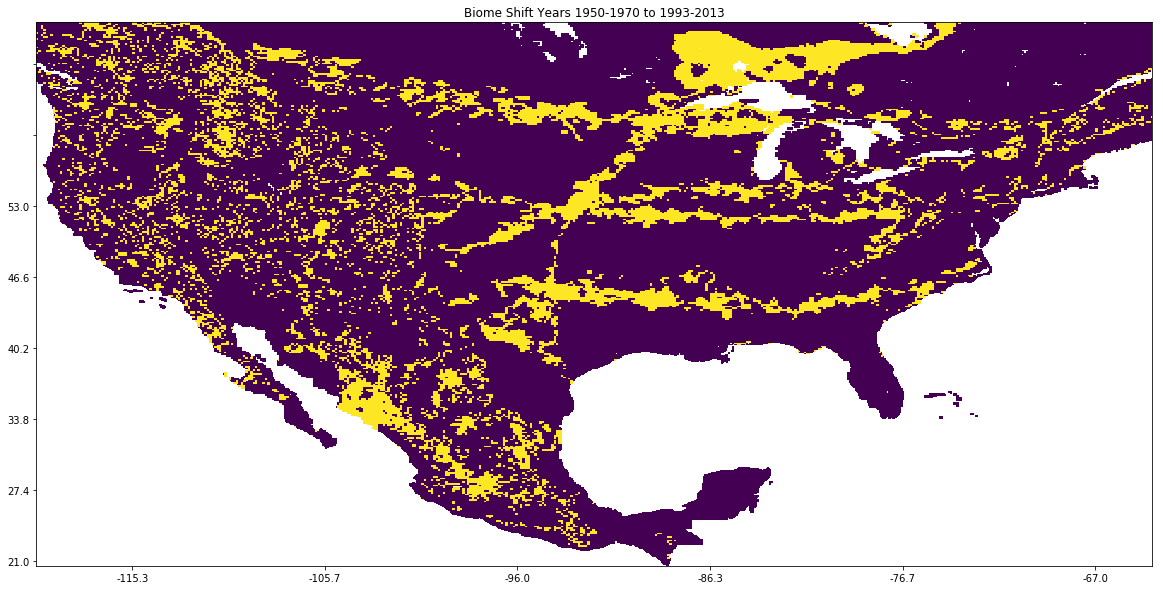

In [36]:
f, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)
    
    ###
    #First plot is the regular combined classes:
    ###
    
number_labels = 1
cmap = color.ListedColormap(colormap)
            #Plot Prec
p0 = ax.pcolormesh(ds.lon, ds.lat, biome_final, vmin=0, vmax=number_labels)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
    #plt.colorbar(p0, ax=ax, orientation='horizontal',
    #                 pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
ax.set_title("Biome Shift Years " + str(1950) + "-" + str(1970) + " to " + str(1993) + "-" + str(2013))

ax.set_xticklabels(lon_space, minor=False)
ax.set_yticklabels(lat_space, minor=False)

plt.show()

# Plotting Clusters - All

In [1182]:
#The purpose for this part of the code is to plot the raw clustering obtained using the same color bar.

In [1183]:
#This cell builds a colormap to be used for plotting the combined clusterings:

#Find the largest number of colors needed
color_counter = []
for i in range(num_clusterings):
    color_counter.append(np.max(label_sets[()][i]))
    
color_count = np.max(color_counter)

#Produce colorbar:

#Take a cube root of the largest number of colors needed to split across RBG
k = np.ceil(int(color_count)**(.3333))

#Build the numpy array of the evenly spaced colors
c_space = np.linspace(0,1,k)
l = c_space.size
colormap = np.zeros((l**3,3))

index= -1
for i in range(l):
    for j in range(l):
        for k in range(l):
            index+=1
            colormap[index] = [c_space[i],c_space[j],c_space[k]]

#This produces too many colors - in particular it includes the color of (1,1,1) reserved for the nan values.  
#Randomize to subset-take only as many as needed
color_ind = random.sample(range(l**3-1), int(color_count))
color_ind = np.array(color_ind)
colormap = colormap[color_ind,:]

/Users/ddesantis/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


In [1184]:
#For plotting, we need to add the nan_mask.
plot_sets = {}
for i in range(num_clusterings):
    plot_sets[i] = label_sets[()][i] + nan_mask_slice

In [1257]:
ds.time

<xarray.DataArray 'time' (time: 768)>
array(['1950-01-16T00:00:00.000000000', '1950-02-14T12:00:00.000000000',
       '1950-03-16T00:00:00.000000000', ..., '2013-10-16T00:00:00.000000000',
       '2013-11-15T12:00:00.000000000', '2013-12-16T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-01-16 1950-02-14T12:00:00 1950-03-16 ...
Attributes:
    standard_name:  time
    long_name:      Time axis

[Text(0,0,'14.7'),
 Text(0,0,'21.0'),
 Text(0,0,'27.4'),
 Text(0,0,'33.8'),
 Text(0,0,'40.2'),
 Text(0,0,'46.6'),
 Text(0,0,'53.0')]

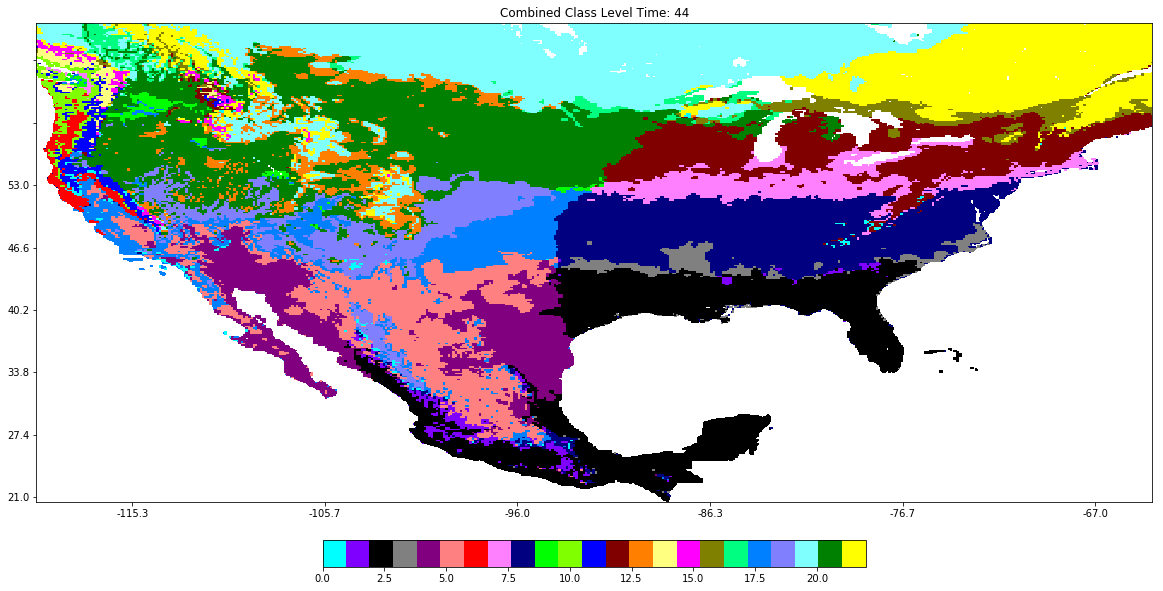

In [1256]:
f, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)

number_labels = np.nanmax(plot_sets[i])    
cmap = color.ListedColormap(colormap)
p0 = ax.pcolormesh(ds.lon, ds.lat, plot_sets[44], cmap=cmap)
    #p0 = plt.imshow(lexabels, cmap="Set3", origin = [0,0])
plt.colorbar(p0, ax=ax, orientation='horizontal',
                 pad=0.07, fraction=0.05)
    #p.clim(0, number_labels)
ax.set_title('Combined Class Level Time: ' + str(44))

ax.set_xticklabels(lon_space, minor=False)
ax.set_yticklabels(lat_space, minor=False)

KeyboardInterrupt: 

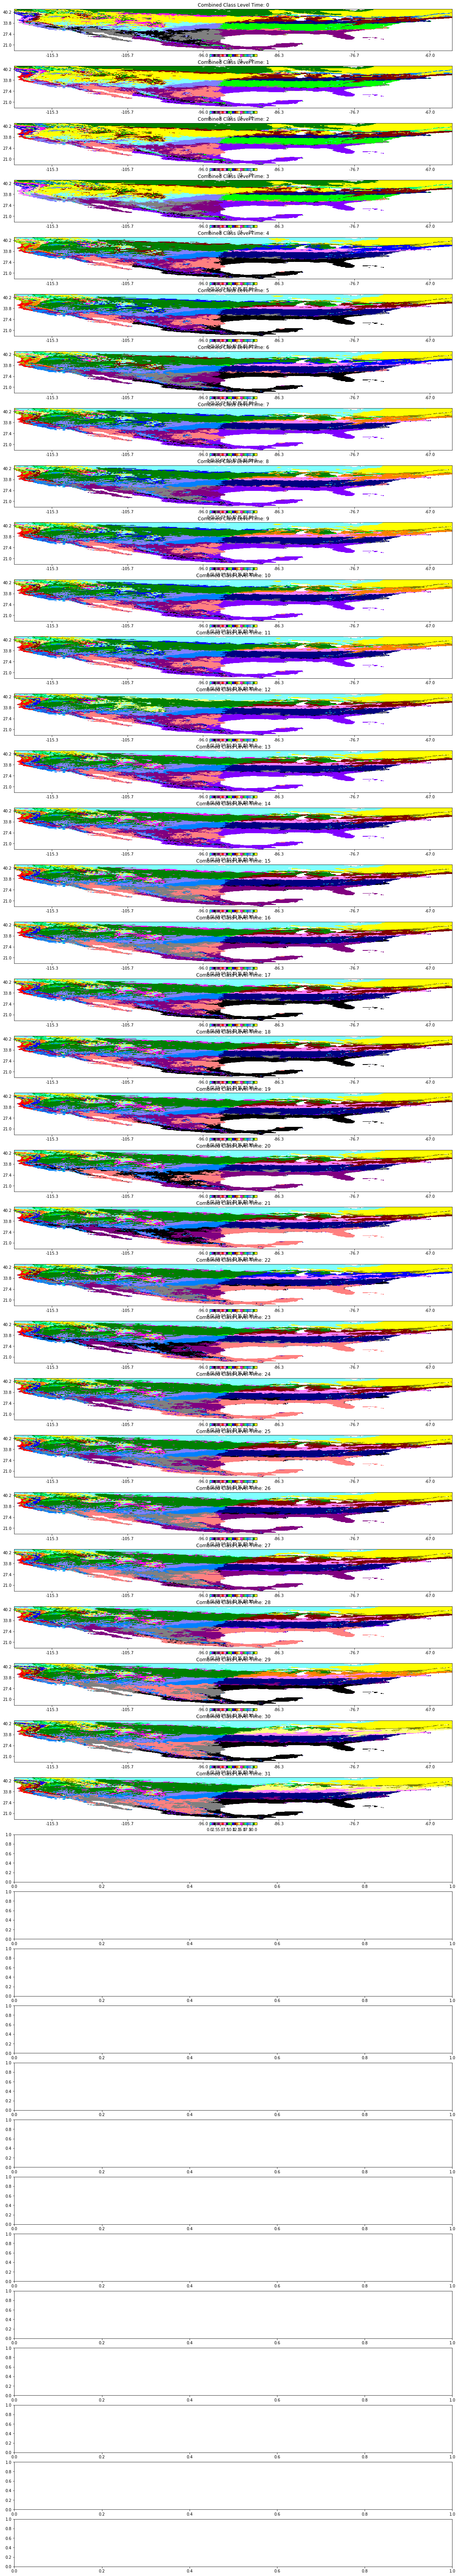

In [1244]:
#Plot each of the combined clusters:

f, ax = plt.subplots(figsize=(20, 15*8), ncols=1, nrows=num_clusterings)

for i in range(num_clusterings):
    number_labels = np.nanmax(plot_sets[i])    
    cmap = color.ListedColormap(colormap)
    p0 = ax[i].pcolormesh(ds.lon, ds.lat, plot_sets[i], vmin=0, vmax=number_labels, cmap=cmap)
    #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
    plt.colorbar(p0, ax=ax[i], orientation='horizontal',
                 pad=0.07, fraction=0.05)
    #p.clim(0, number_labels)
    ax[i].set_title('Combined Class Level Time: ' + str(i))

    ax[i].set_xticklabels(lon_space, minor=False)
    ax[i].set_yticklabels(lat_space, minor=False)

plt.show()

# Test on Real Data

In [1191]:
#Create a dictionary of the clusterings
clusters = {}
for i in range(num_clusterings):
    clusters[i] = label_sets[()][i]

In [1192]:
#Given a clustering, find the locations of each cluster value
t_loc = {}
for i in range(num_clusterings):
    t_loc[i] = create_locs(clusters[i])

In [1193]:
#cluster_tracking(t_loc[0], t_loc[1])

In [1194]:
#Takes 344 seconds per run
#Time to run this on all time slices (((44)*344)/60)/60

In [1195]:
# plt.figure(figsize=(20,10))
# #p0= plt.pcolormesh(tracking[(i,i+1)], cmap="hot")
# p0 = plt.pcolormesh(tracking[0,1], cmap="hot")
# plt.colorbar(p0)
# plt.ylabel("Clustering " + str(i))
# plt.xlabel("Clustering " + str(i+1))
# plt.show()

In [1196]:
#Track how the clusters change from one clustering to the next
tracking = {}
for i in range(num_clusterings-1):
    E = cluster_tracking(t_loc[i], t_loc[i+1])
    tracking[(i,i+1)] = E

Class: 0.0
Class: 1.0
Class: 2.0
Class: 3.0
Class: 4.0
Class: 5.0
Class: 6.0
Class: 7.0
Class: 8.0
Class: 9.0
Class: 10.0
Class: 11.0
Class: 12.0
Class: 13.0
Class: 14.0
Class: 15.0
Class: 16.0
Class: 17.0
Class: 18.0
Class: 19.0
Class: 20.0
Class: 21.0
Class: 22.0
Class: 23.0
Tracking Time: 348.827619076

Class: 0.0
Class: 1.0
Class: 2.0
Class: 3.0
Class: 4.0
Class: 5.0
Class: 6.0
Class: 7.0
Class: 8.0
Class: 9.0
Class: 10.0
Class: 11.0
Class: 12.0
Class: 13.0
Class: 14.0
Class: 15.0
Class: 16.0
Class: 17.0
Class: 18.0
Class: 19.0
Class: 20.0
Class: 21.0
Class: 22.0
Class: 23.0
Tracking Time: 349.256149054

Class: 0.0
Class: 1.0
Class: 2.0
Class: 3.0
Class: 4.0
Class: 5.0
Class: 6.0
Class: 7.0
Class: 8.0
Class: 9.0
Class: 10.0
Class: 11.0
Class: 12.0
Class: 13.0
Class: 14.0
Class: 15.0
Class: 16.0
Class: 17.0
Class: 18.0
Class: 19.0
Class: 20.0
Class: 21.0
Class: 22.0
Class: 23.0
Tracking Time: 348.939274788

Class: 0.0
Class: 1.0
Class: 2.0
Class: 3.0
Class: 4.0
Class: 5.0
Class: 6.0

Class: 14.0
Class: 15.0
Class: 16.0
Class: 17.0
Class: 18.0
Class: 19.0
Class: 20.0
Class: 21.0
Class: 22.0
Tracking Time: 342.360441923

Class: 0.0
Class: 1.0
Class: 2.0
Class: 3.0
Class: 4.0
Class: 5.0
Class: 6.0
Class: 7.0
Class: 8.0
Class: 9.0
Class: 10.0
Class: 11.0
Class: 12.0
Class: 13.0
Class: 14.0
Class: 15.0
Class: 16.0
Class: 17.0
Class: 18.0
Class: 19.0
Class: 20.0
Class: 21.0
Class: 22.0
Tracking Time: 344.046997786

Class: 0.0
Class: 1.0
Class: 2.0
Class: 3.0
Class: 4.0
Class: 5.0
Class: 6.0
Class: 7.0
Class: 8.0
Class: 9.0
Class: 10.0
Class: 11.0
Class: 12.0
Class: 13.0
Class: 14.0
Class: 15.0
Class: 16.0
Class: 17.0
Class: 18.0
Class: 19.0
Class: 20.0
Class: 21.0
Class: 22.0
Tracking Time: 343.702082872

Class: 0.0
Class: 1.0
Class: 2.0
Class: 3.0
Class: 4.0
Class: 5.0
Class: 6.0
Class: 7.0
Class: 8.0
Class: 9.0
Class: 10.0
Class: 11.0
Class: 12.0
Class: 13.0
Class: 14.0
Class: 15.0
Class: 16.0
Class: 17.0
Class: 18.0
Class: 19.0
Class: 20.0
Class: 21.0
Class: 22.0
Trac

In [1203]:
#np.save('tracking_0_1_240', tracking)

Before


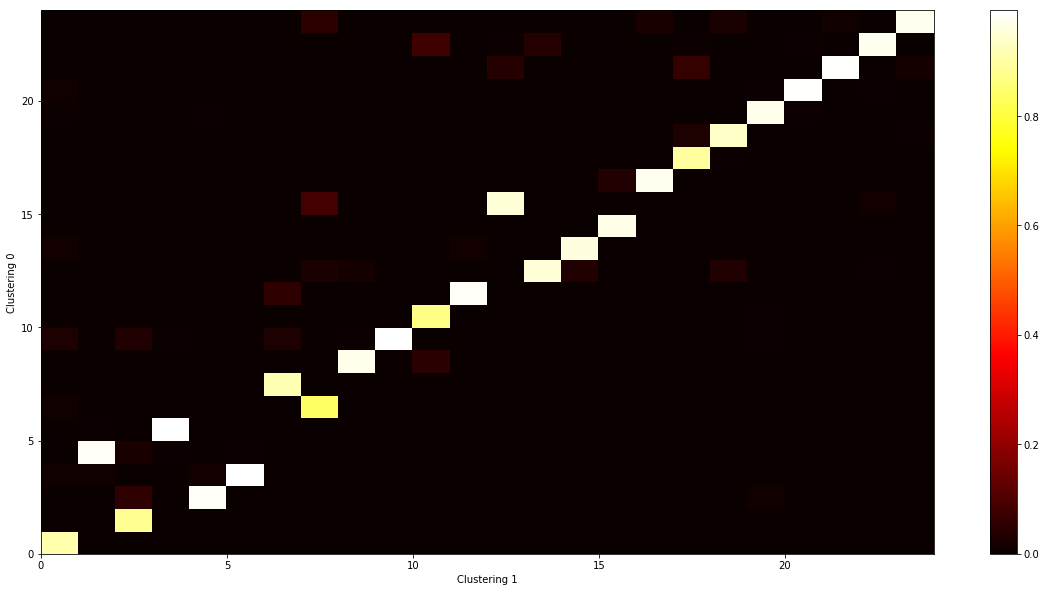

After


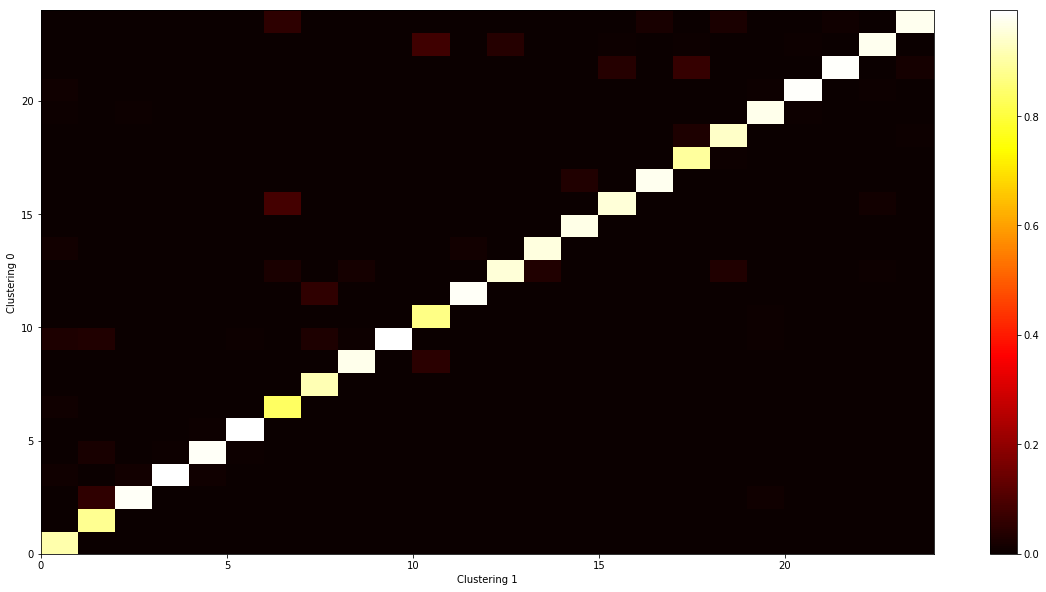

Before


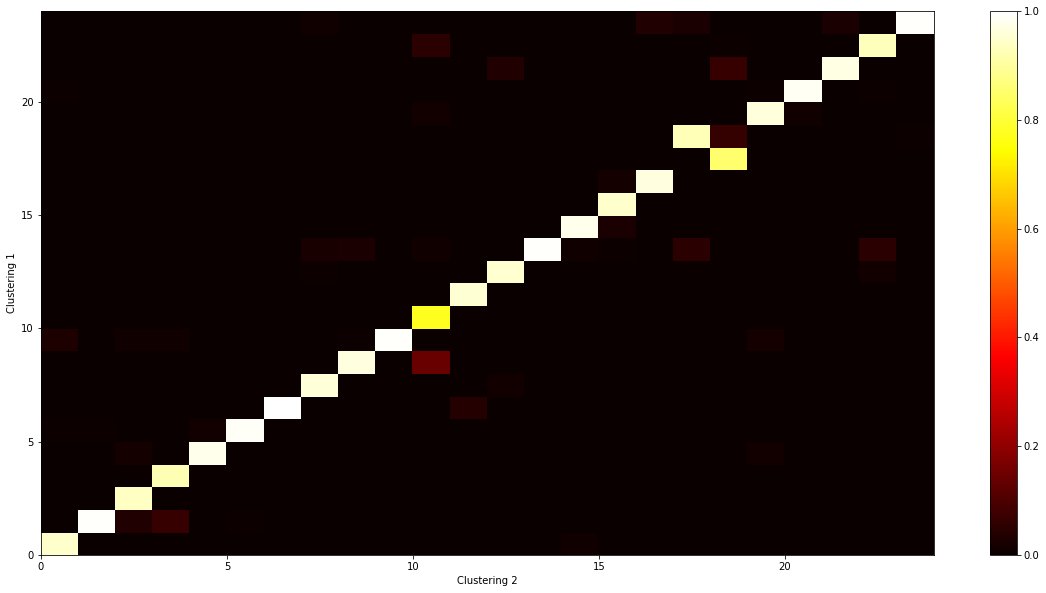

After


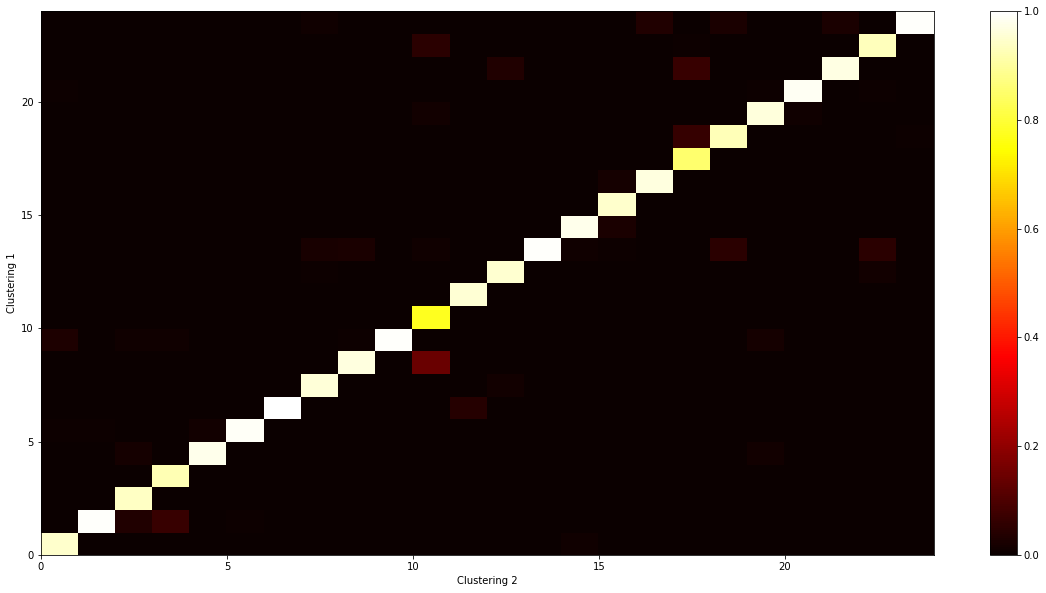

Before


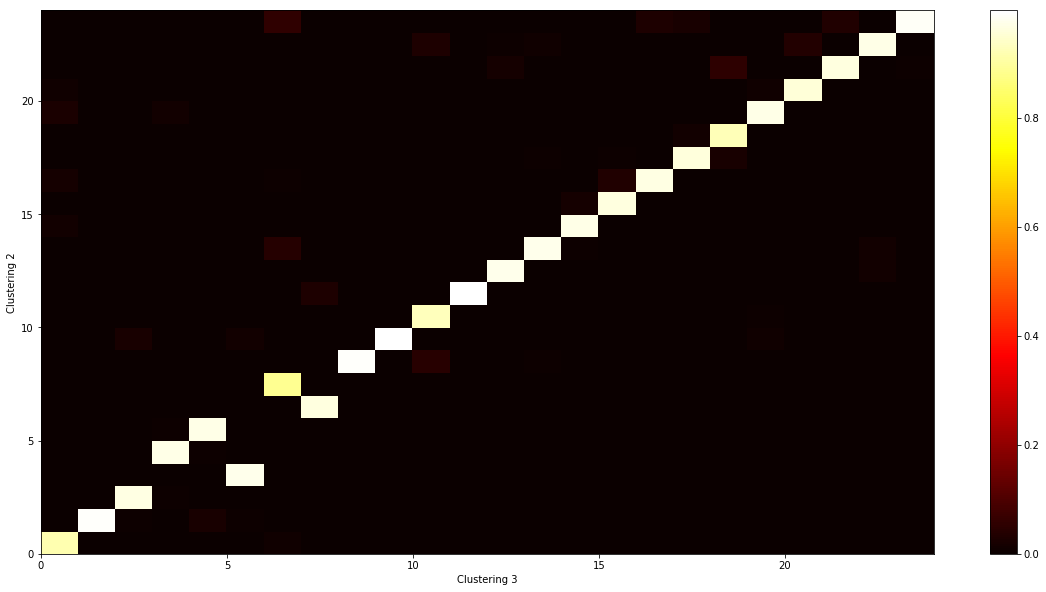

After


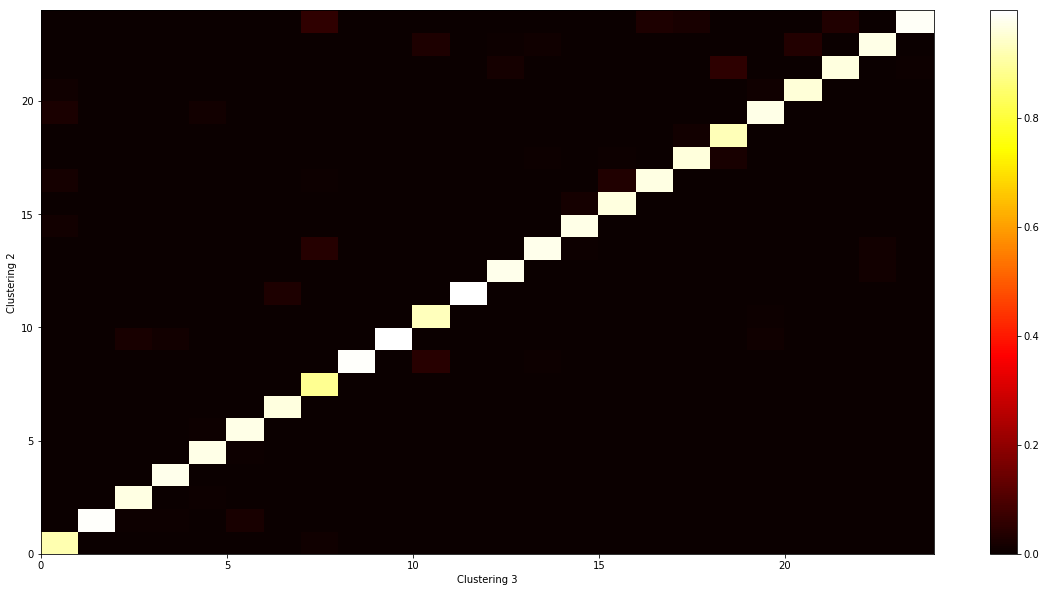

Before


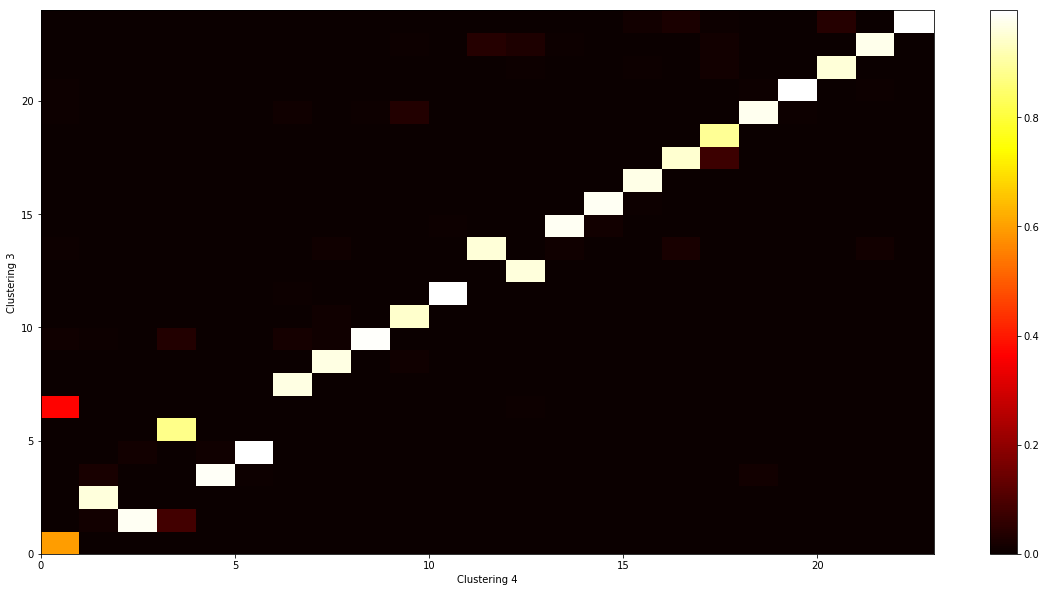

After


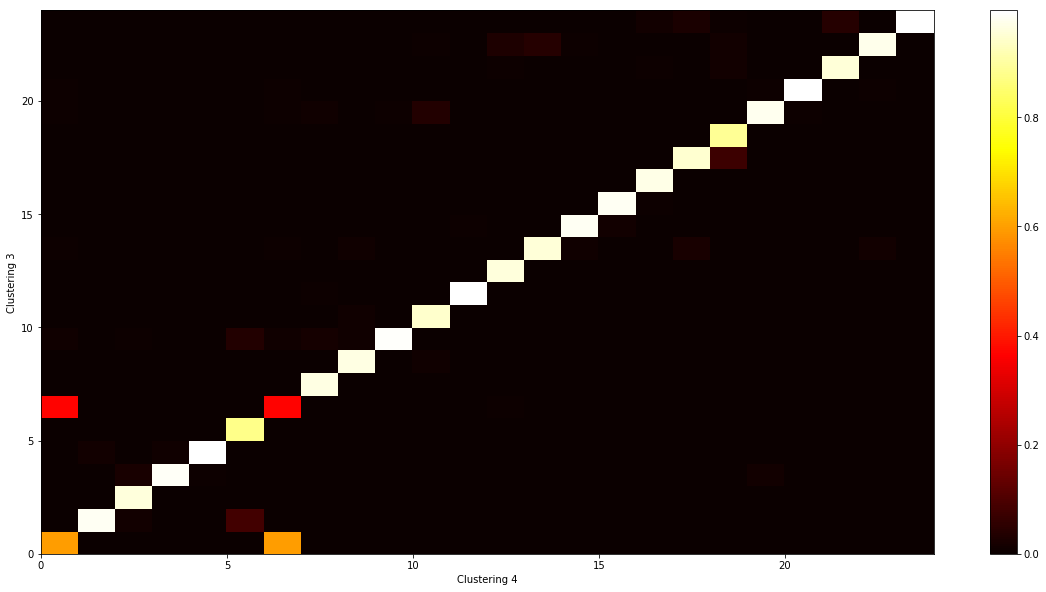

Before


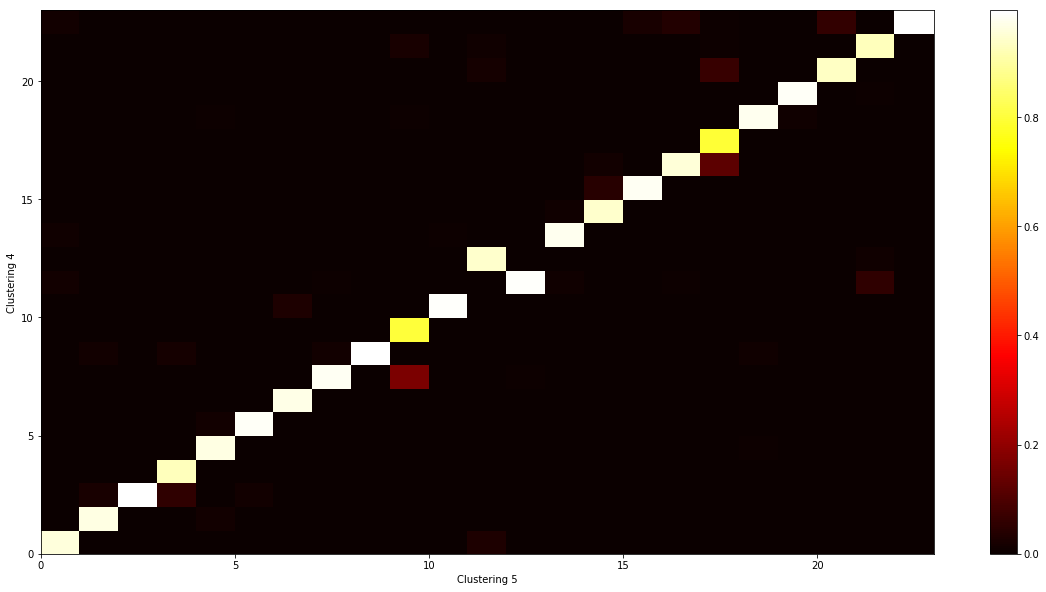

After


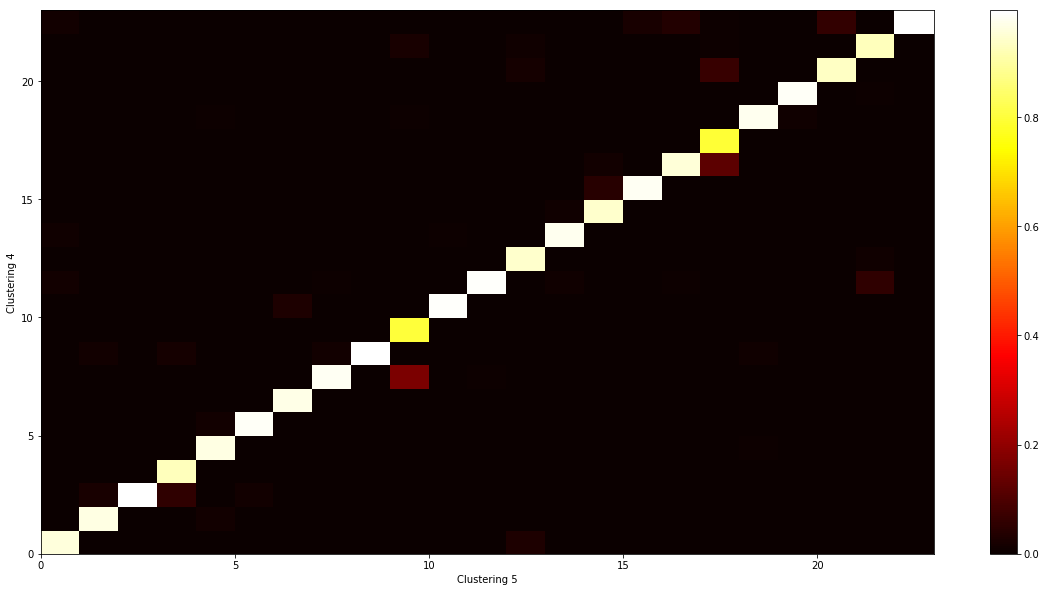

Before


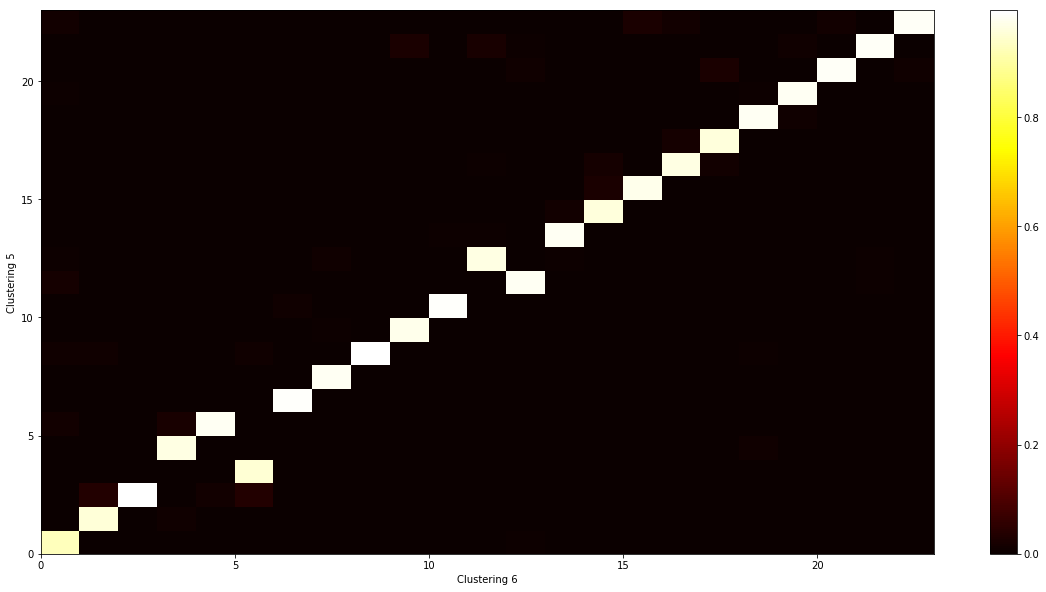

After


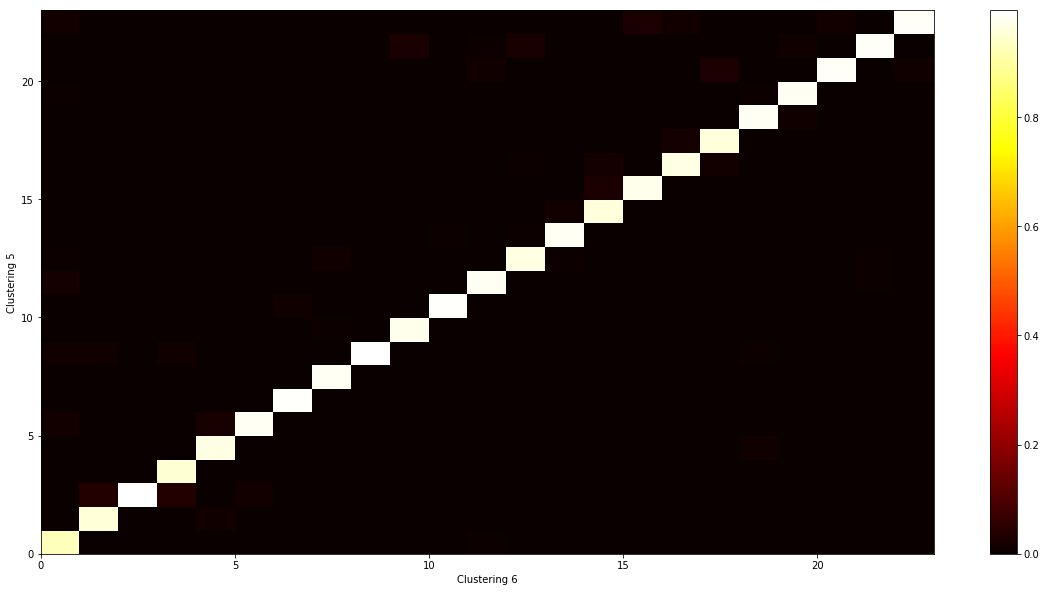

Before


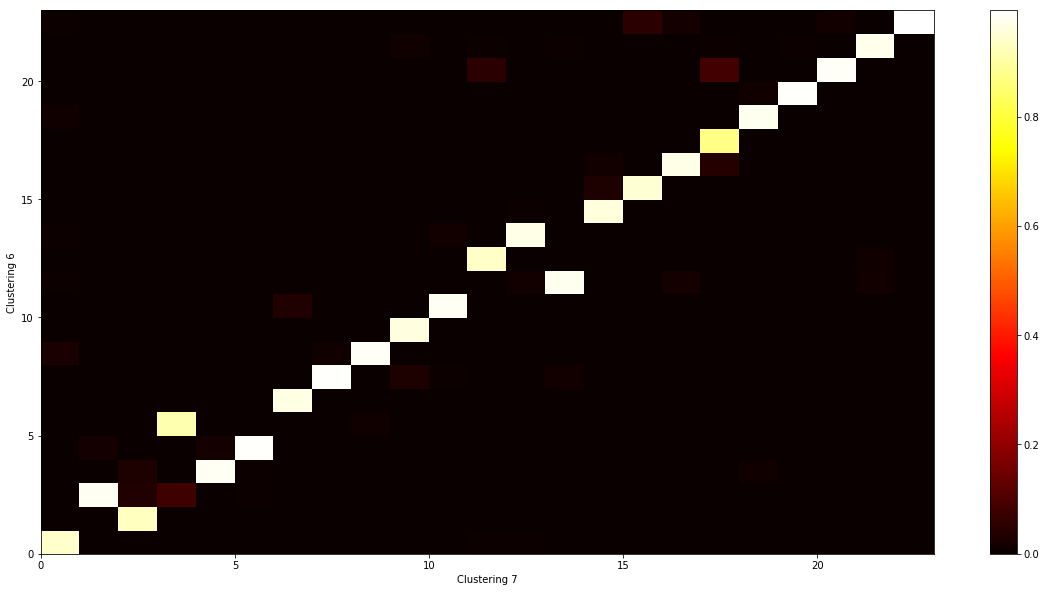

After


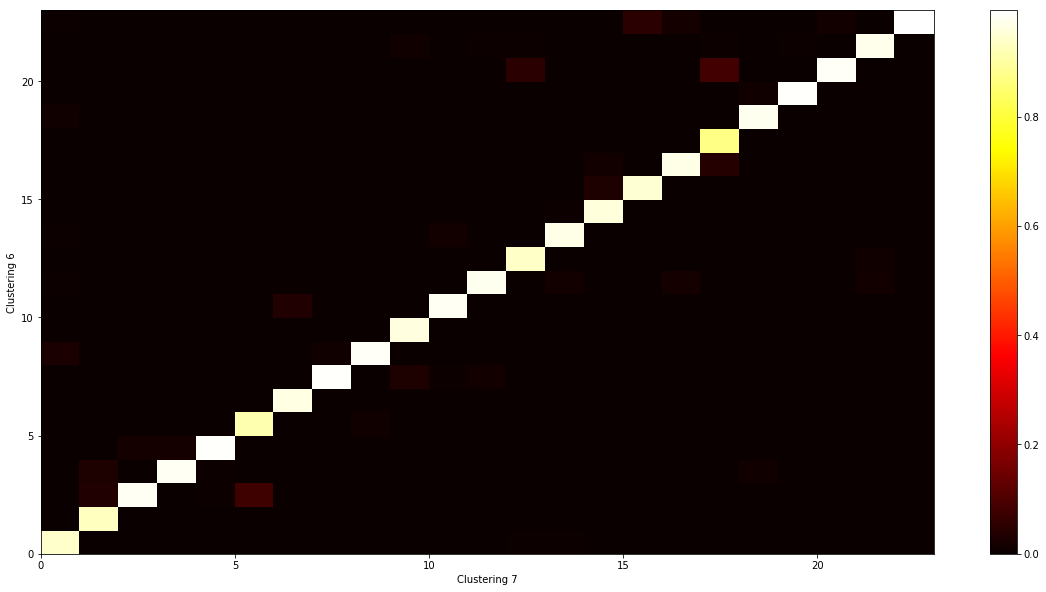

Before


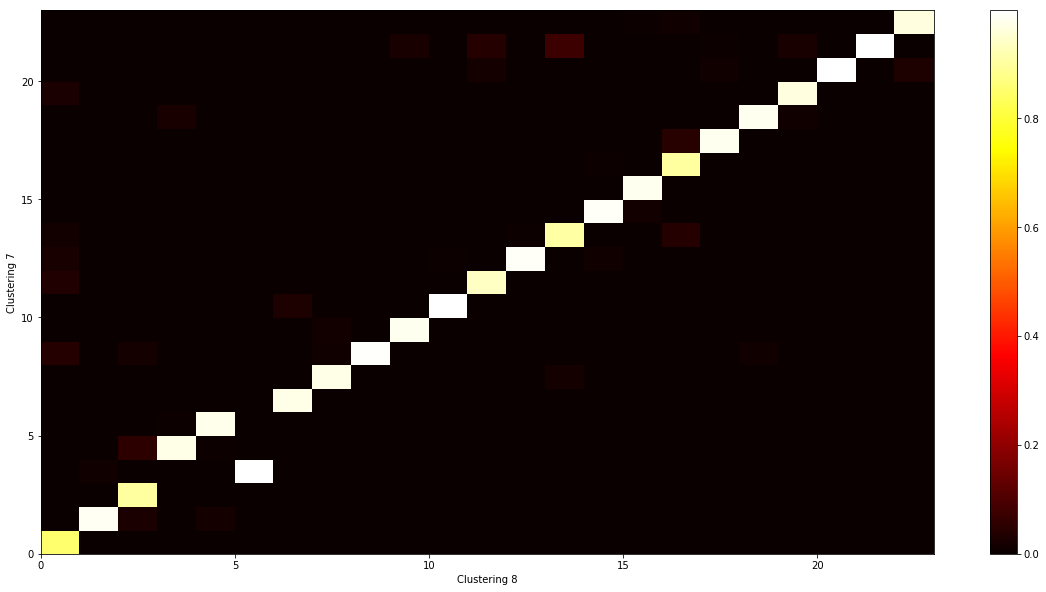

After


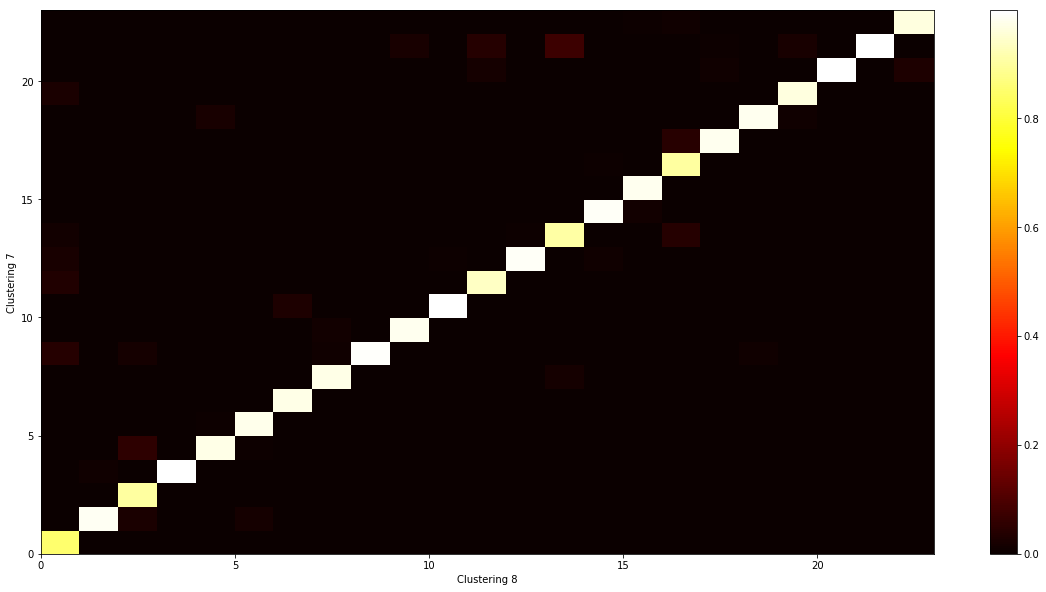

Before


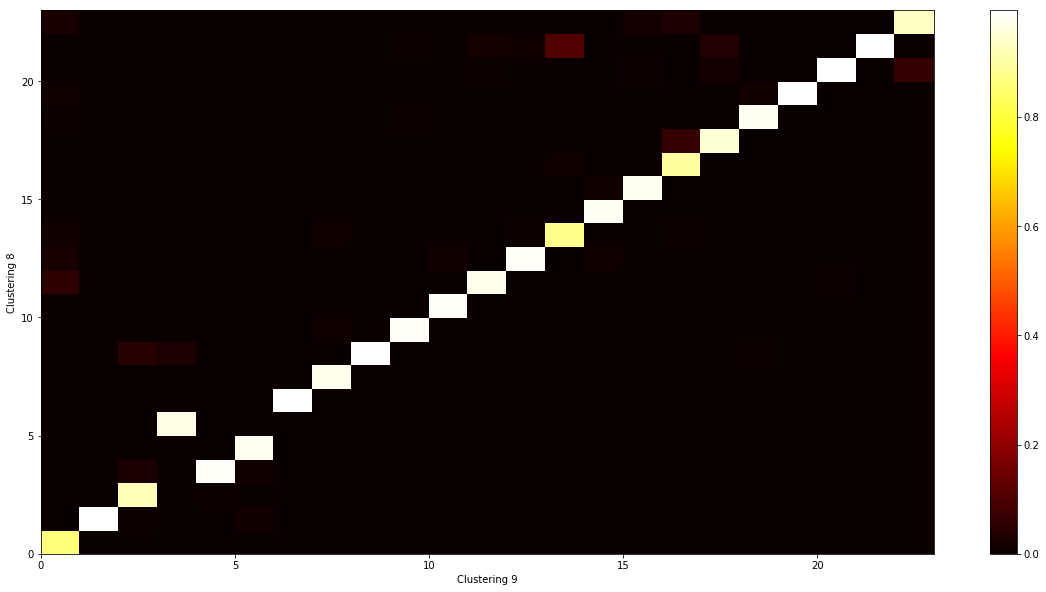

After


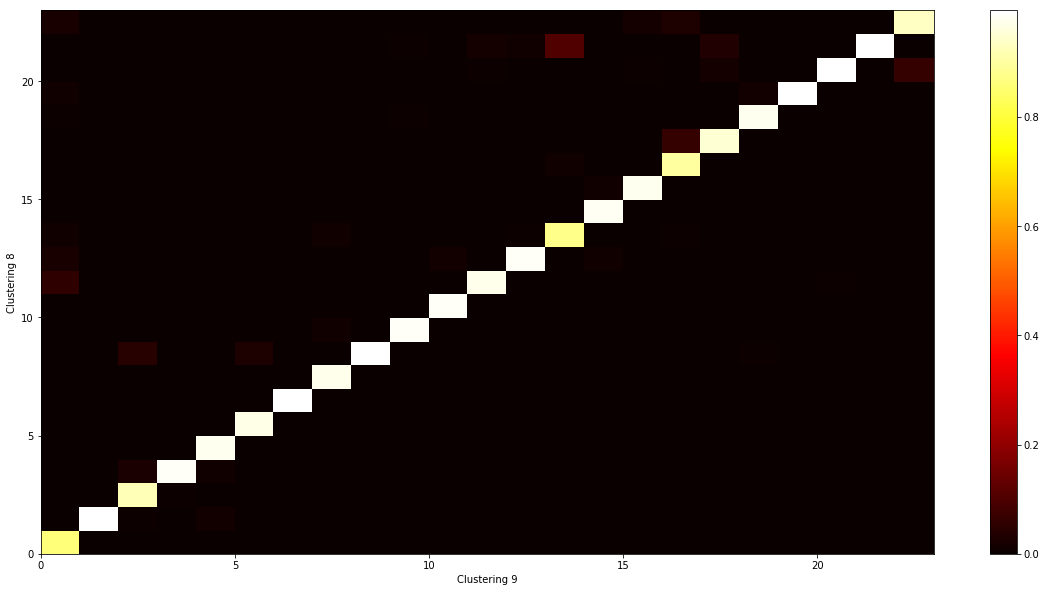

Before


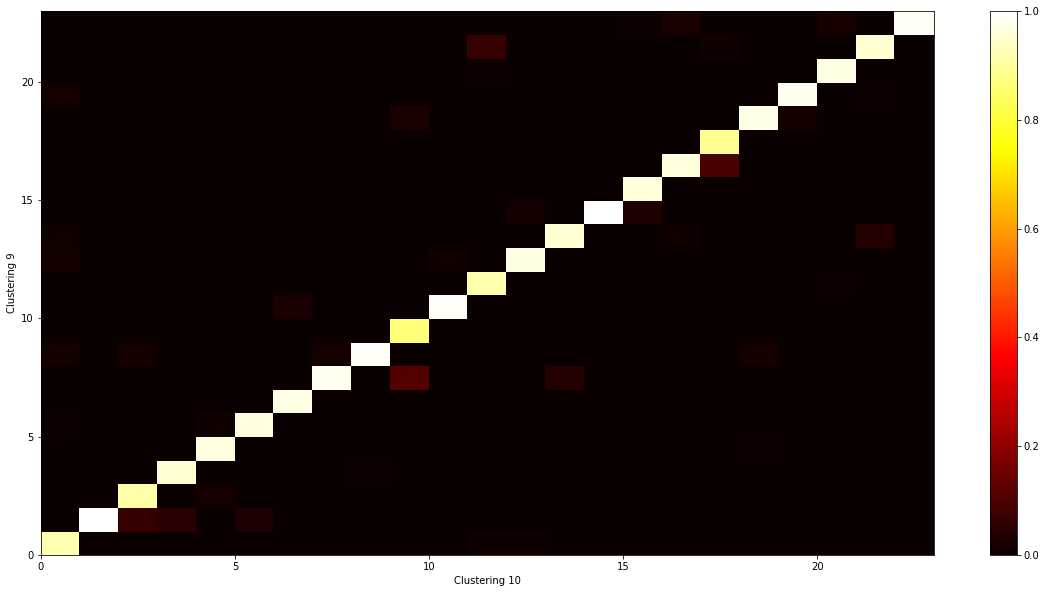

After


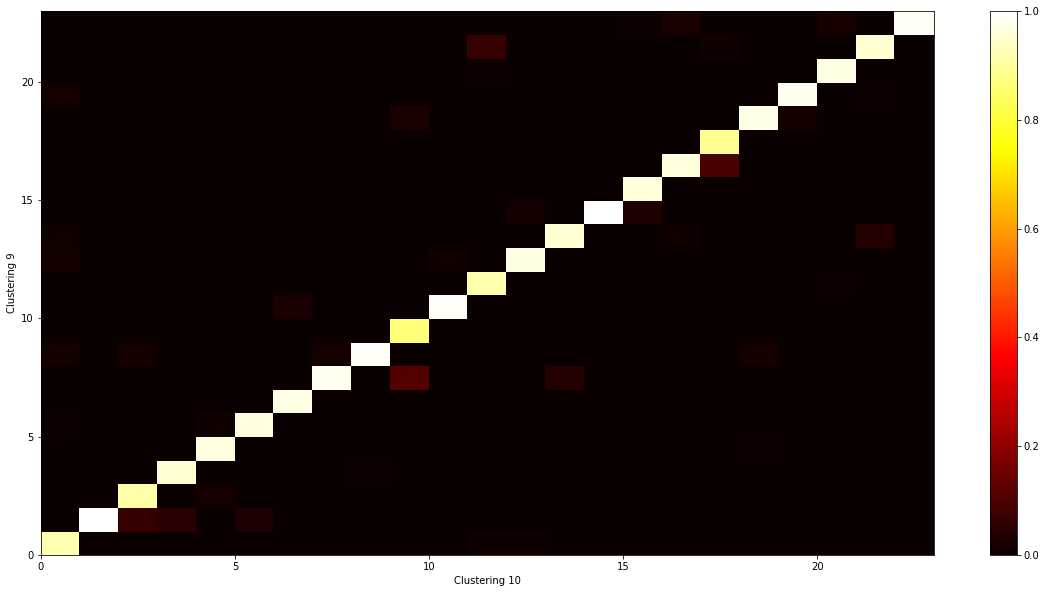

Before


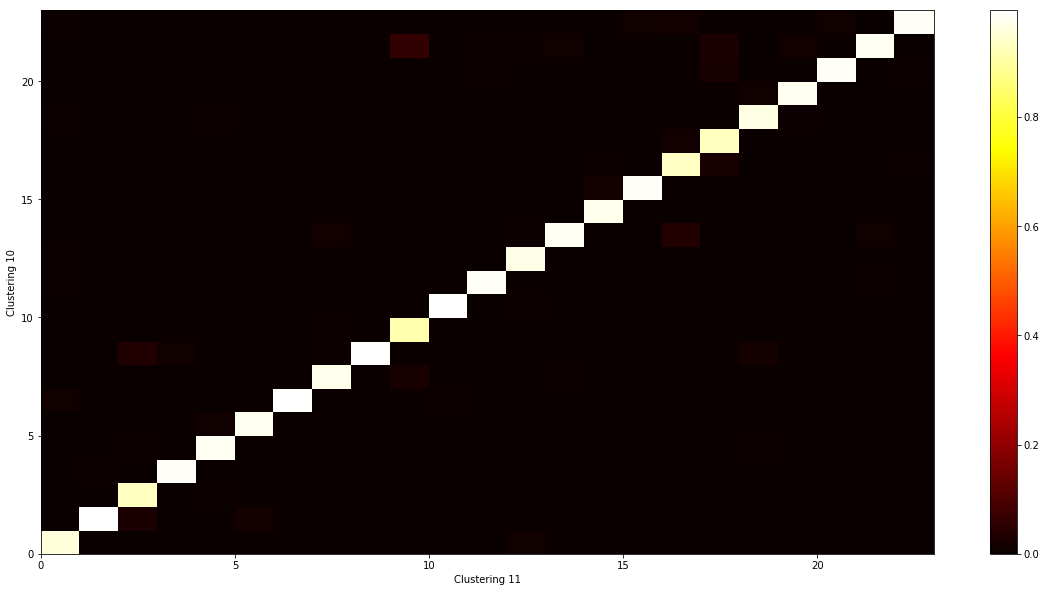

After


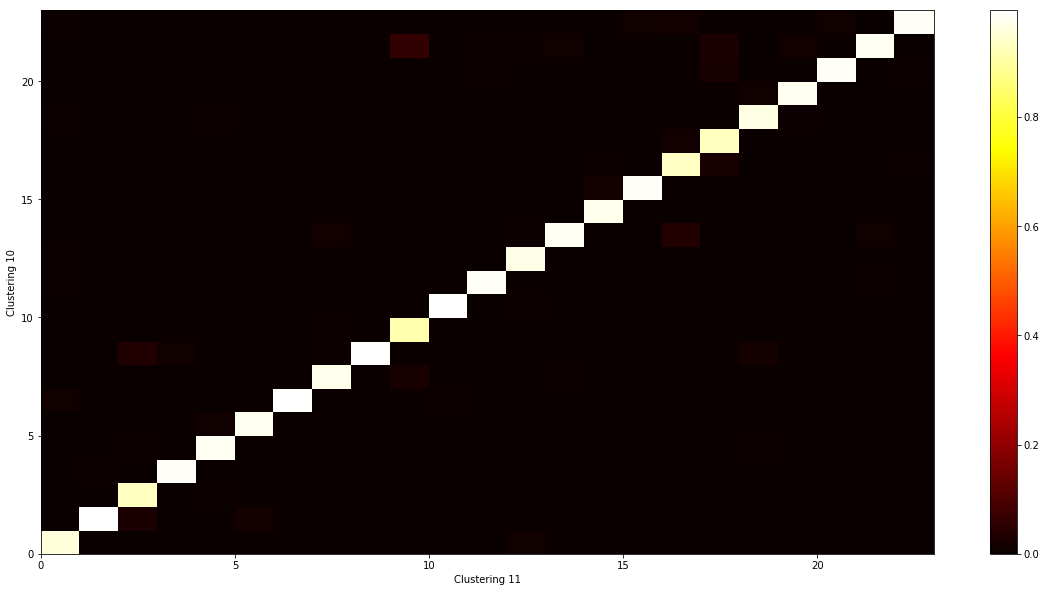

Before


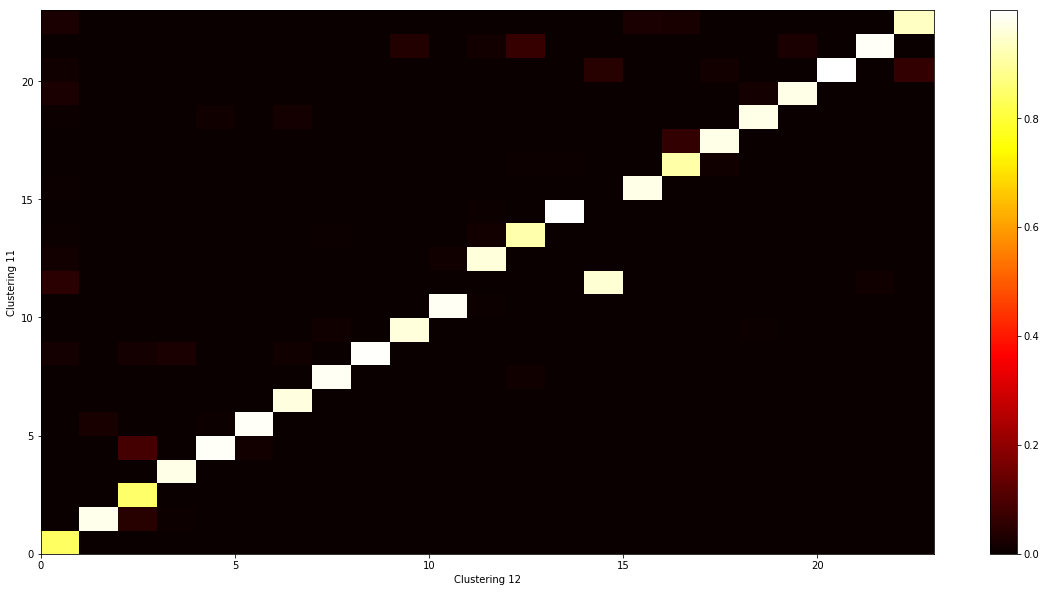

After


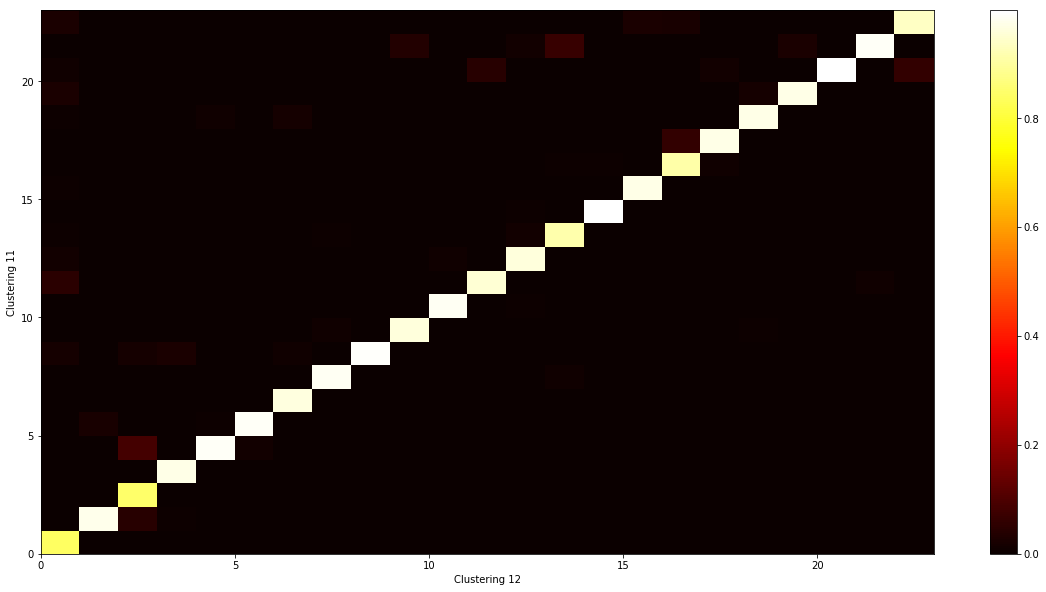

Before


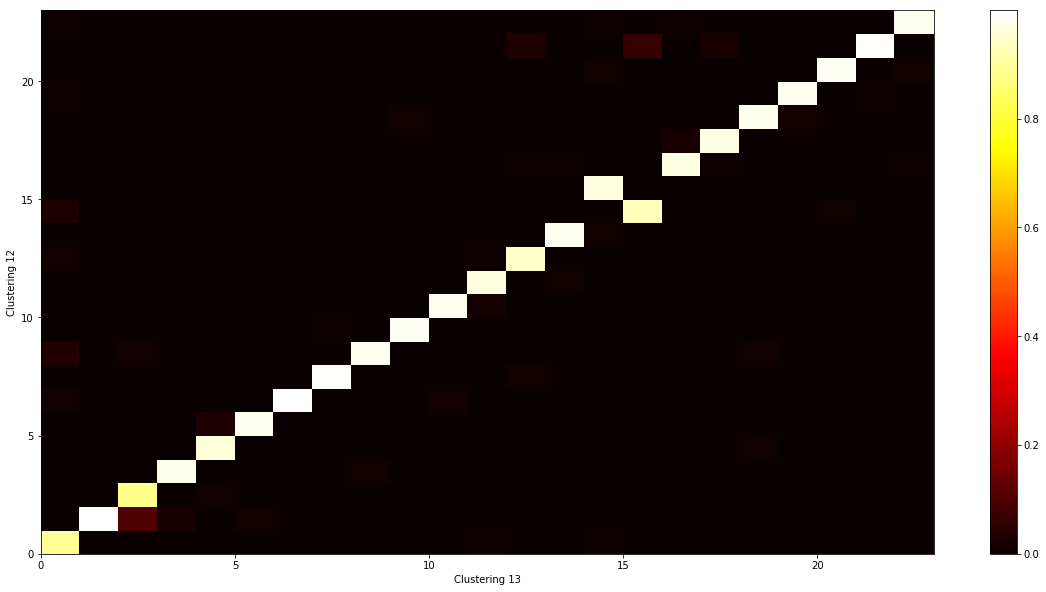

After


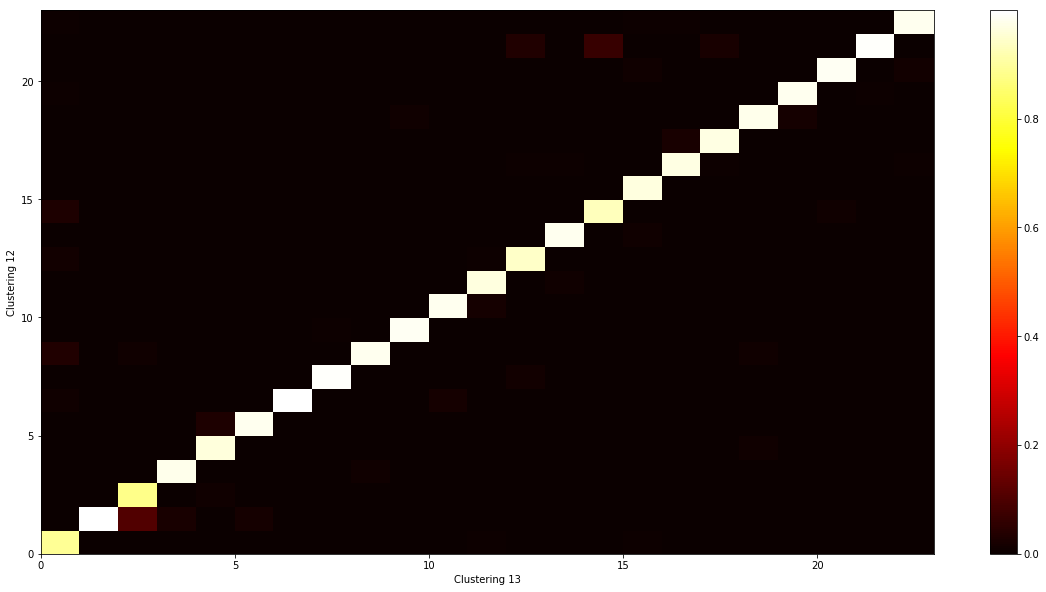

Before


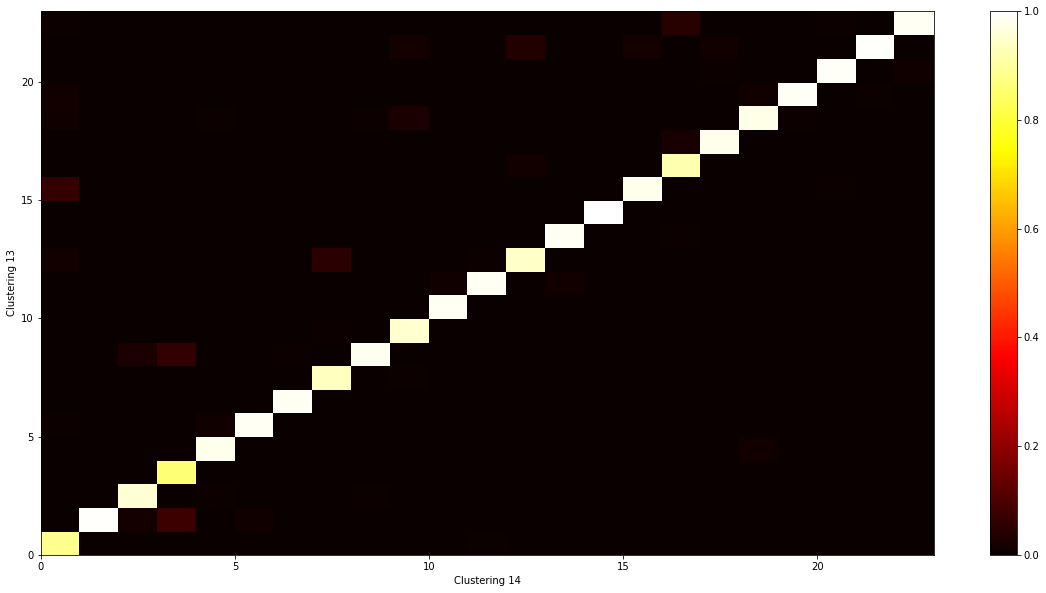

After


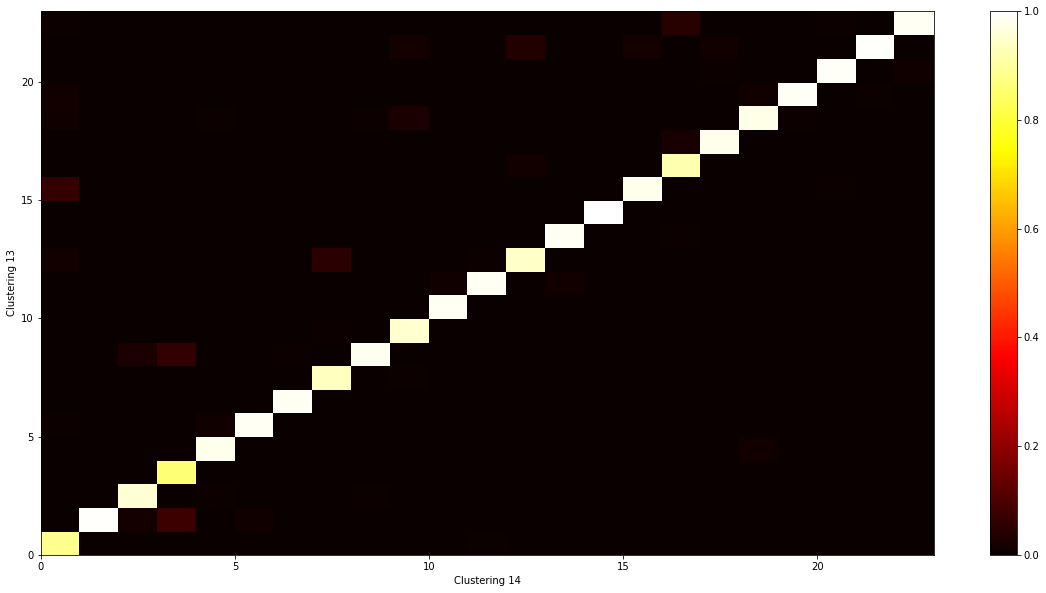

Before


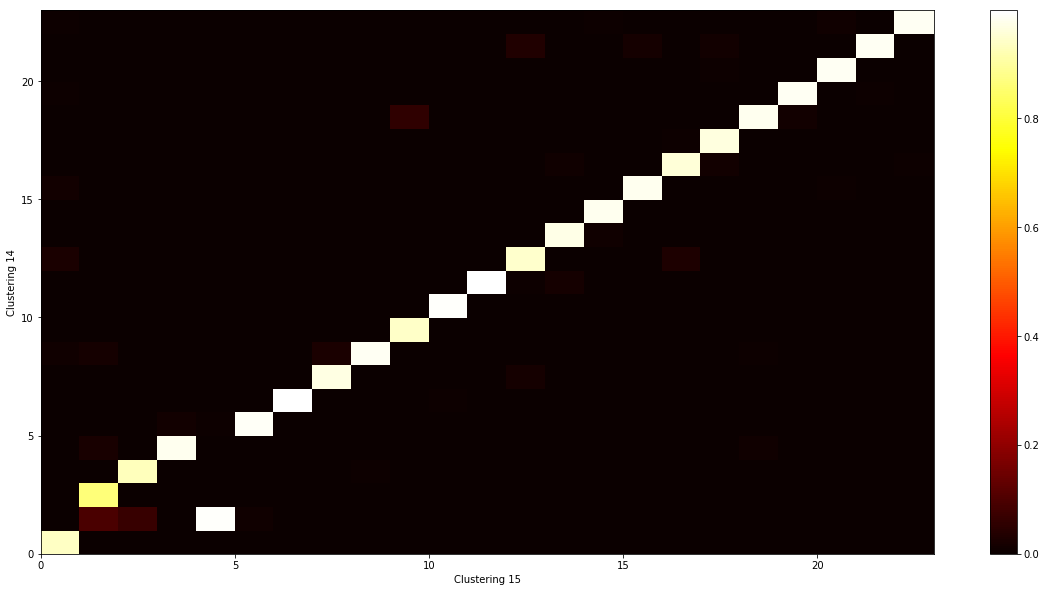

After


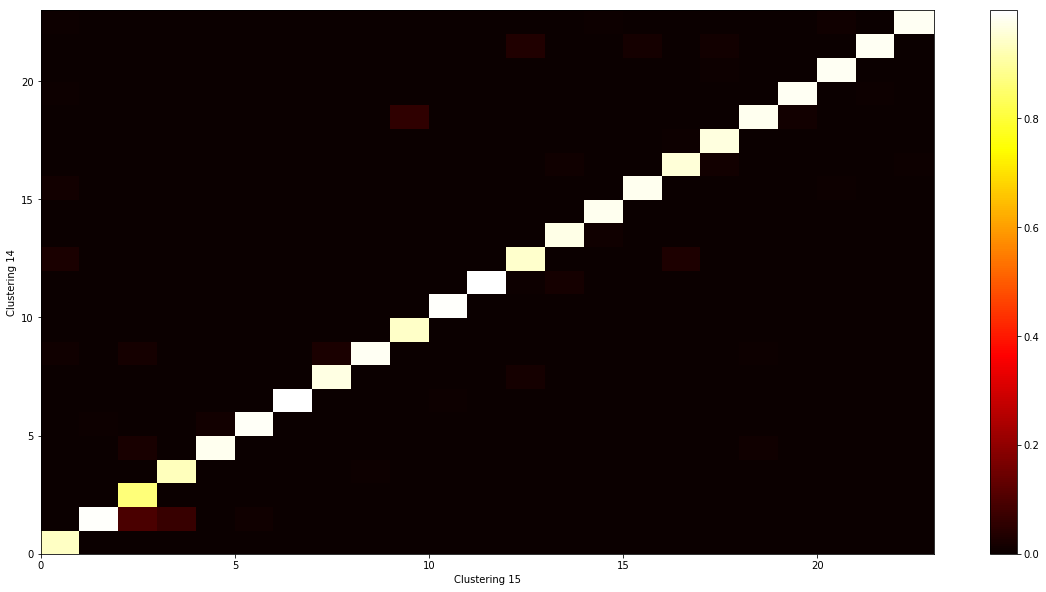

Before


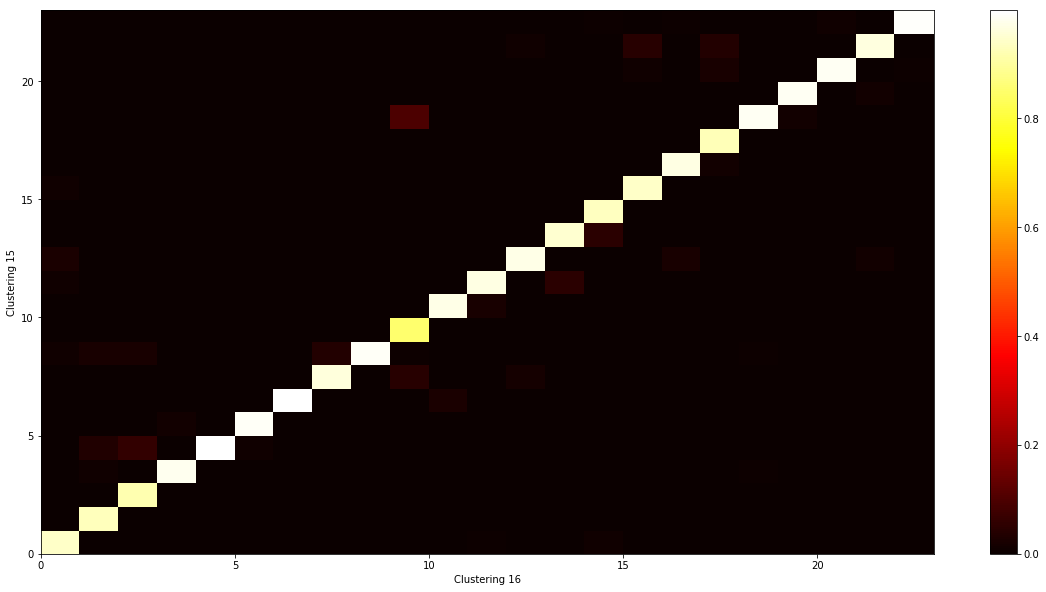

After


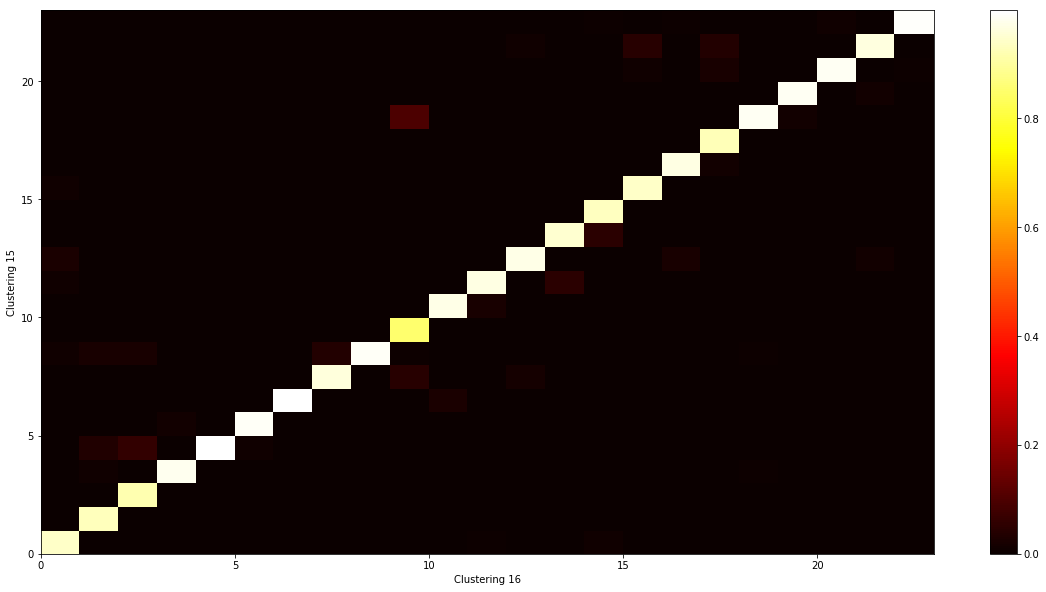

Before


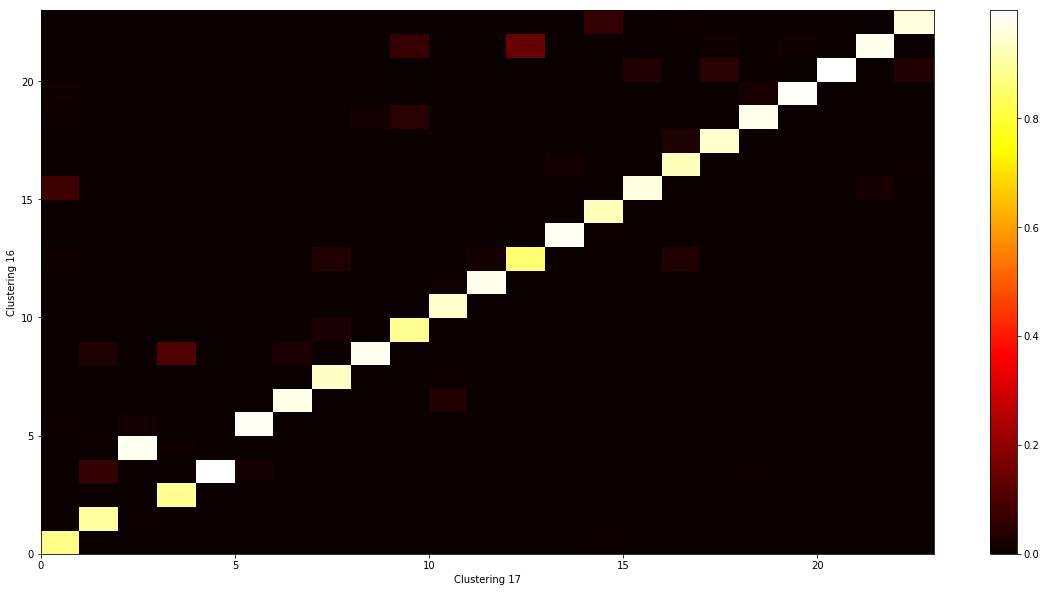

After


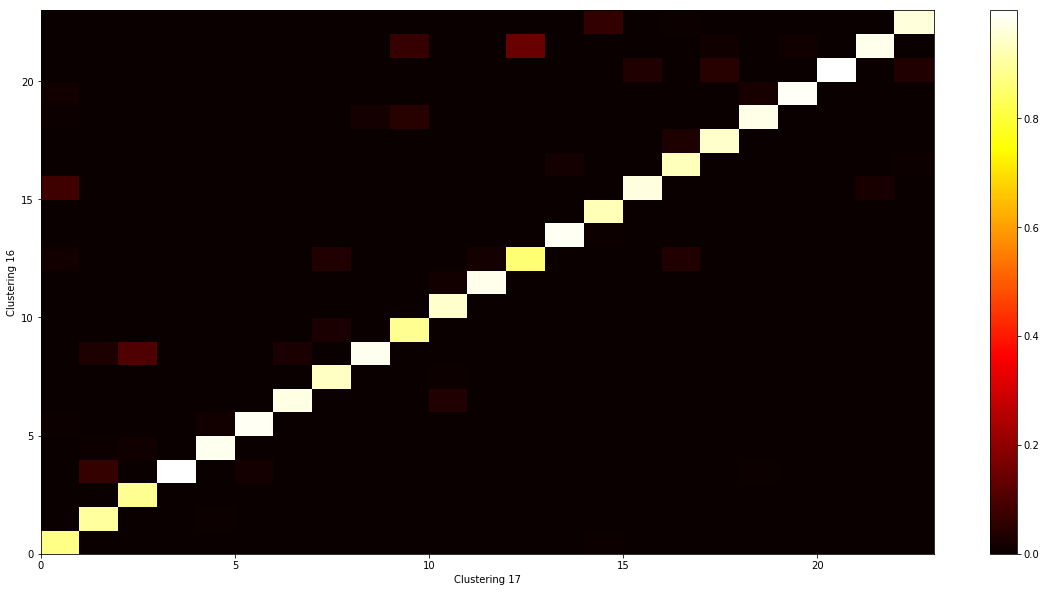

Before


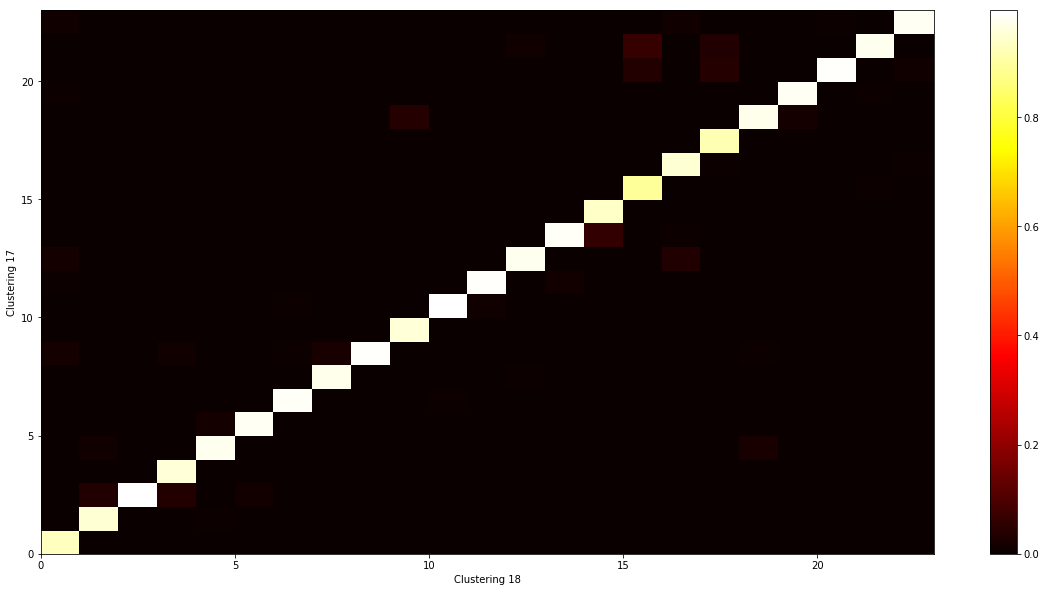

After


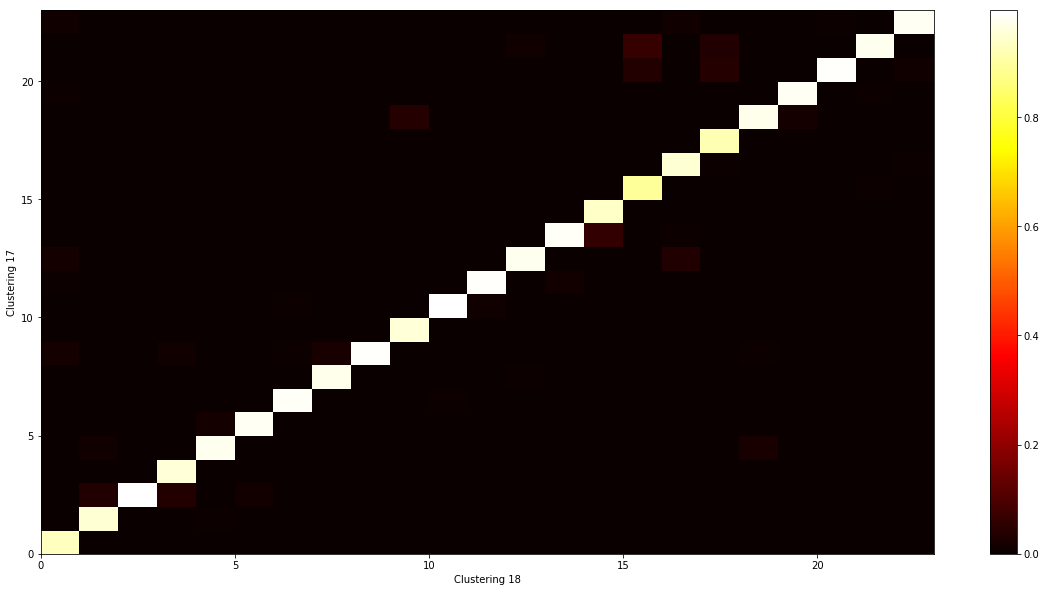

Before


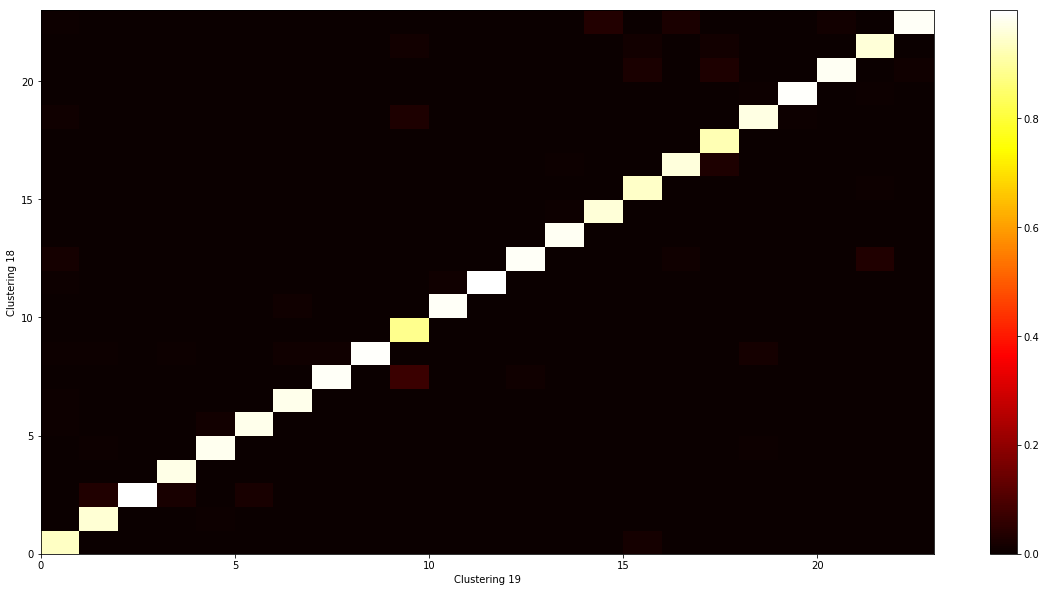

After


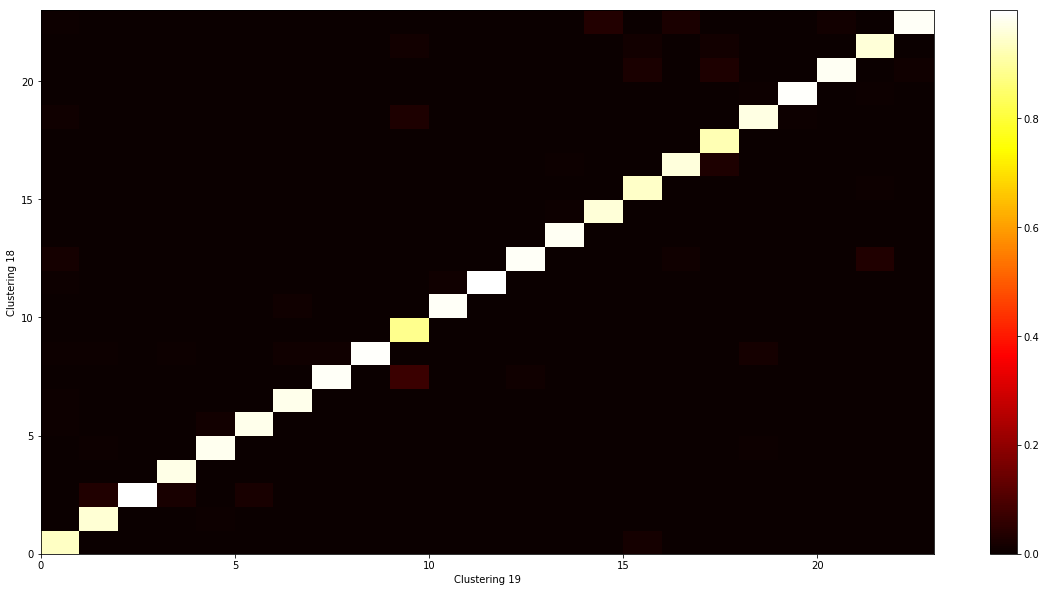

Before


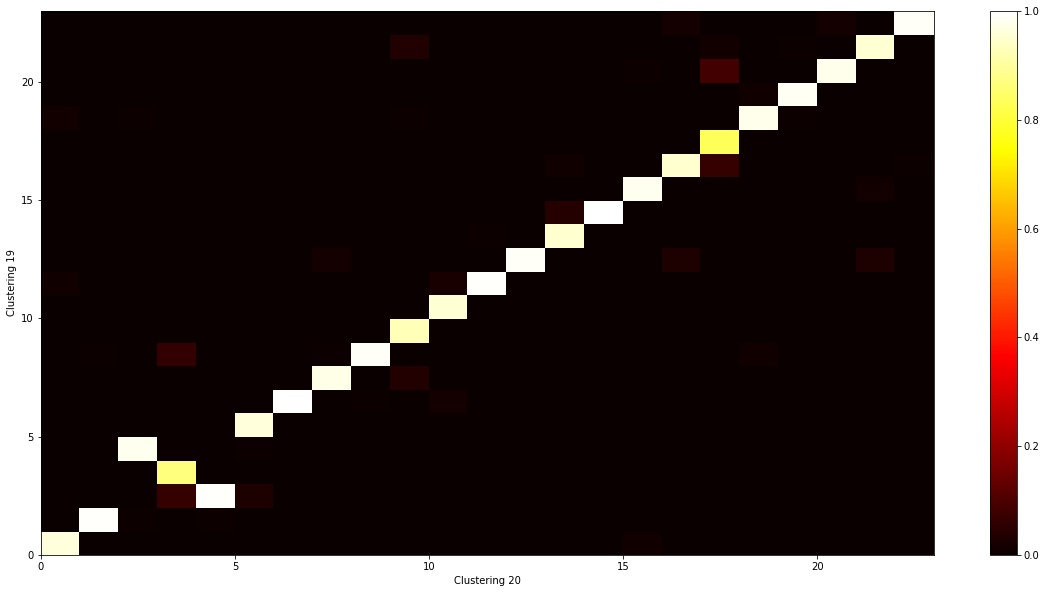

After


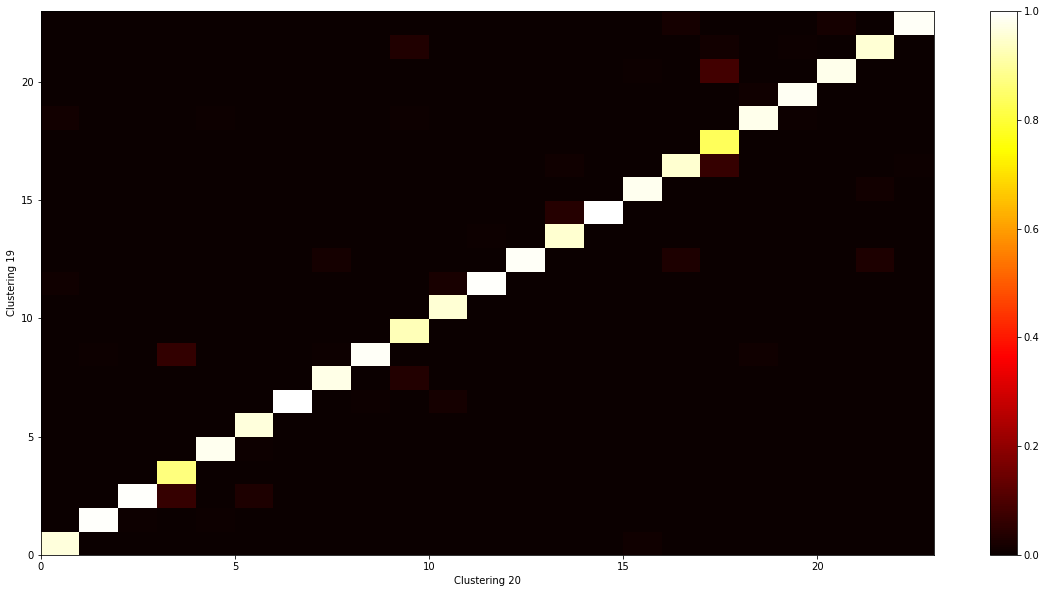

Before


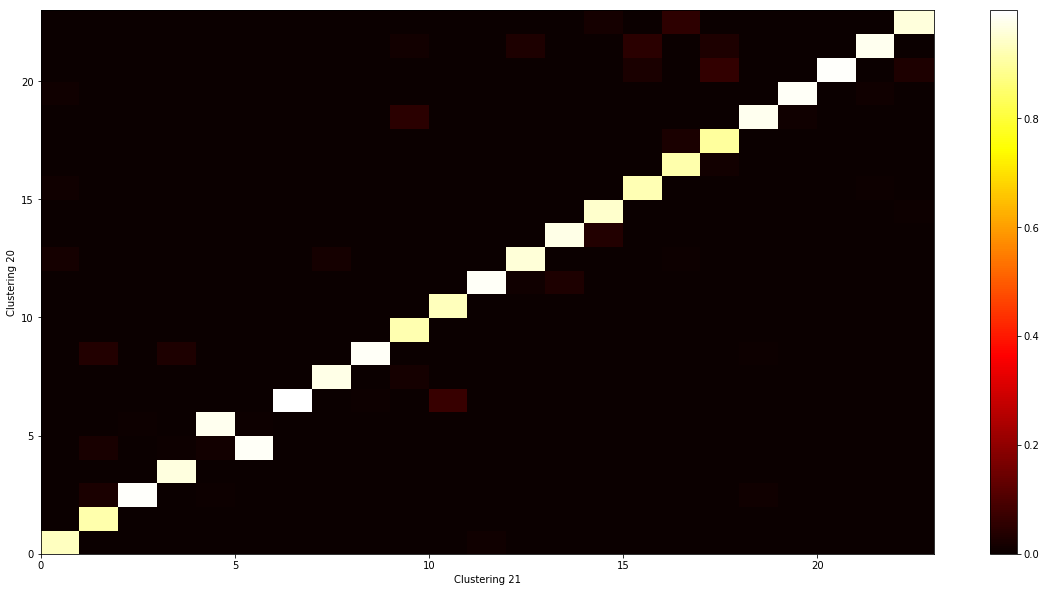

After


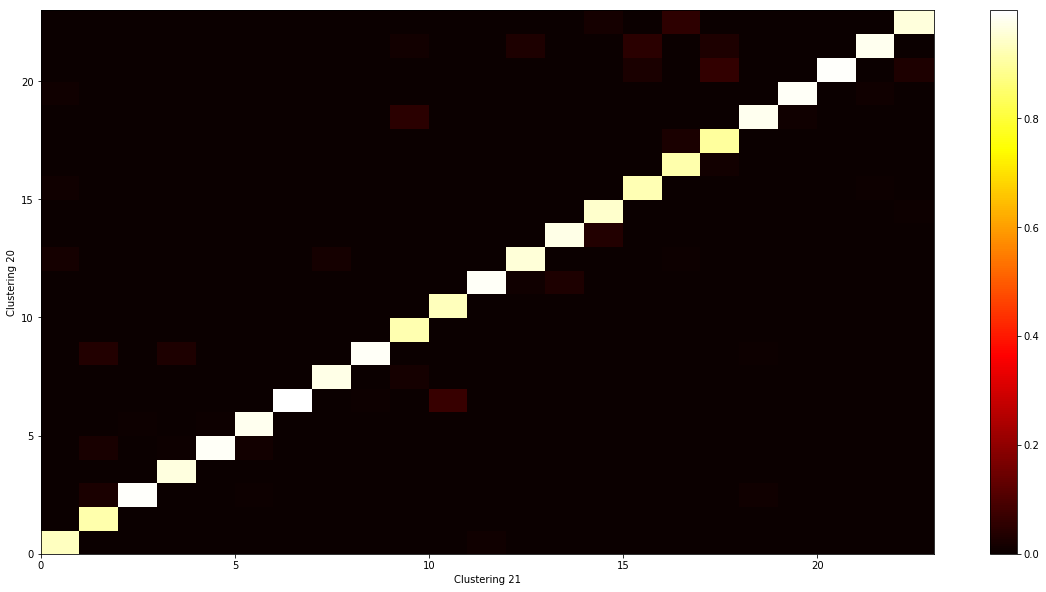

Before


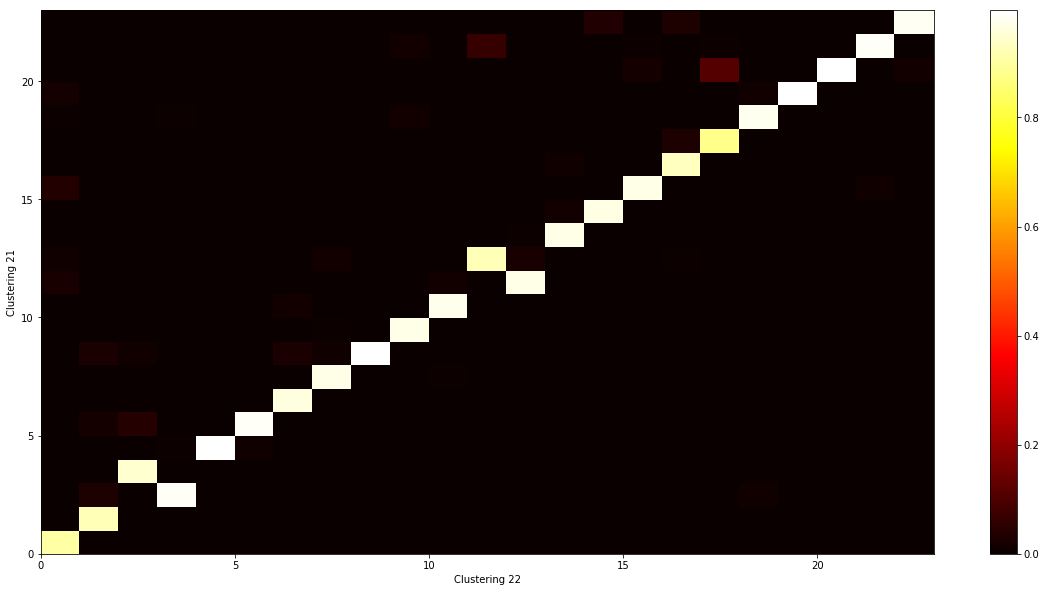

After


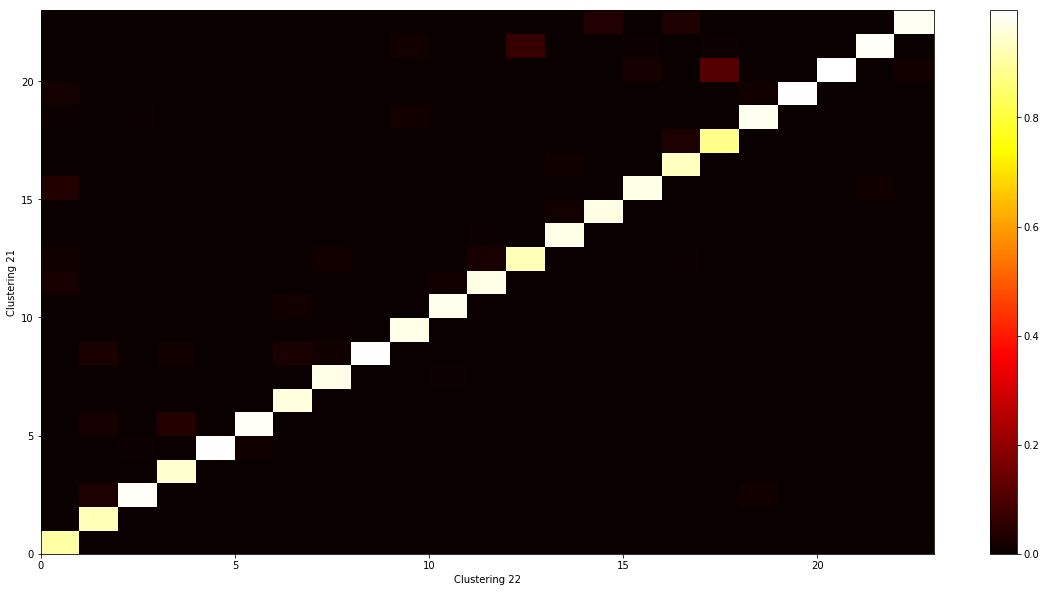

Before


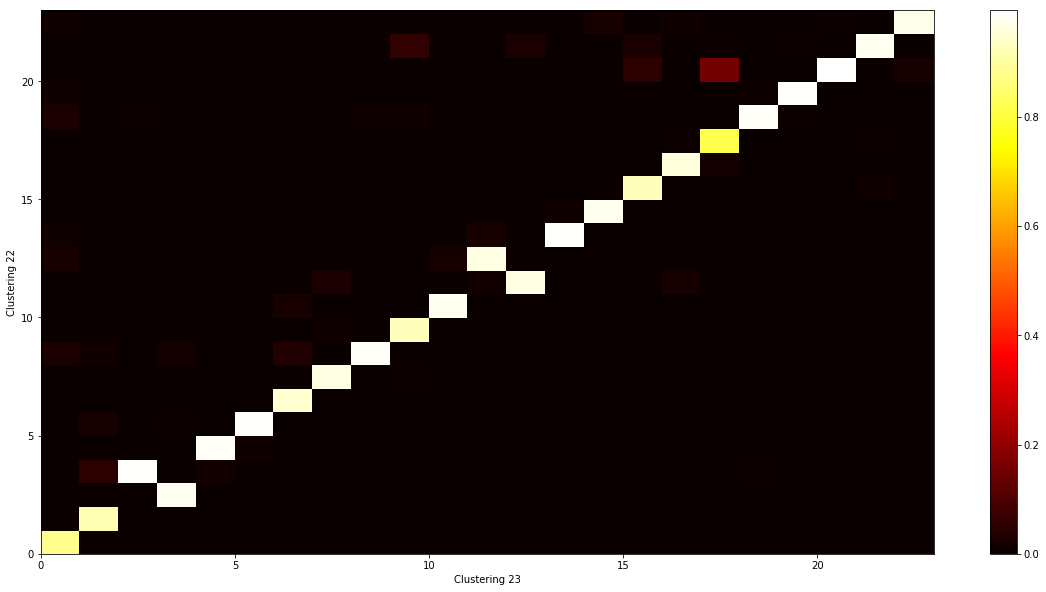

After


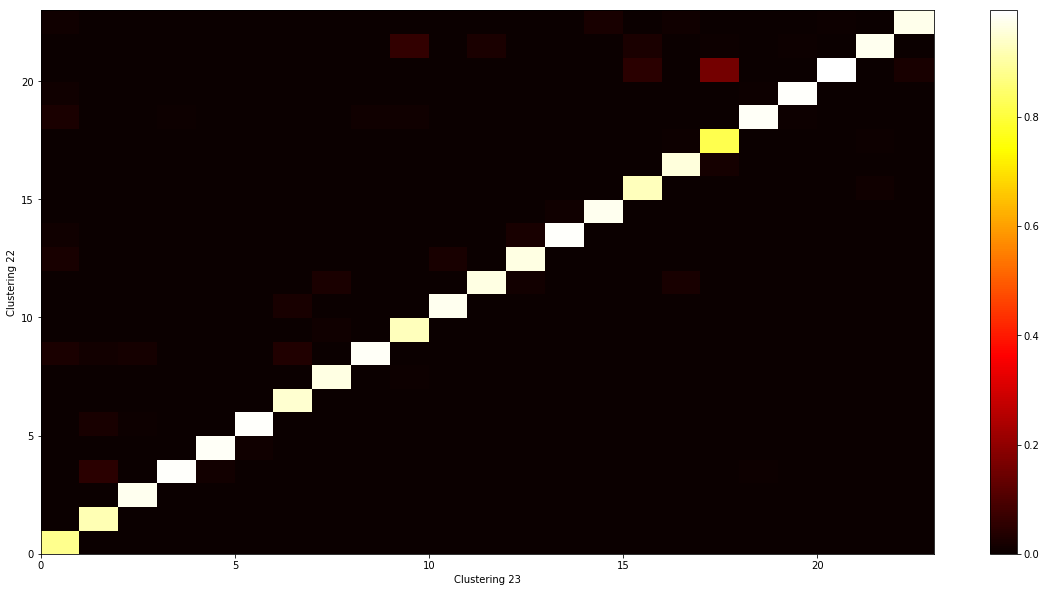

Before


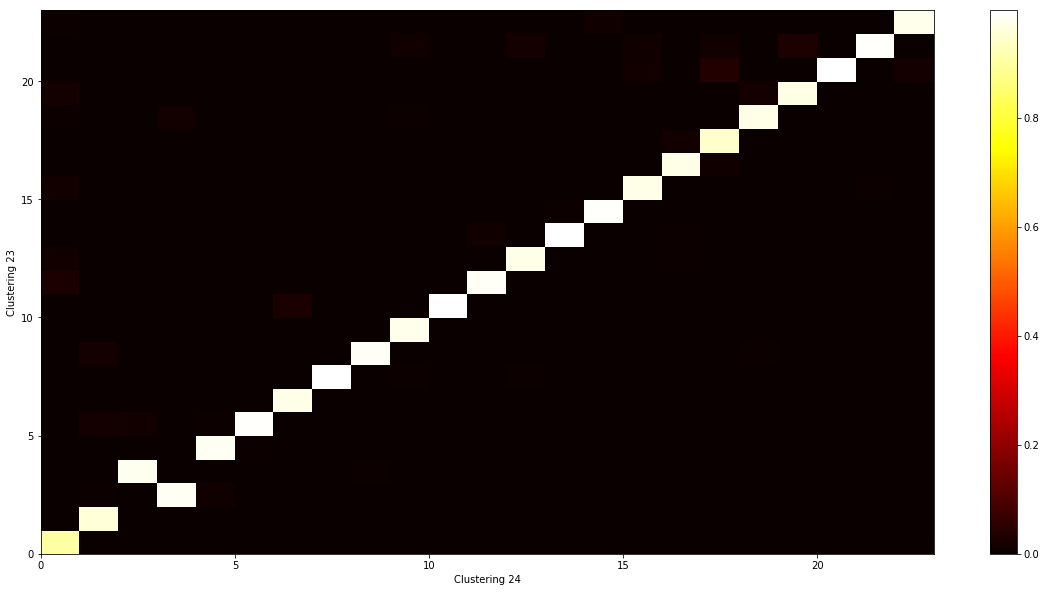

After


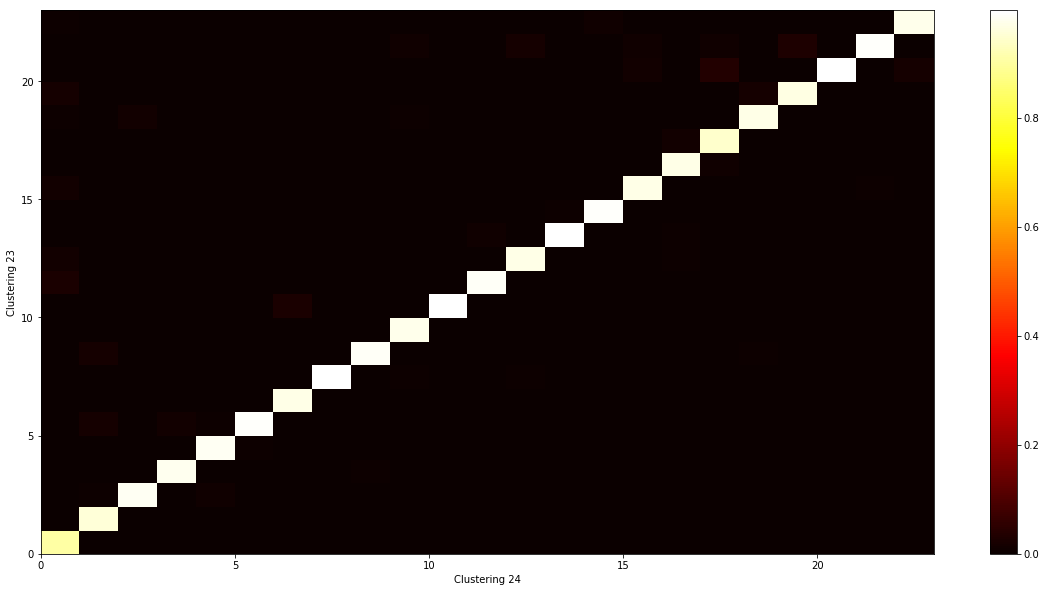

Before


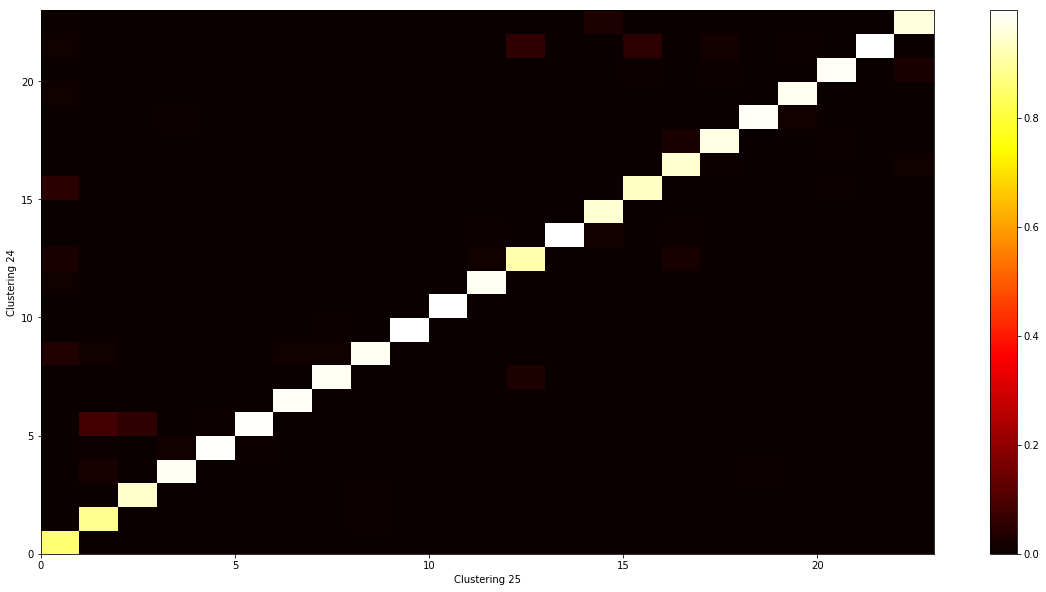

After


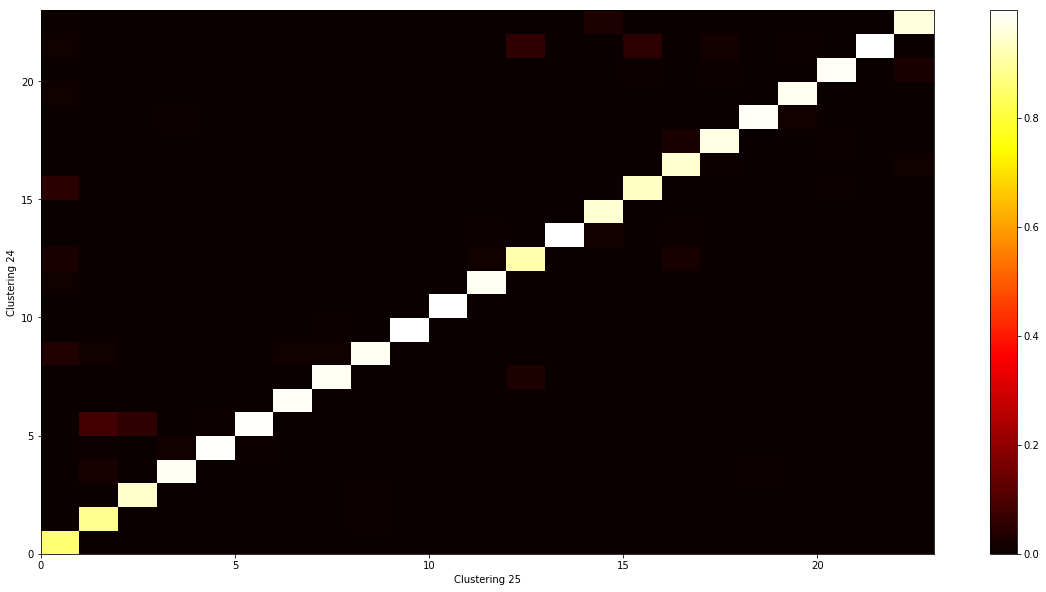

Before


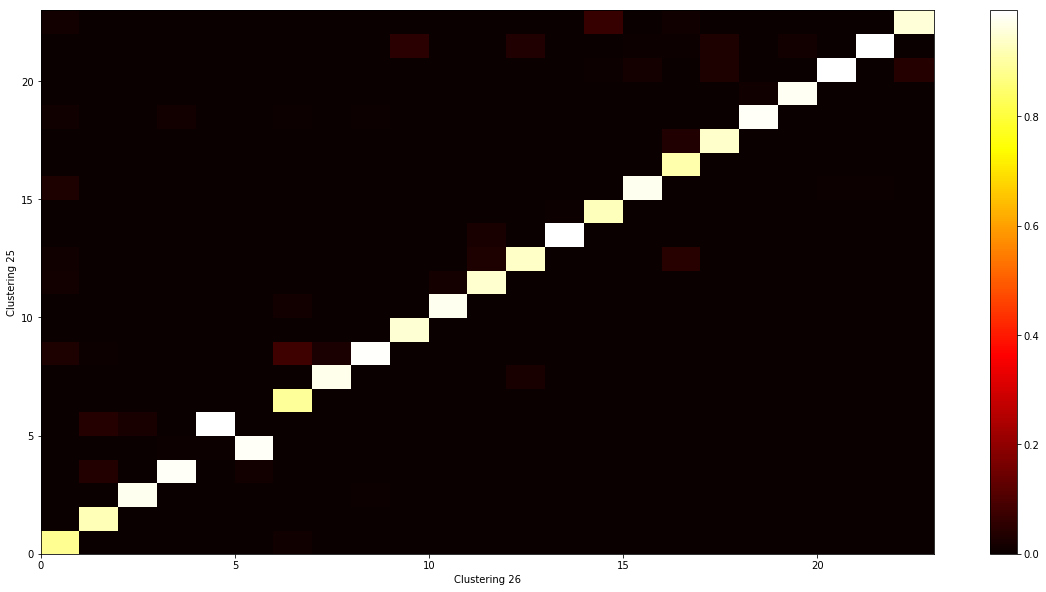

After


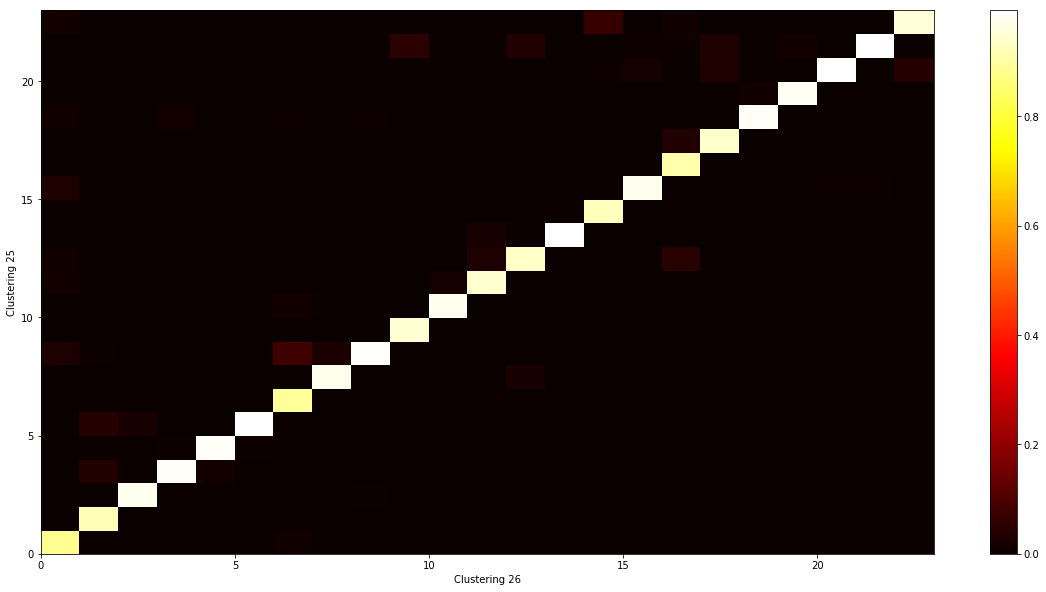

Before


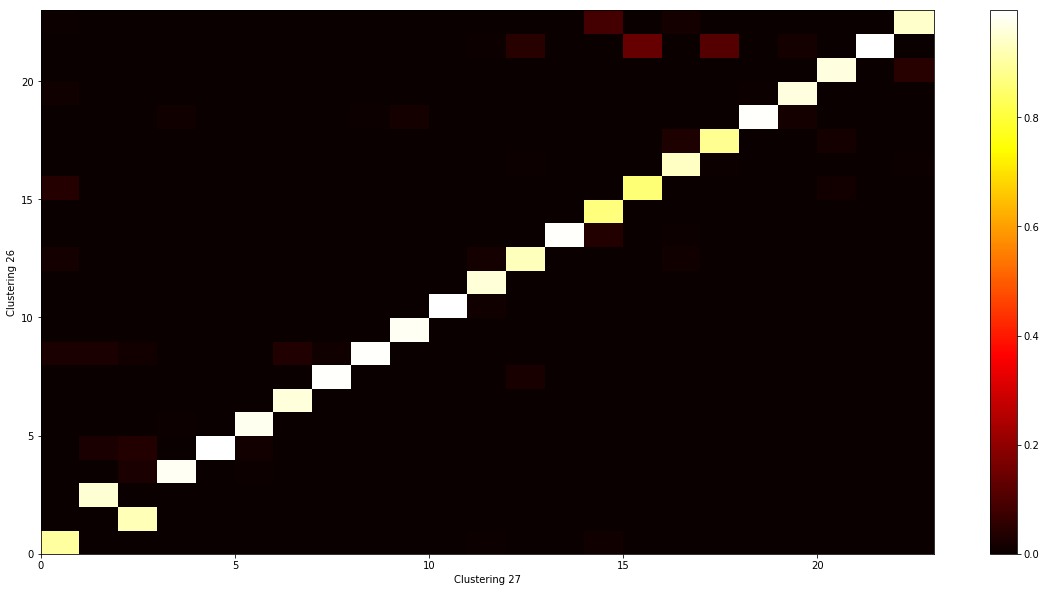

After


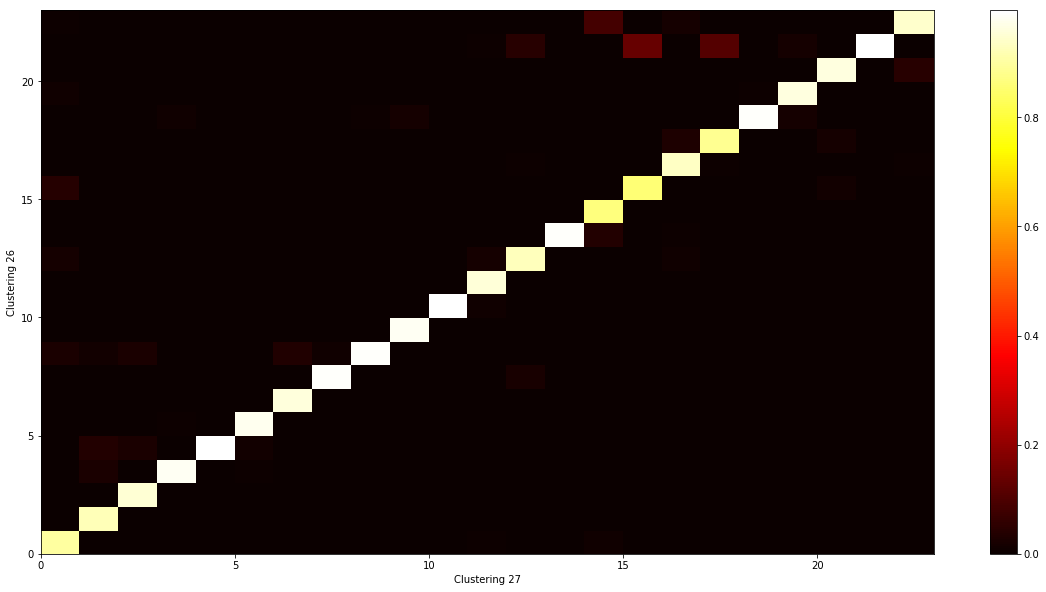

Before


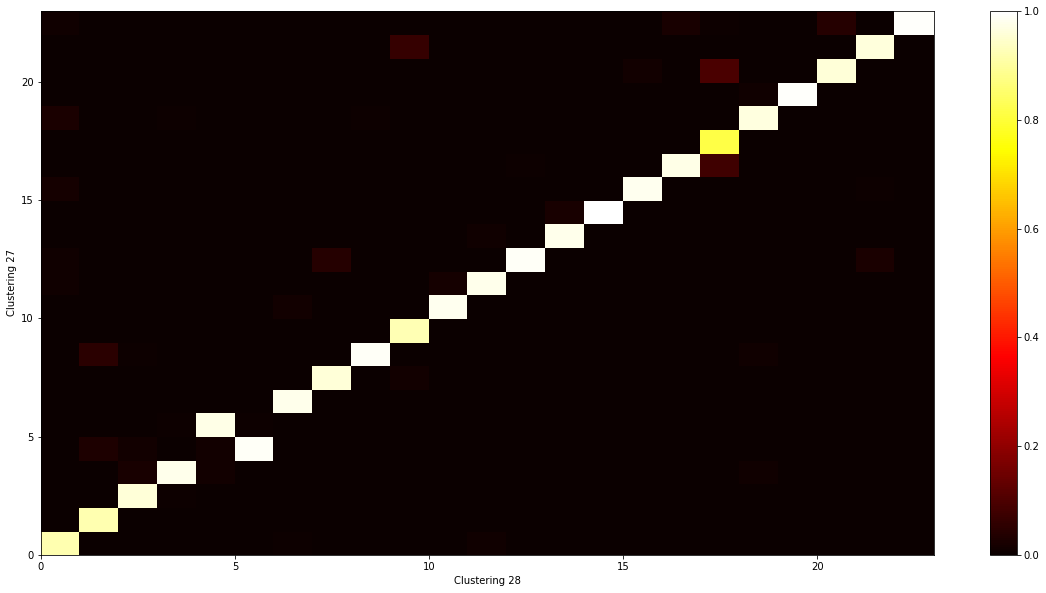

After


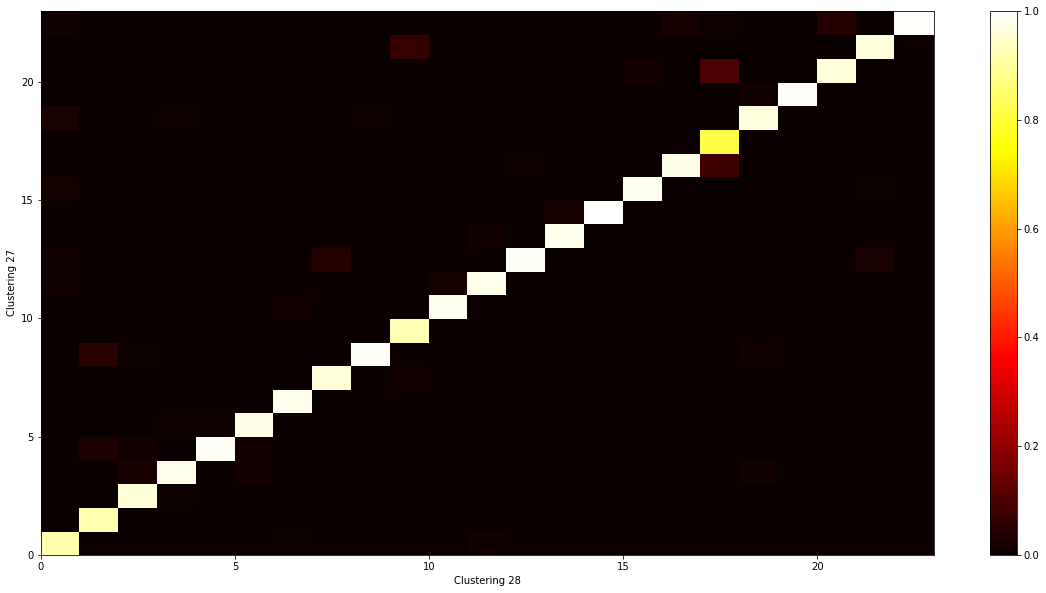

Before


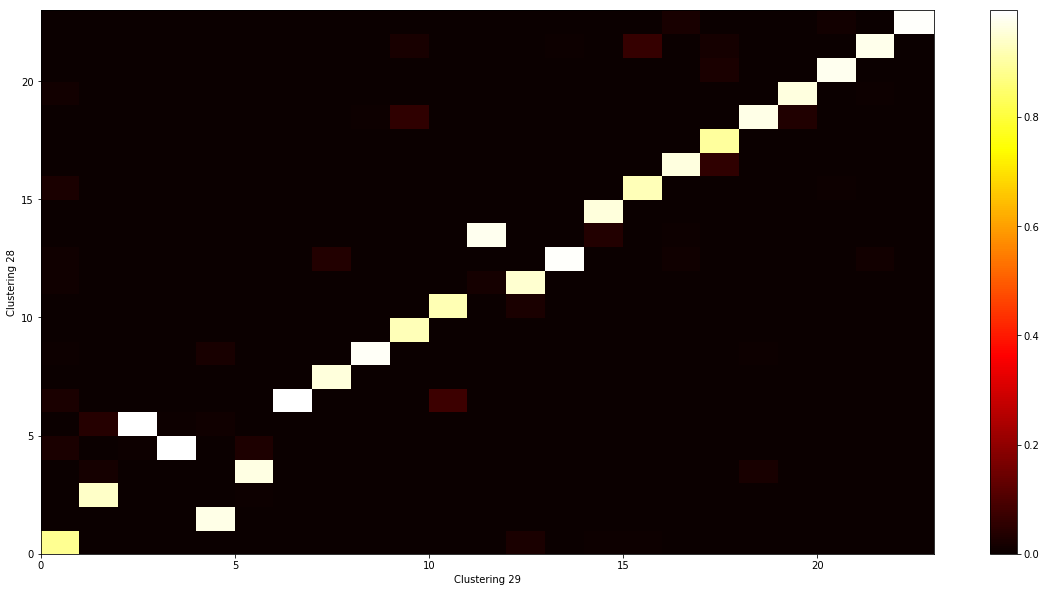

After


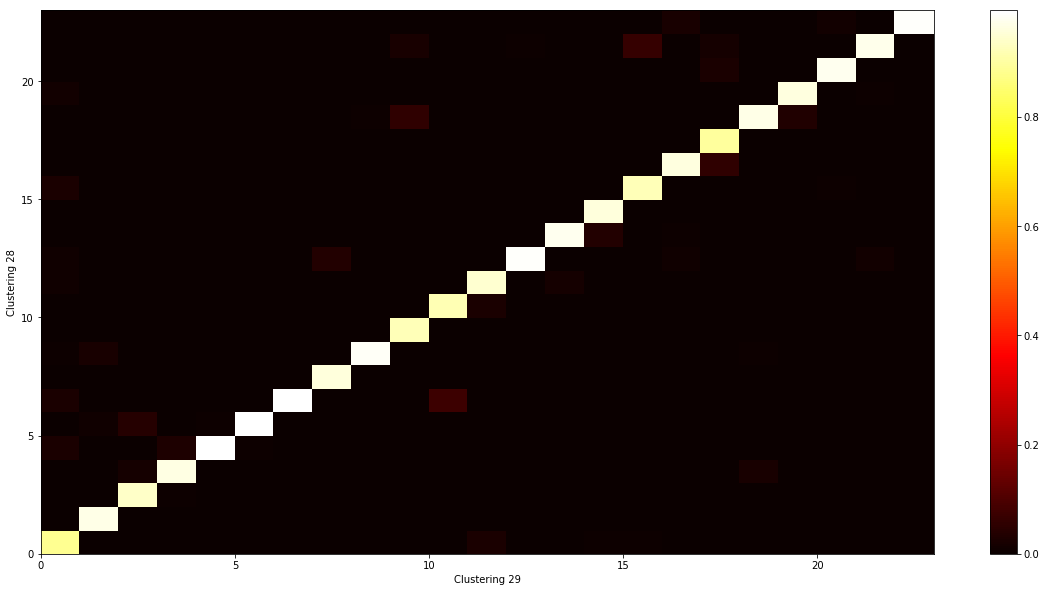

Before


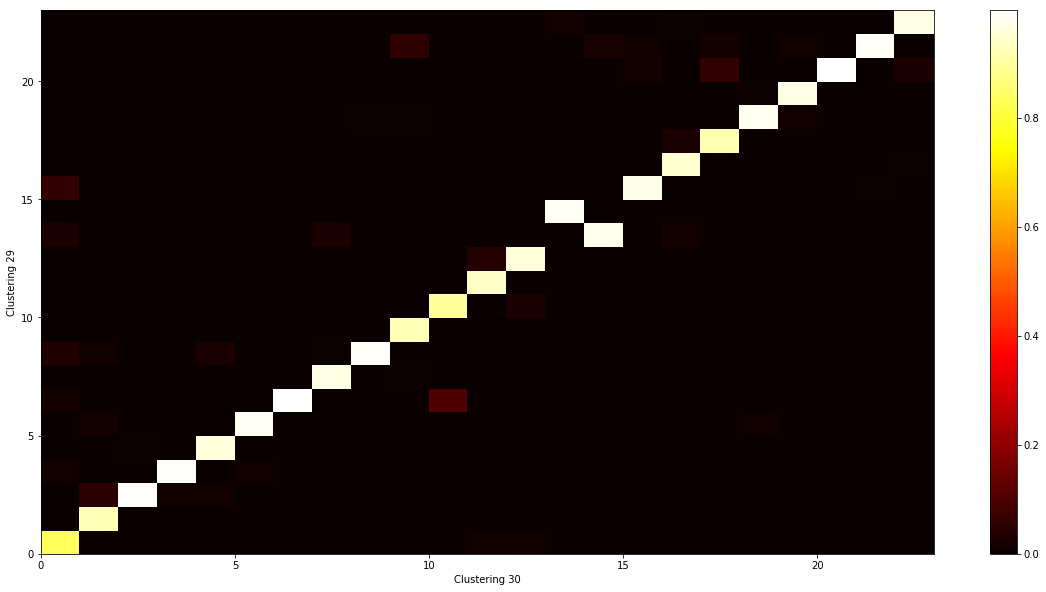

After


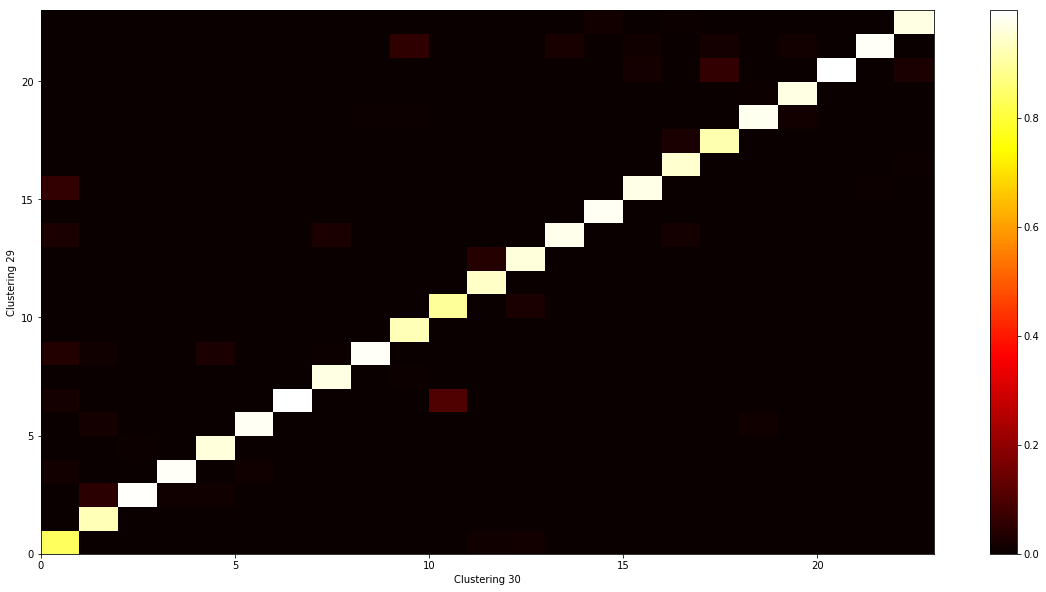

Before


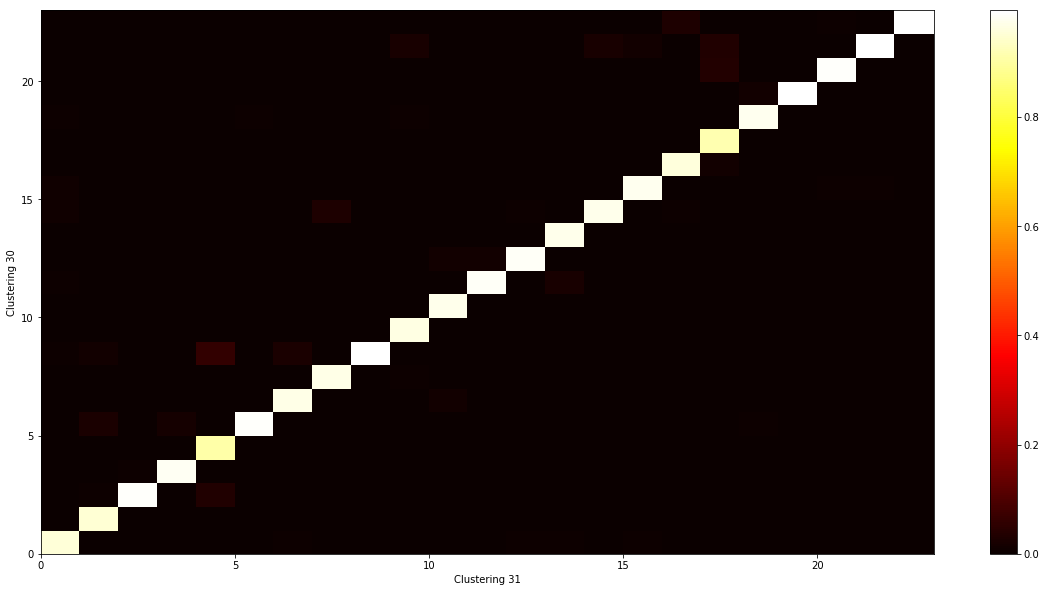

After


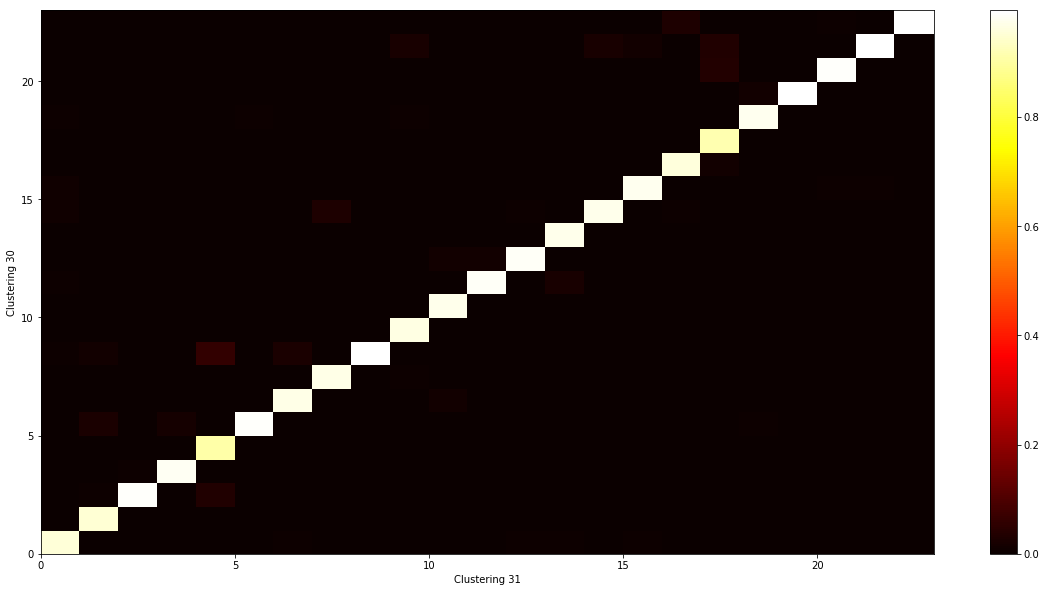

Before


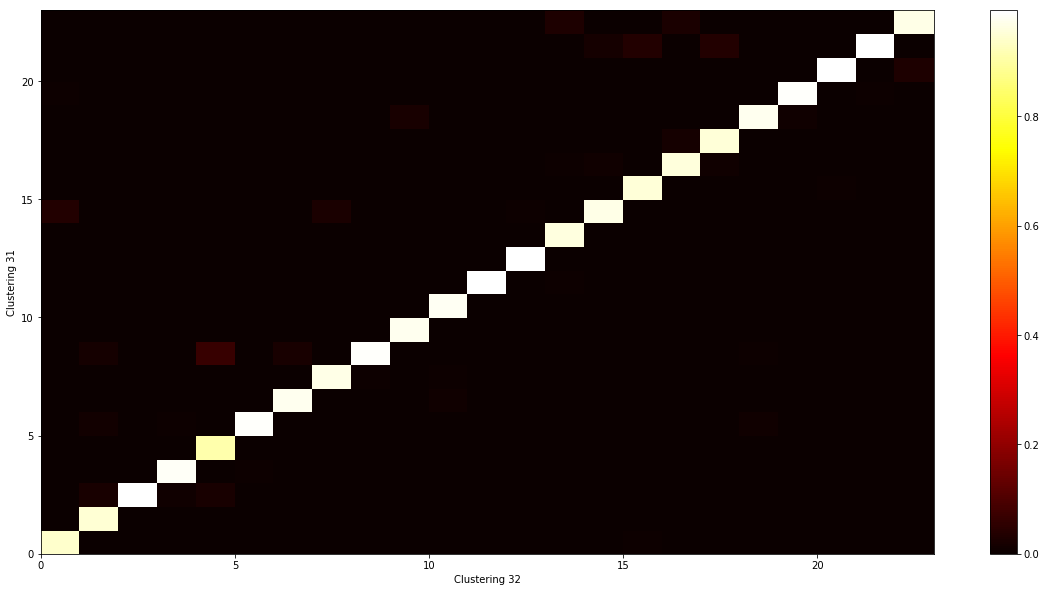

After


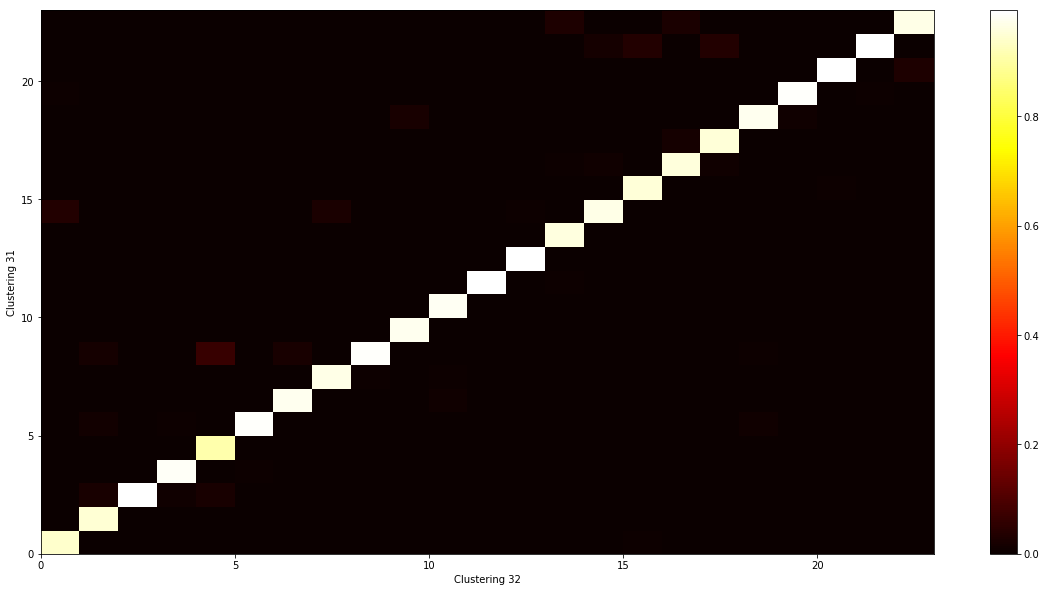

Before


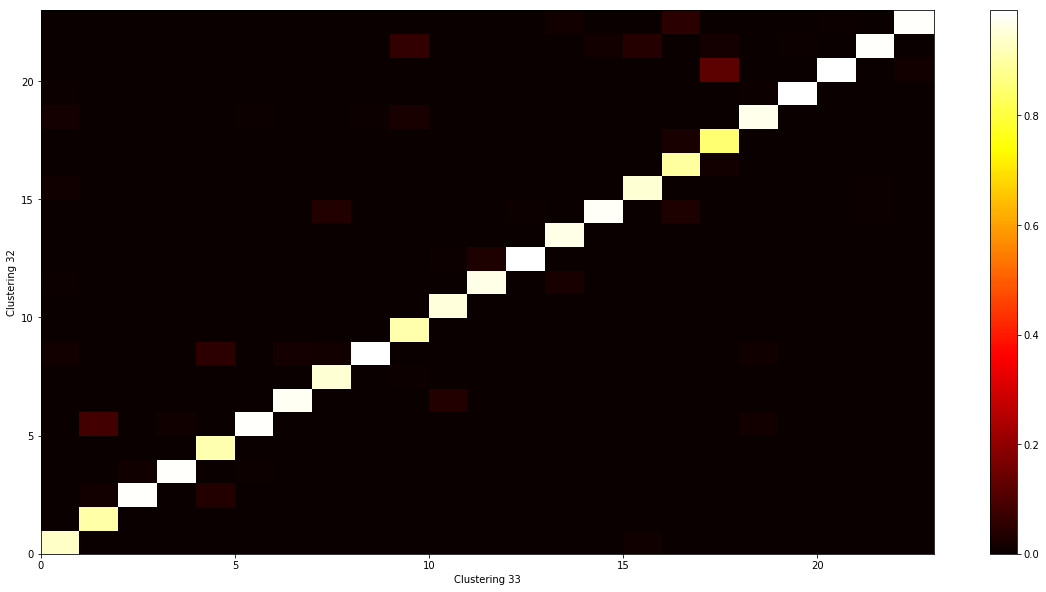

After


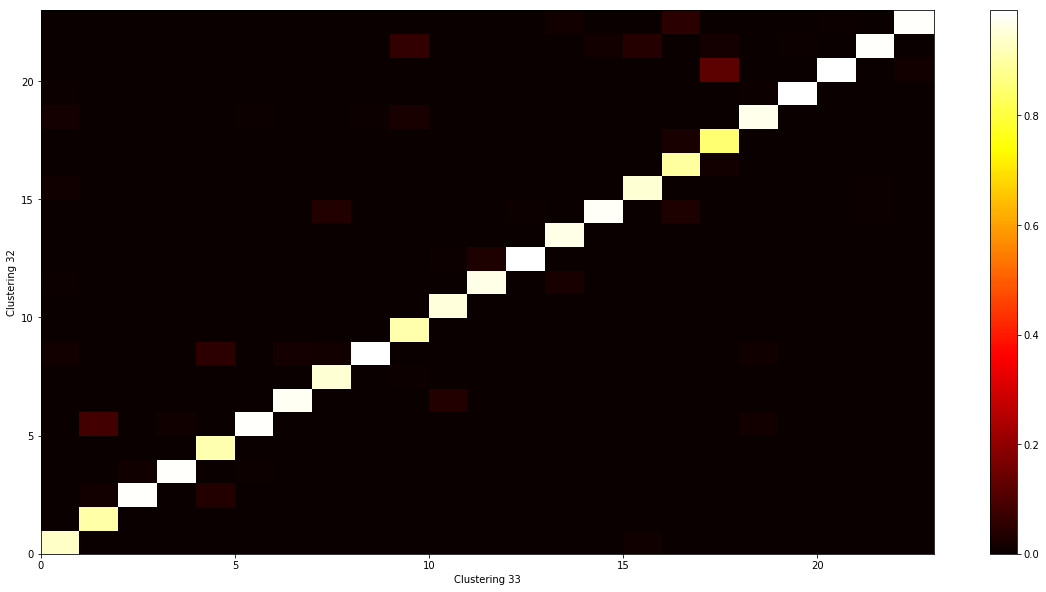

Before


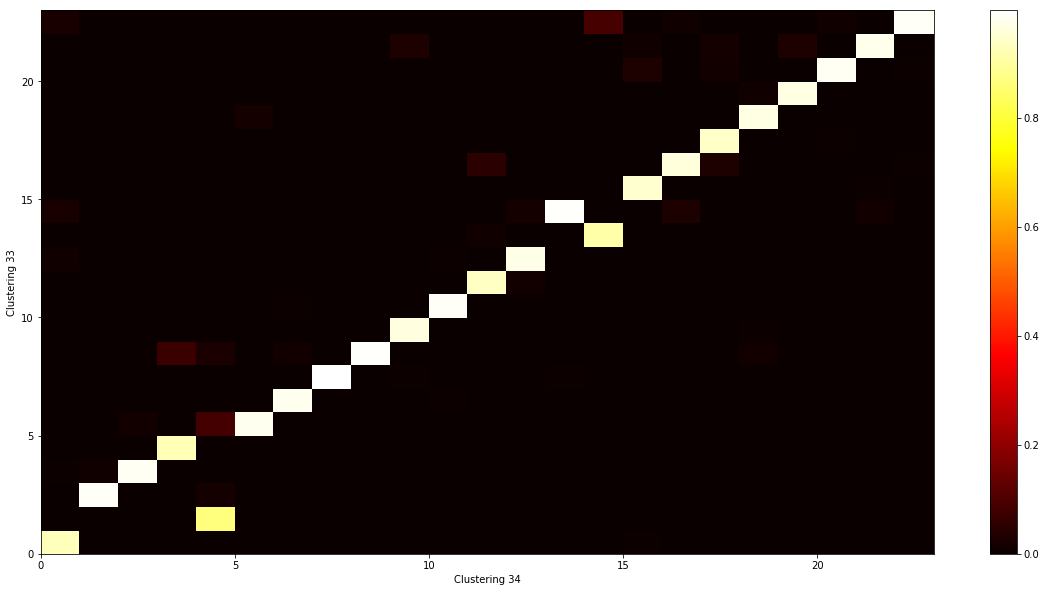

After


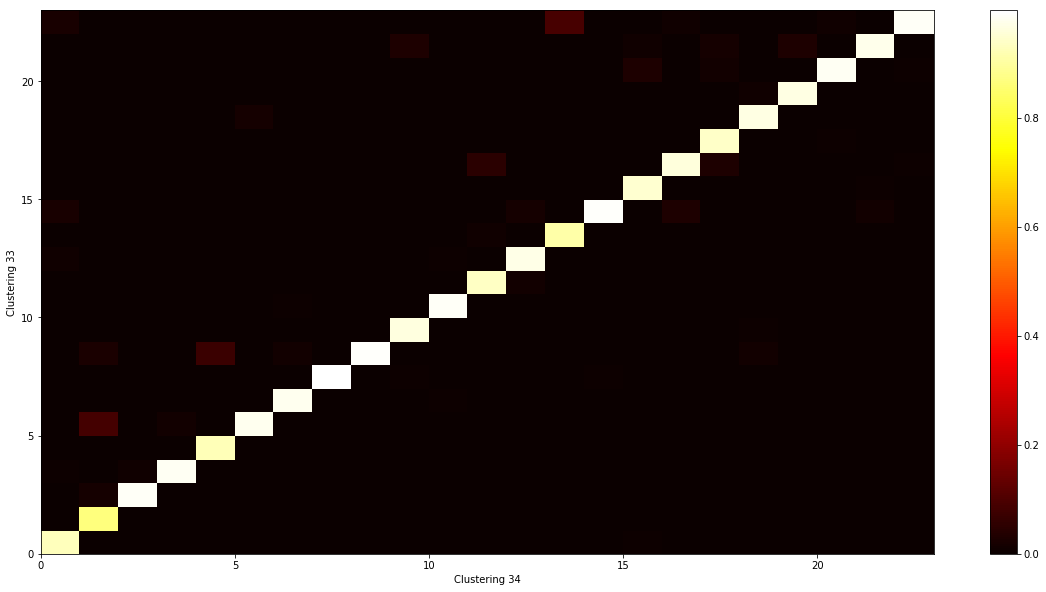

Before


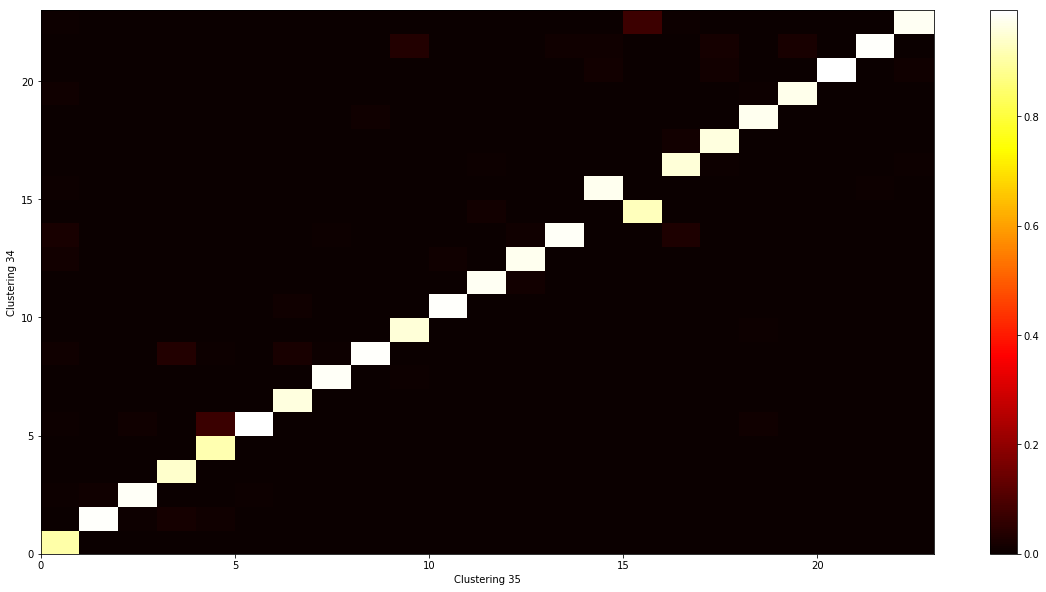

After


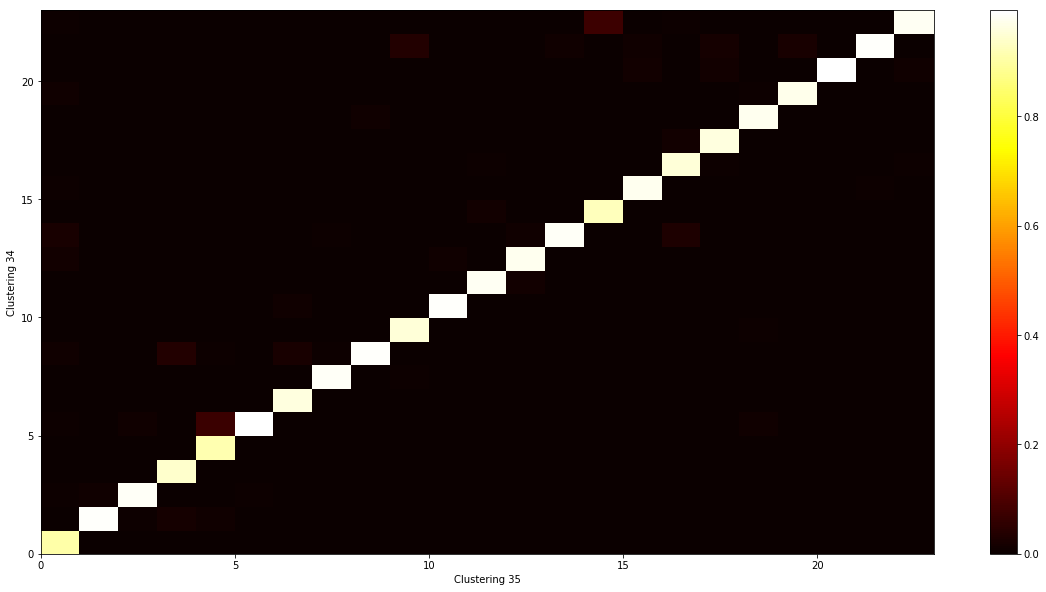

Before


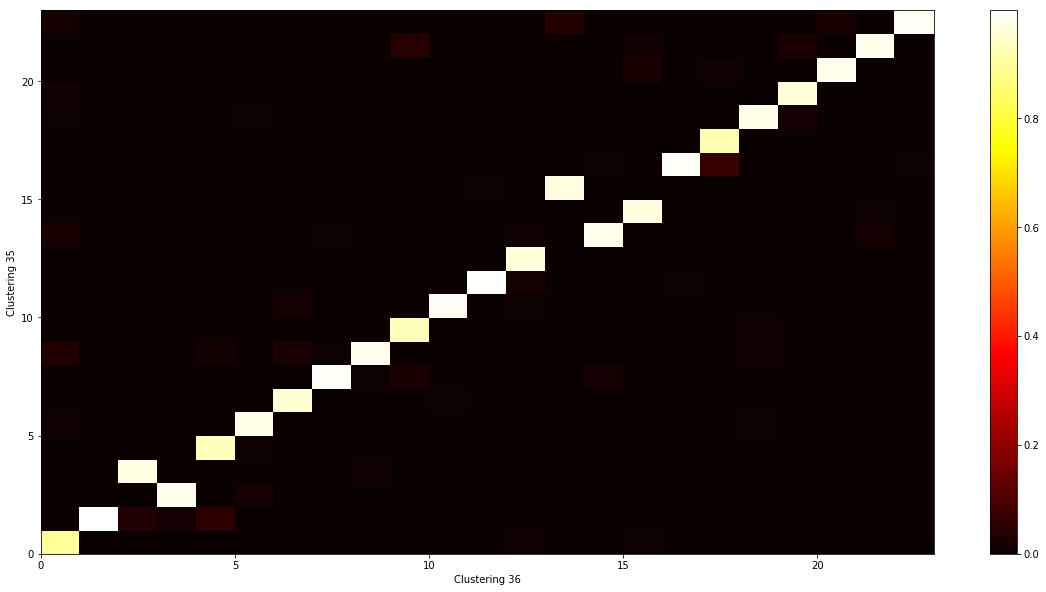

After


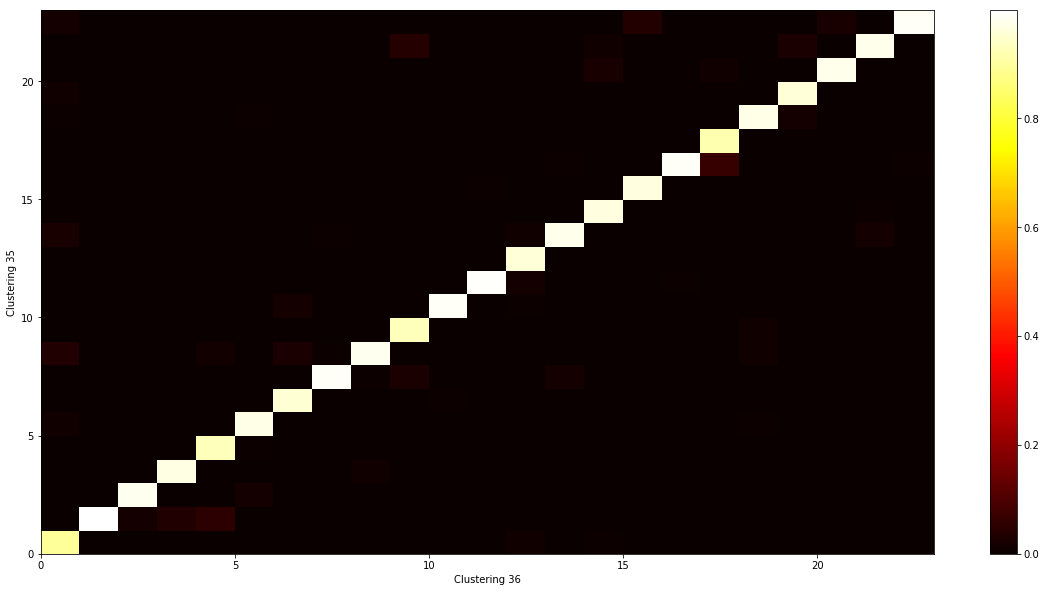

Before


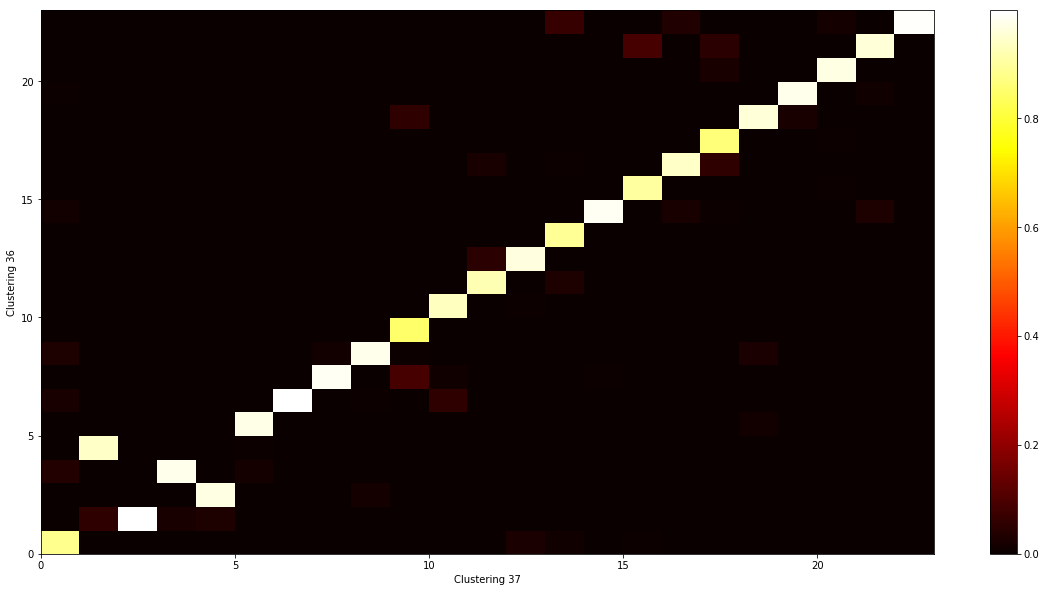

After


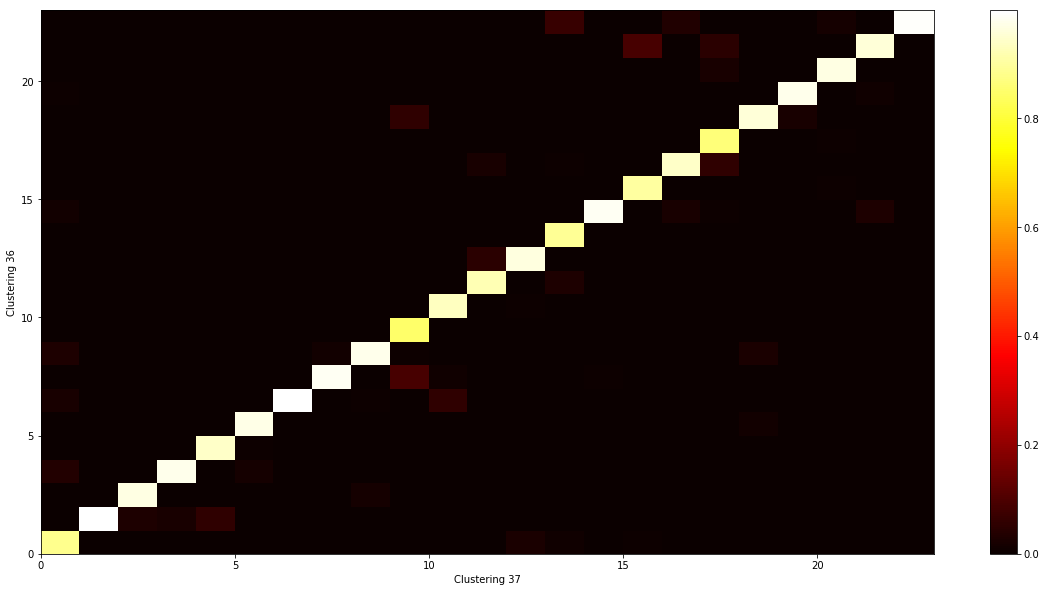

Before


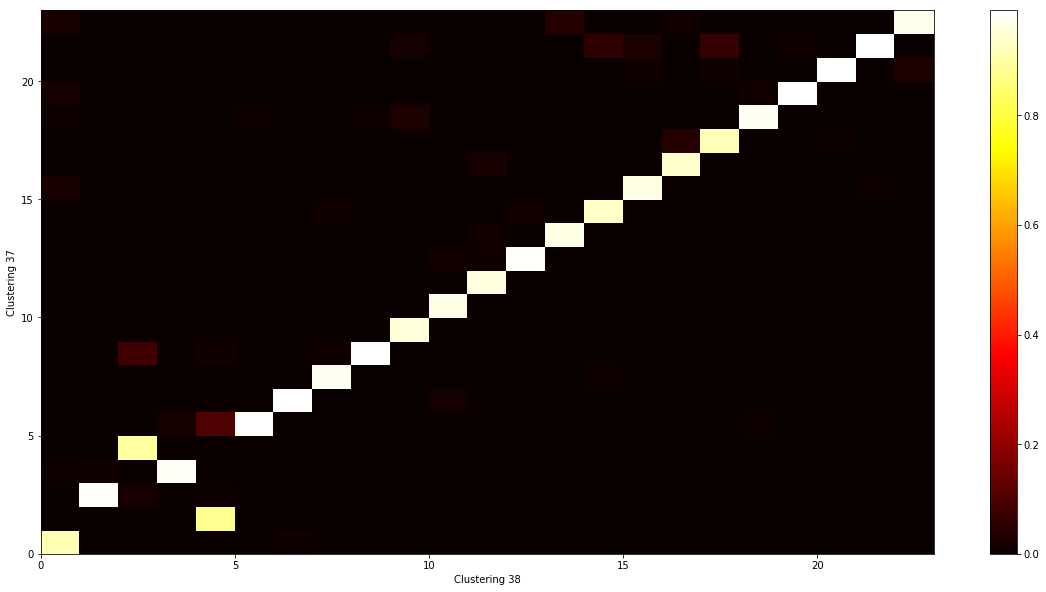

After


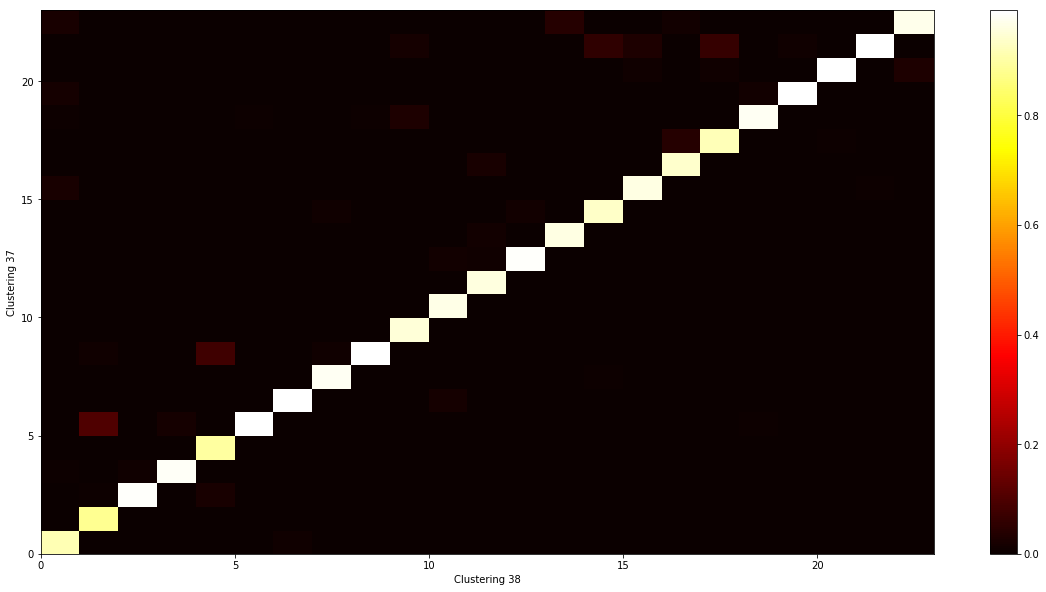

Before


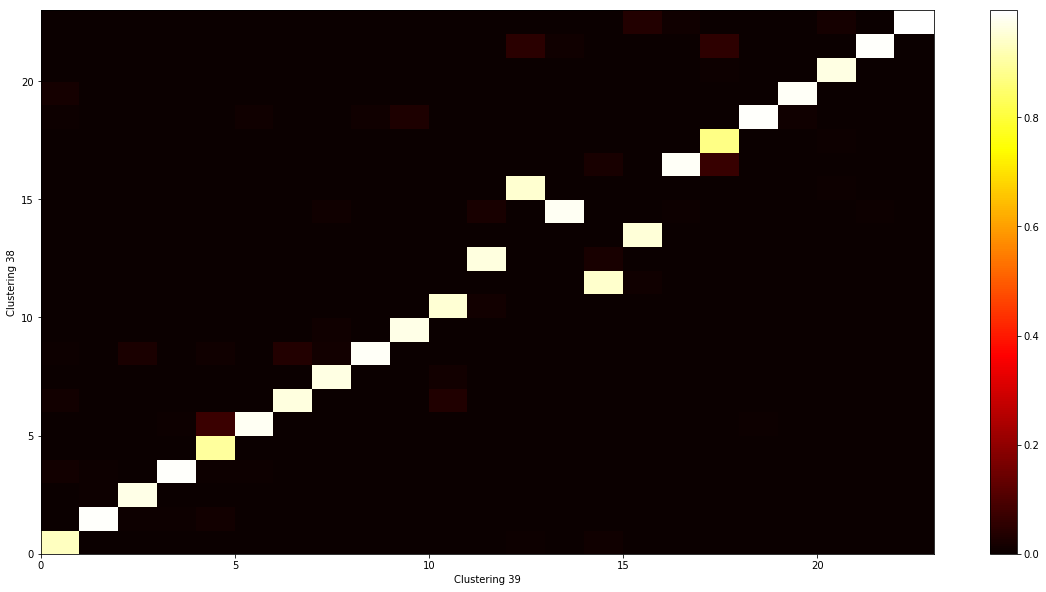

After


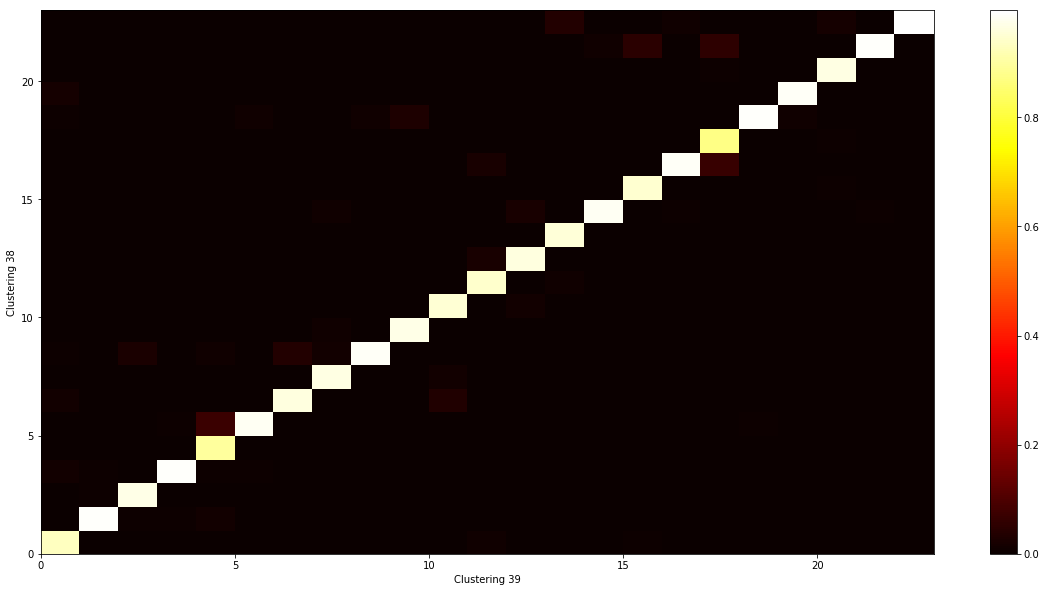

Before


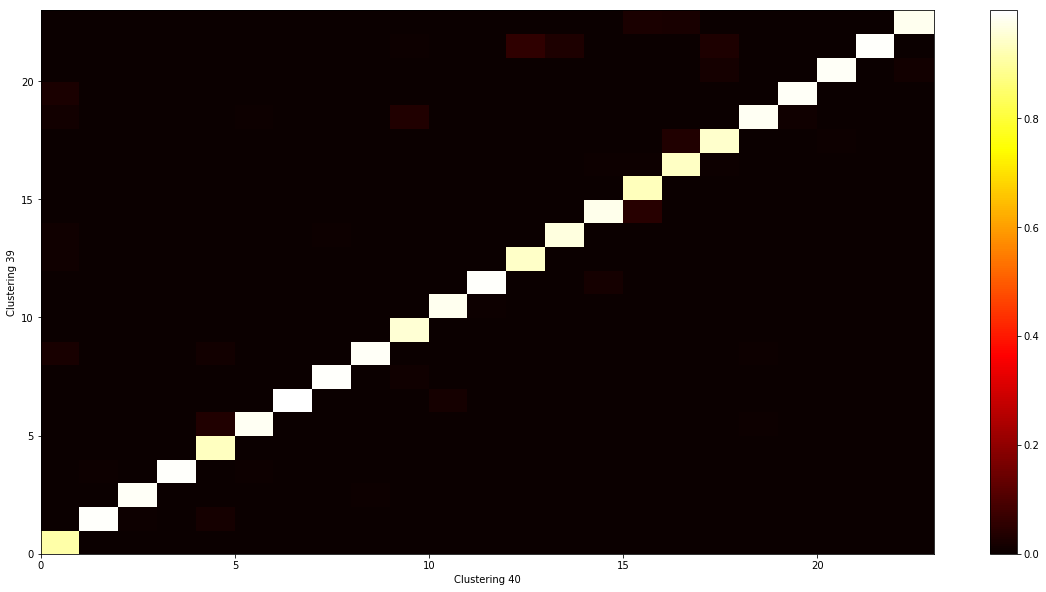

After


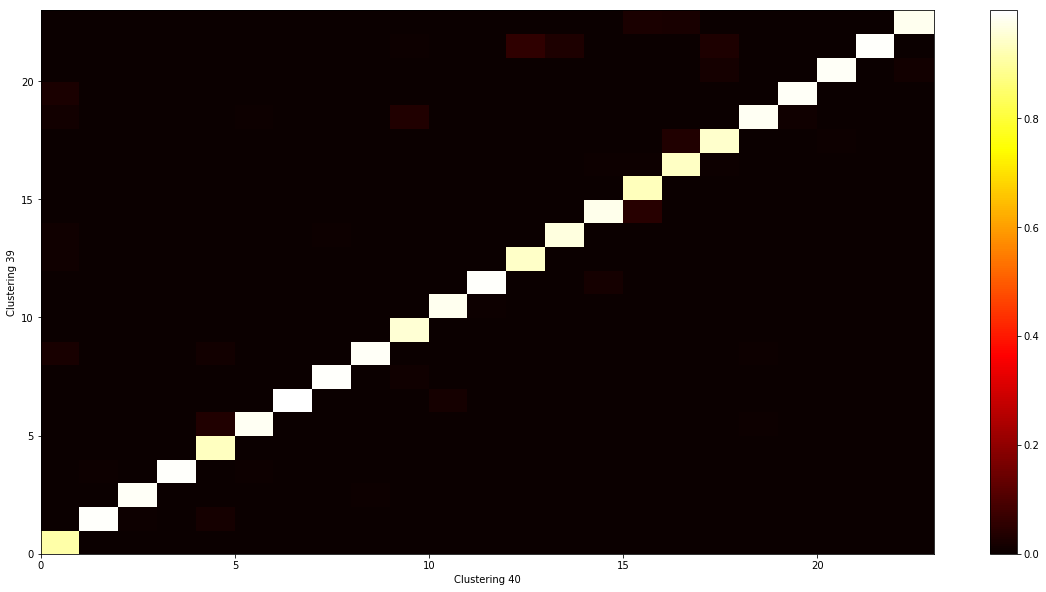

Before


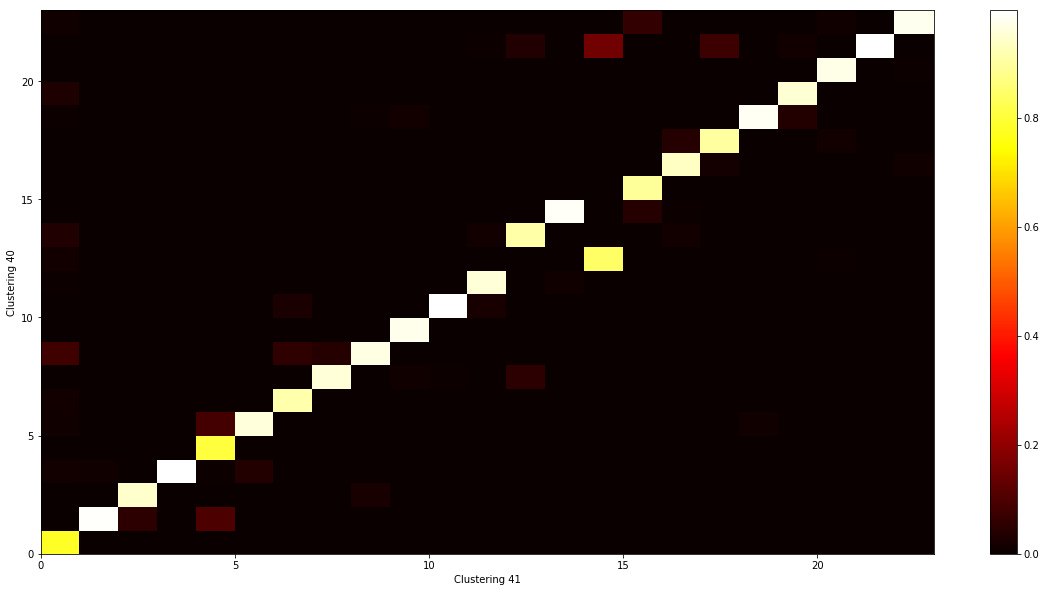

After


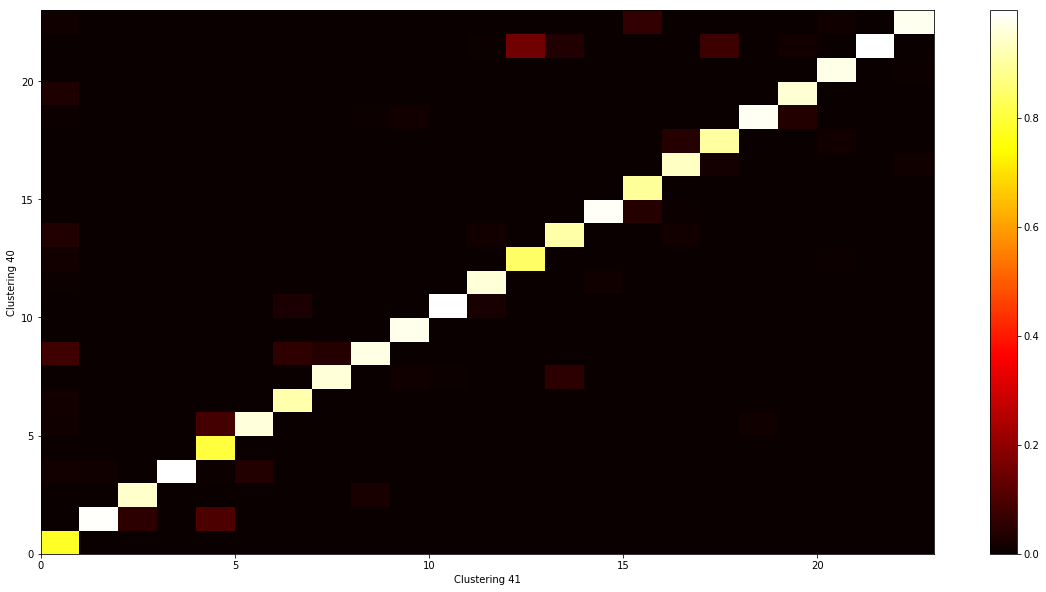

Before


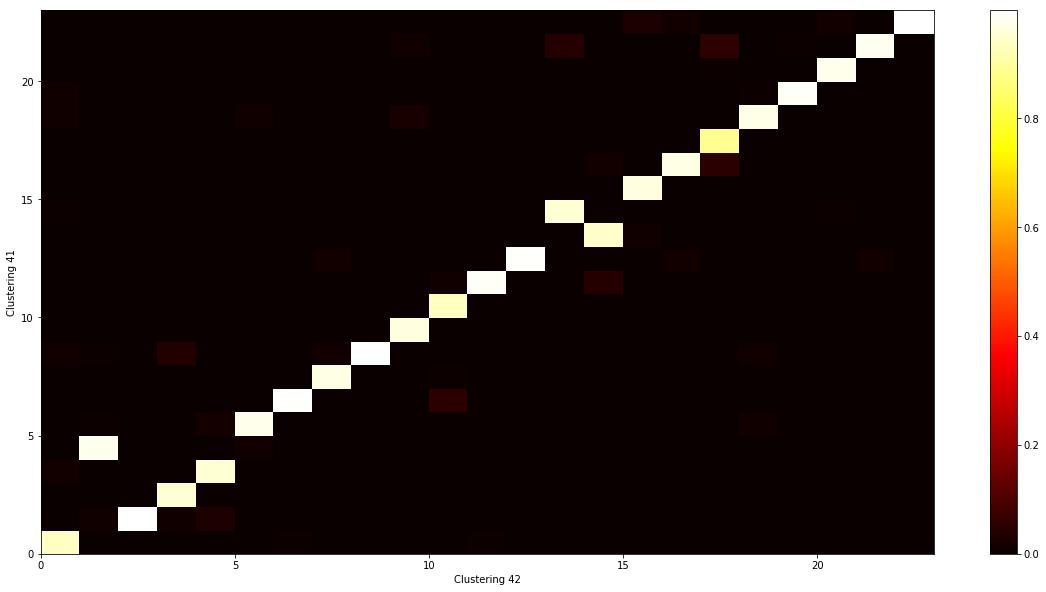

After


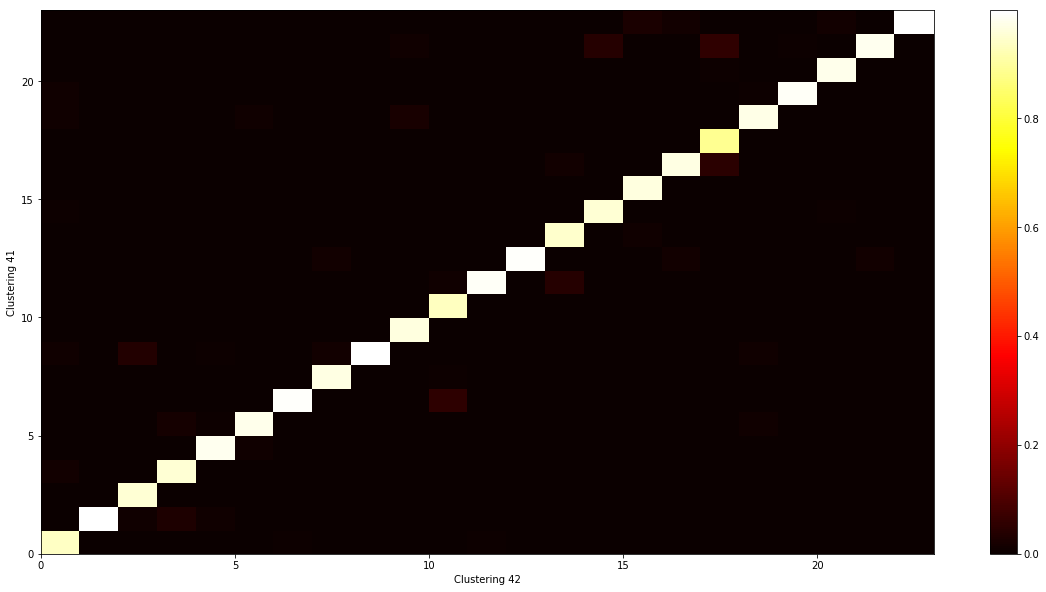

Before


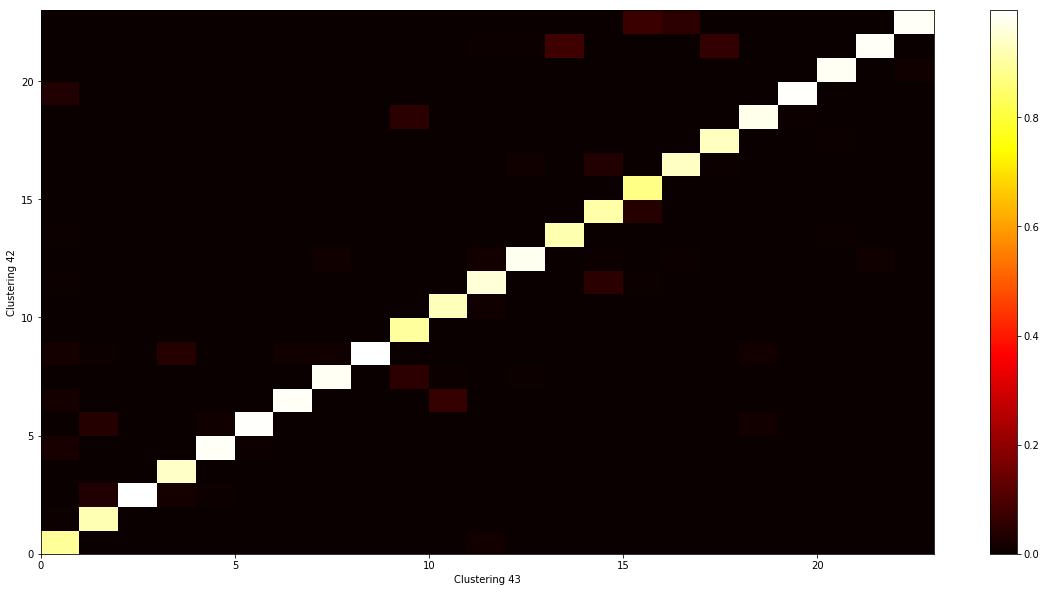

After


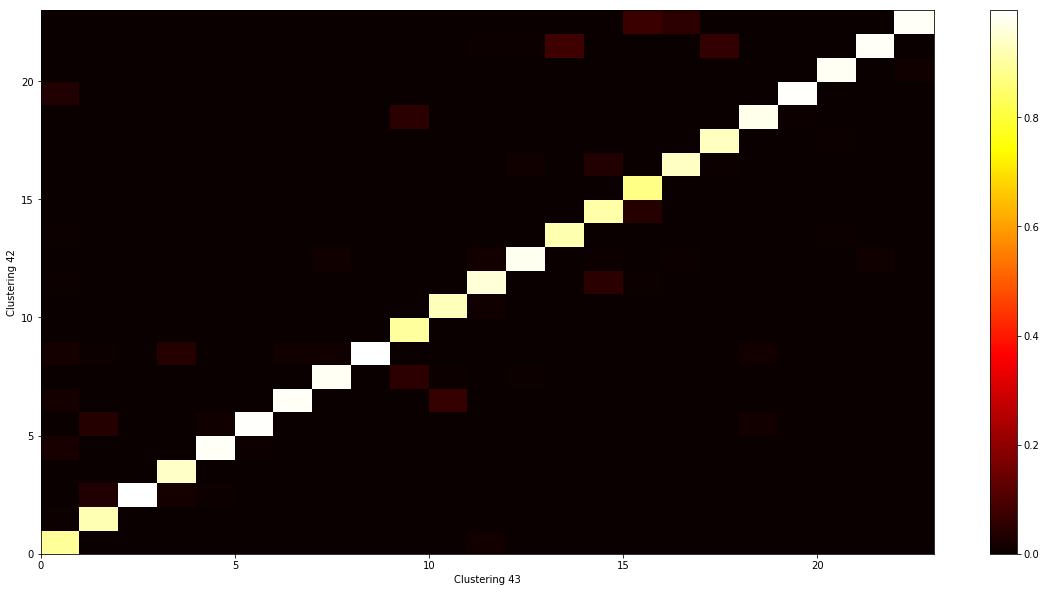

Before


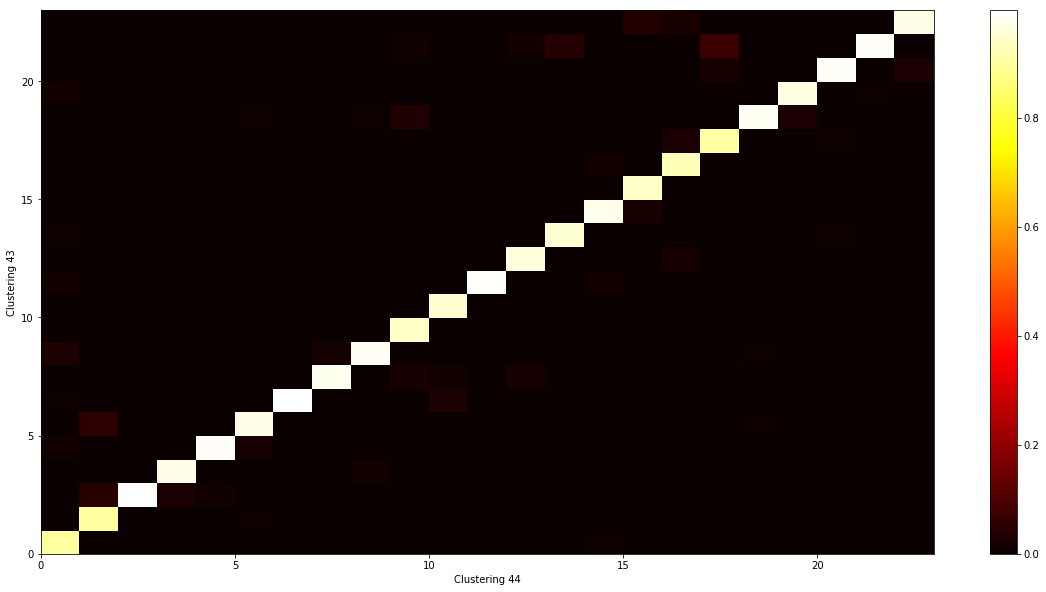

After


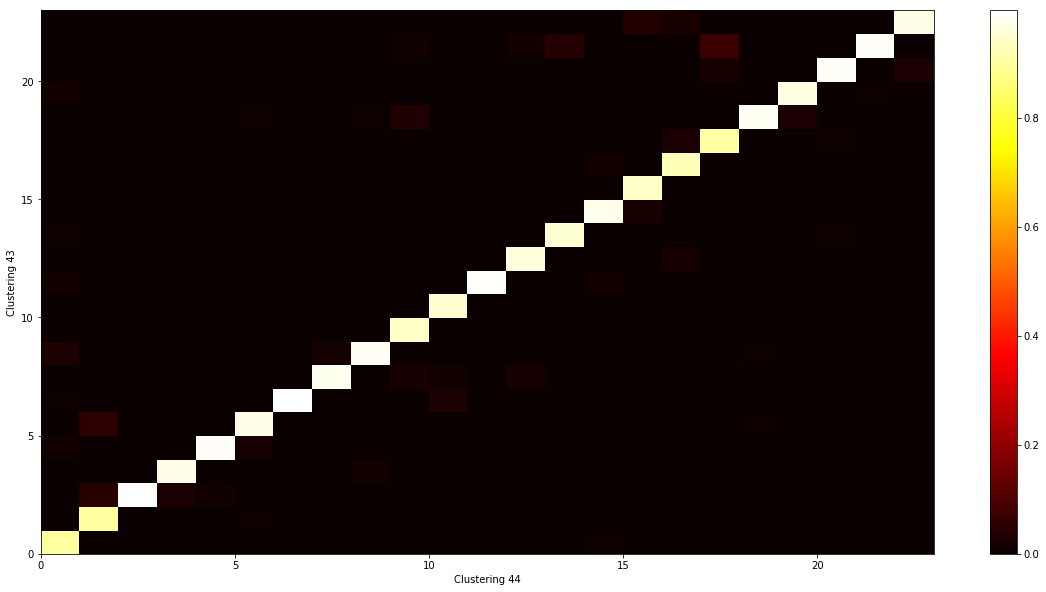

In [1238]:
#Here we find out how to re-index based off the maximum value along the rows. 
#We also plot the heat maps before and after reindexing

re_ind = {}
for i in range(num_clusterings-1):
    ind = np.argmax(tracking[(i,i+1)],axis=1)
    re_ind[i] = ind
    ordered = tracking[(i,i+1)][:,ind]
    
    print("Before")
    
    plt.figure(figsize=(20,10))
    p0= plt.pcolormesh(tracking[(i,i+1)], cmap="hot")
    plt.colorbar(p0)
    plt.ylabel("Clustering " + str(i))
    plt.xlabel("Clustering " + str(i+1))
    plt.show()
    
    print("After")
    
    plt.figure(figsize=(20,10))
    p= plt.pcolormesh(ordered, cmap="hot")
    plt.colorbar(p)
    plt.ylabel("Clustering " + str(i))
    plt.xlabel("Clustering " + str(i+1))
    plt.show()
    
    

In [1233]:
#Here we create a new labelling to compare between the two time steps
compare_label = {}
for j in range(num_clusterings-1):
    #insert a -1 into the zero'th slot of re_ind[j]
    temp_ind = np.insert(re_ind[j],0,-1)
    temp_label = np.copy(label_sets[()][j])
    save_unique = np.copy(np.unique(label_sets[()][j]))
    for i in range(np.unique(label_sets[()][j]).size):
        #replace the class i in j'th time chunk with the new labels
        temp_label[label_sets[()][j] == save_unique[i]] = temp_ind[i] 
    
    compare_label[j] = temp_label+nan_mask_slice

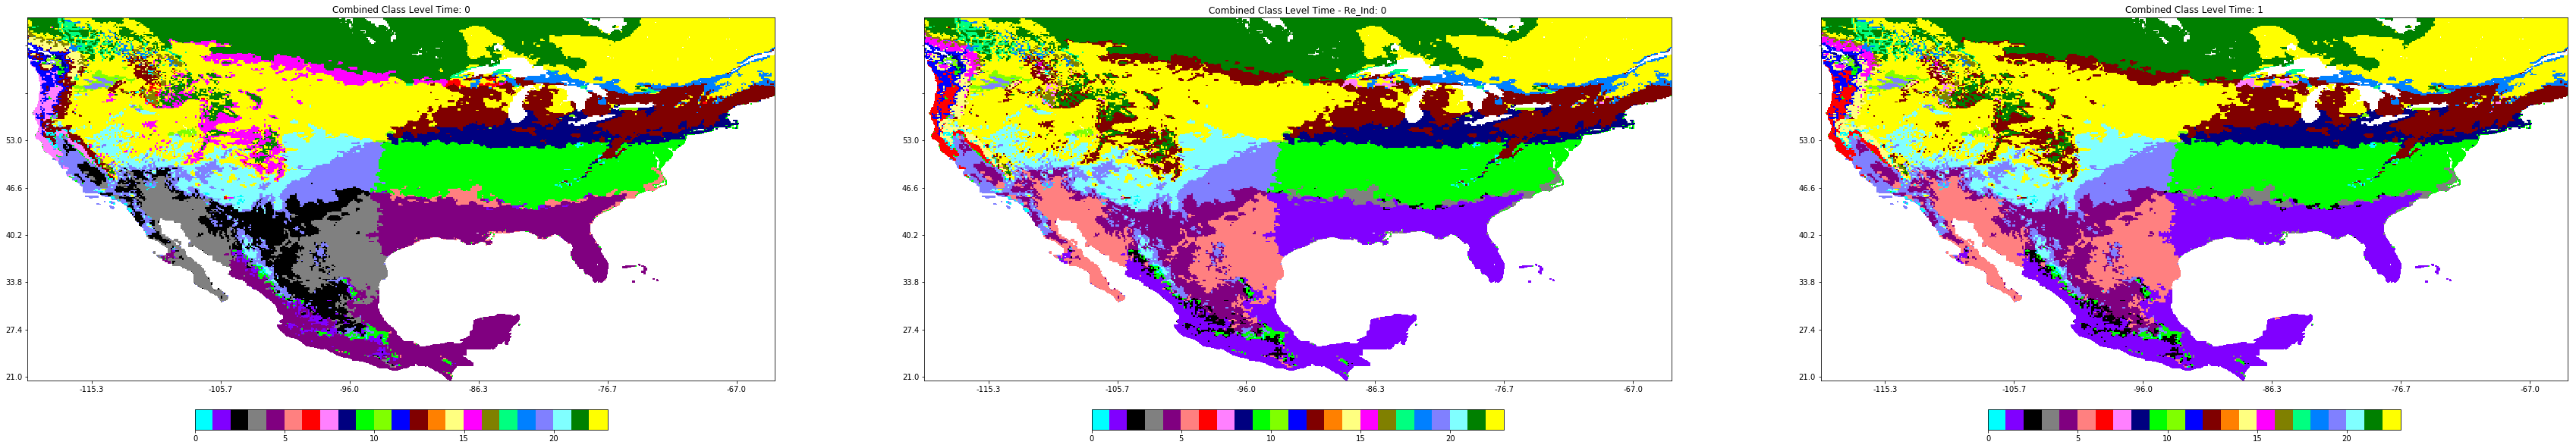

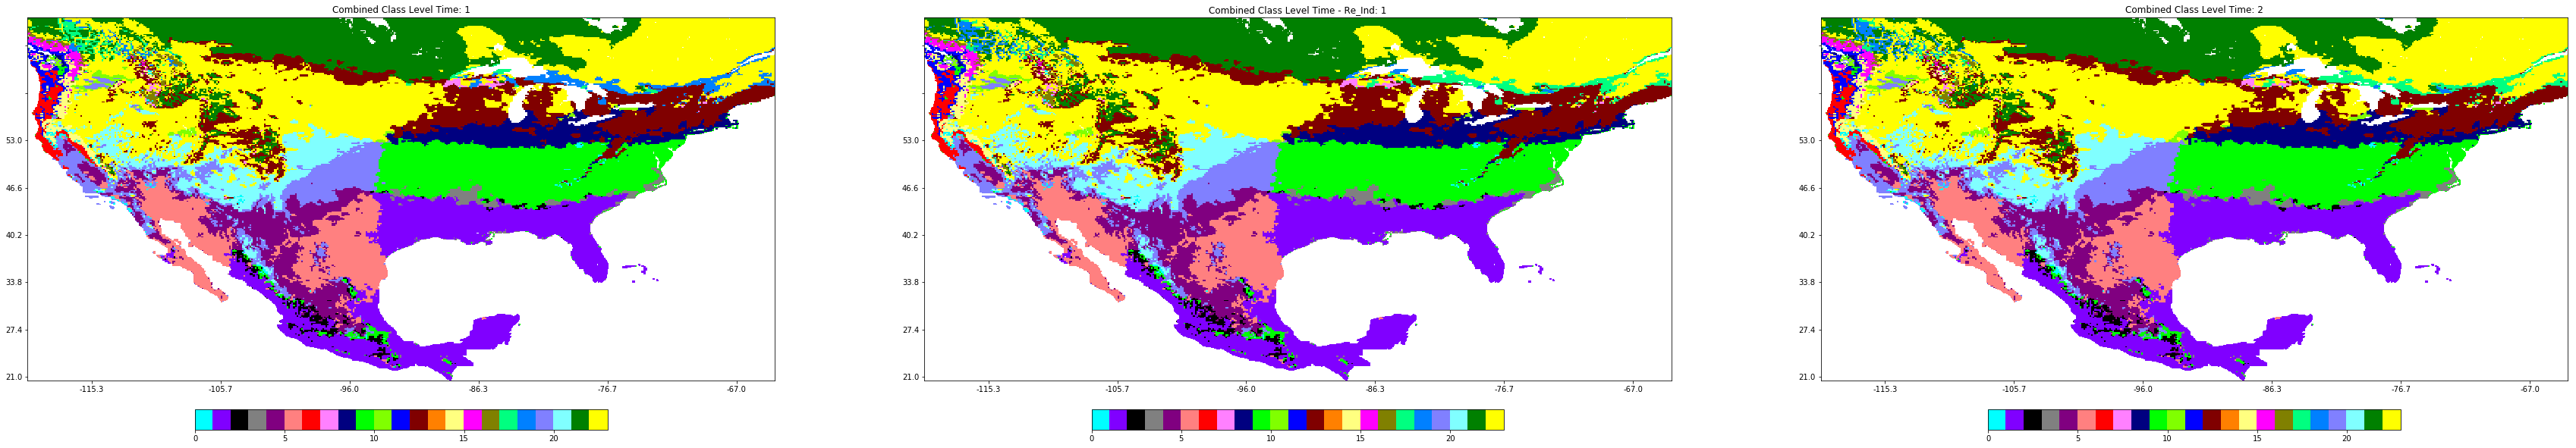

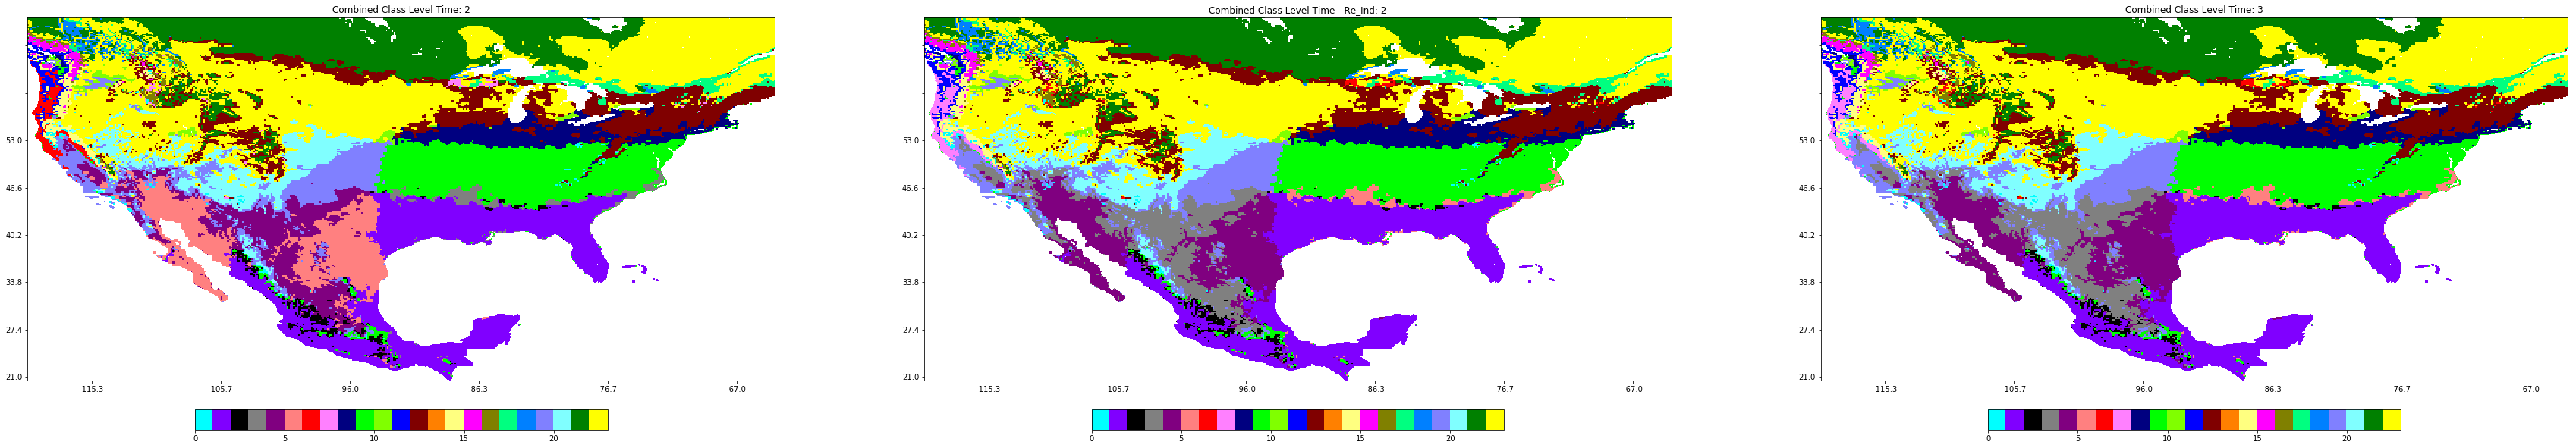

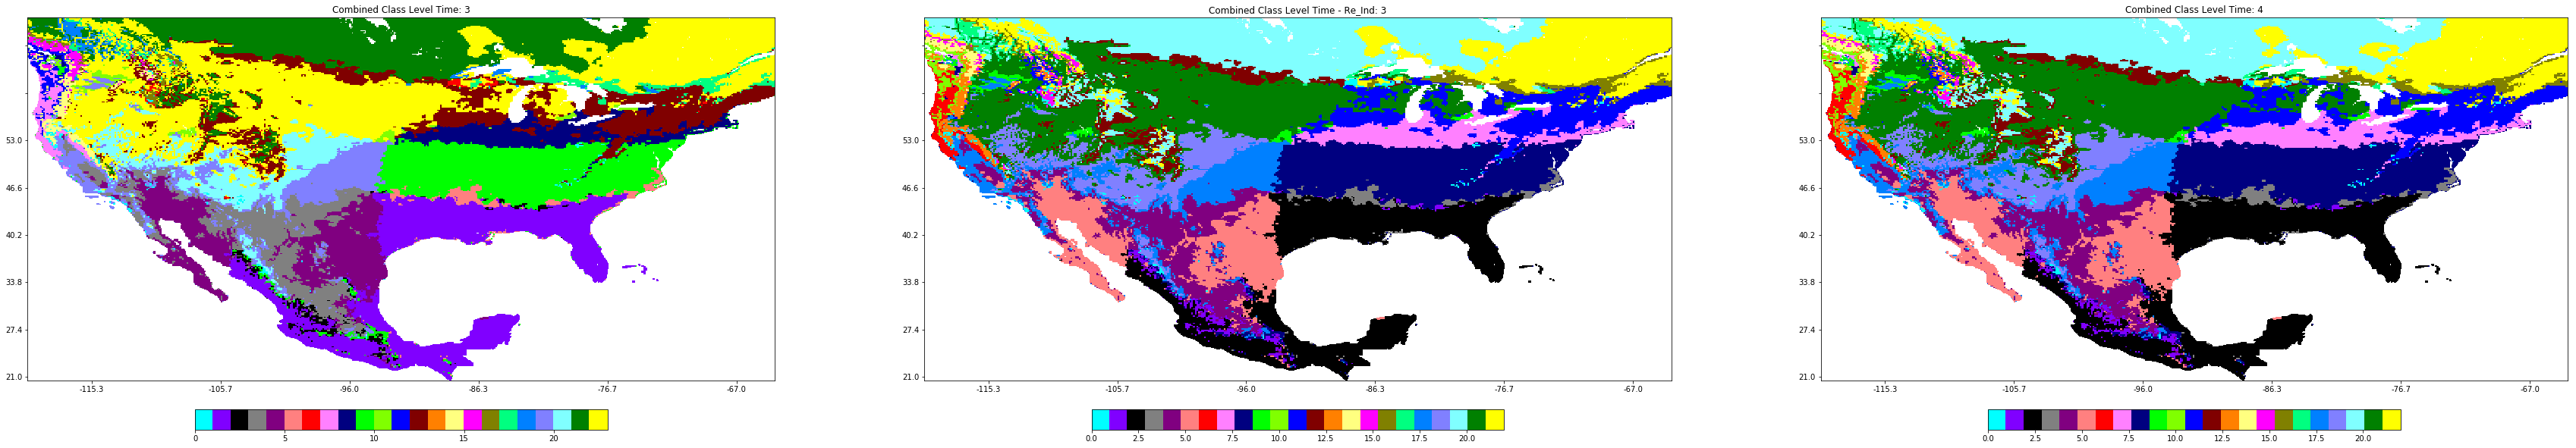

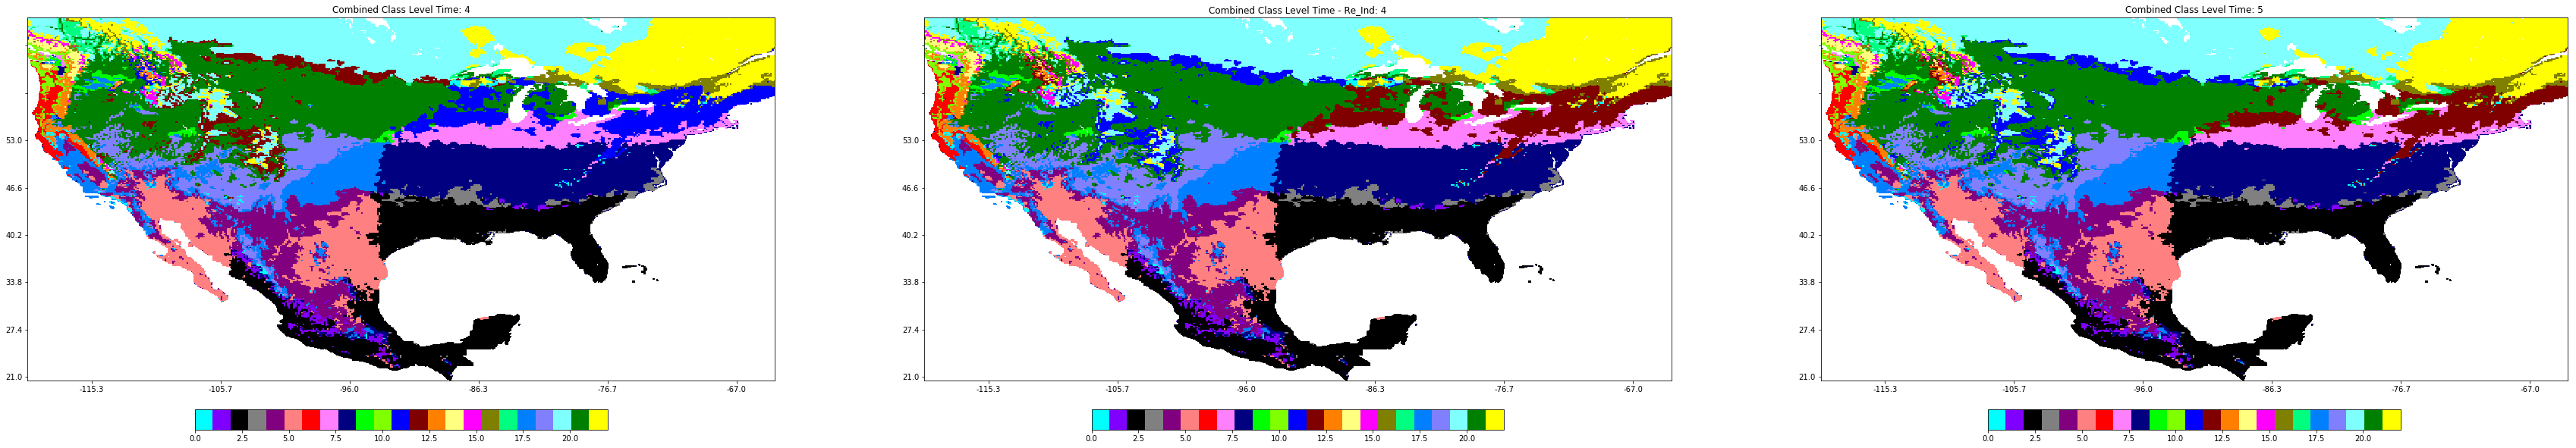

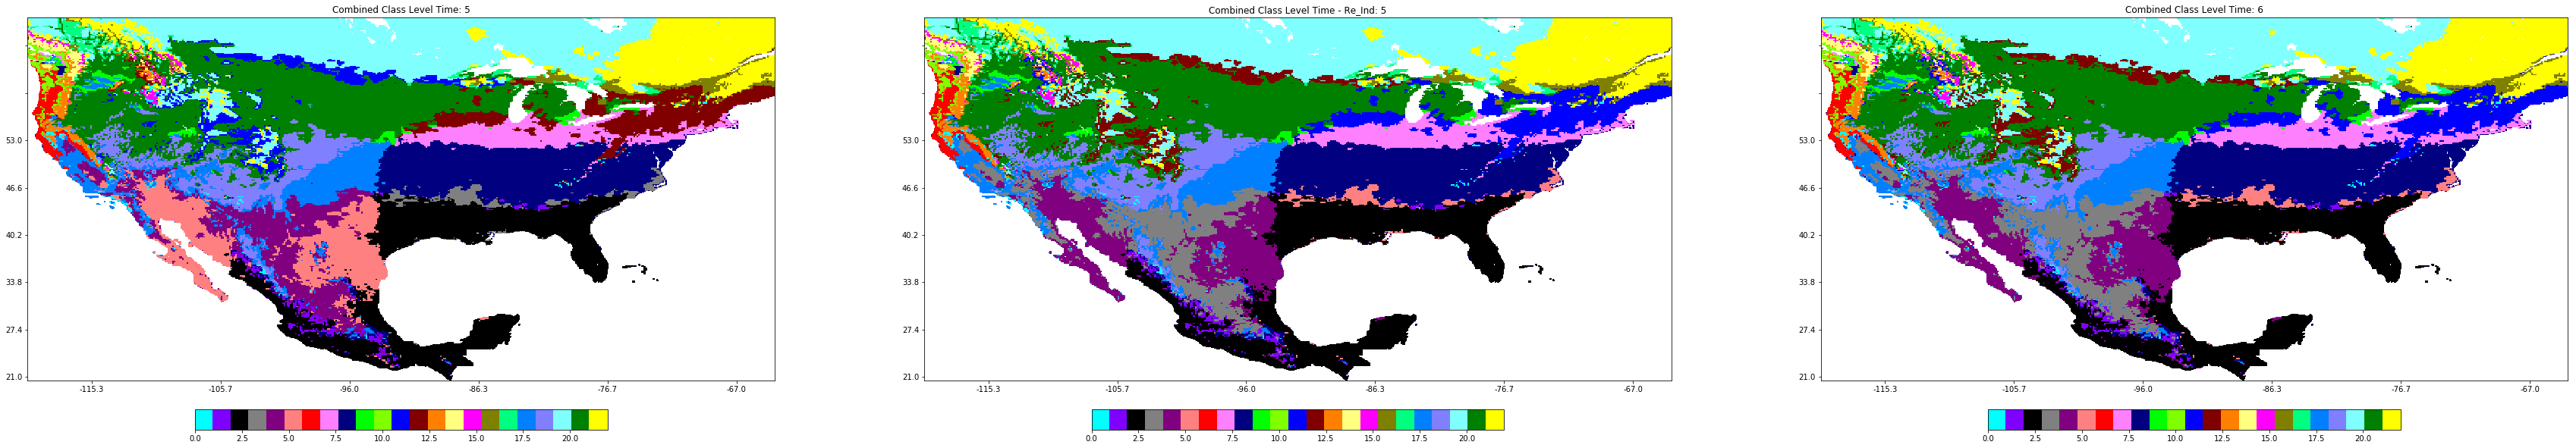

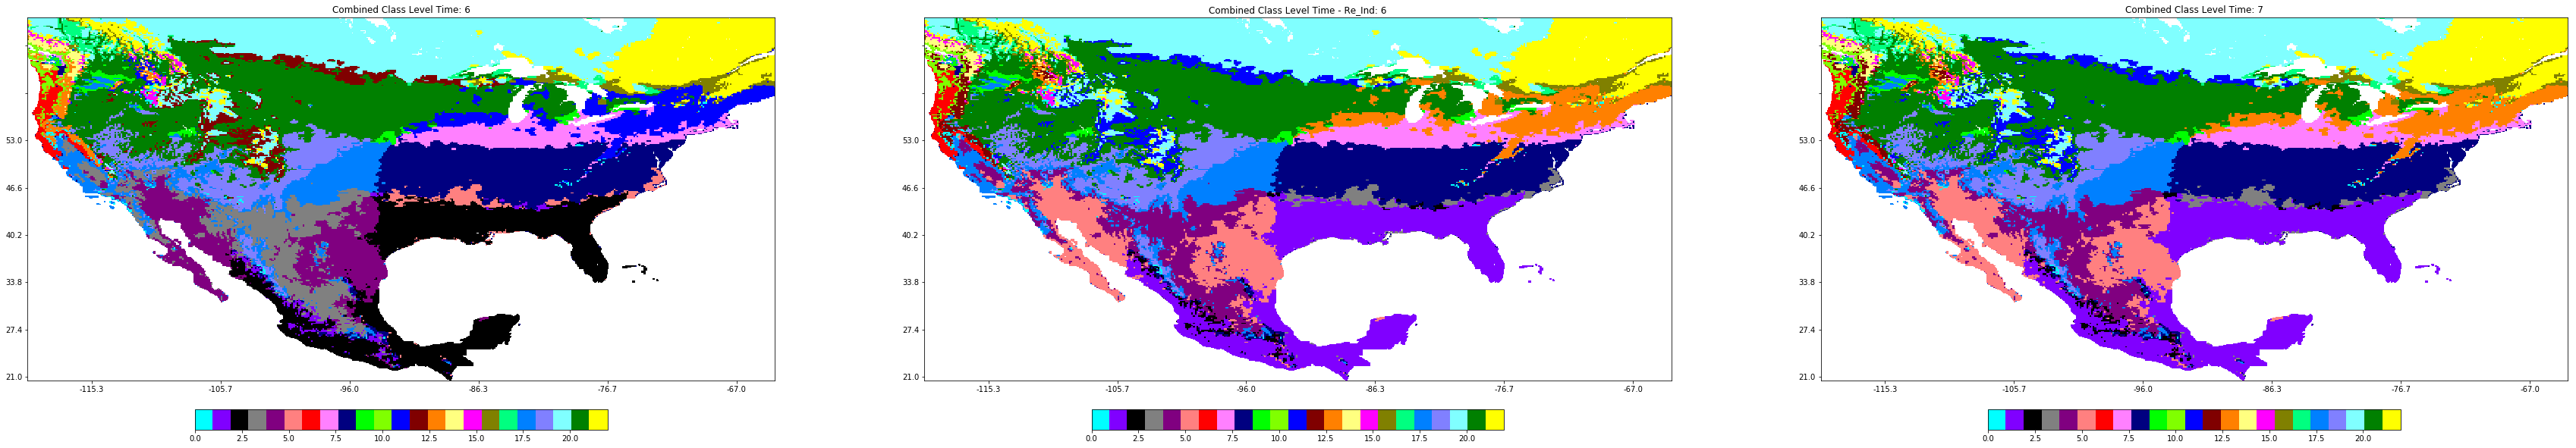

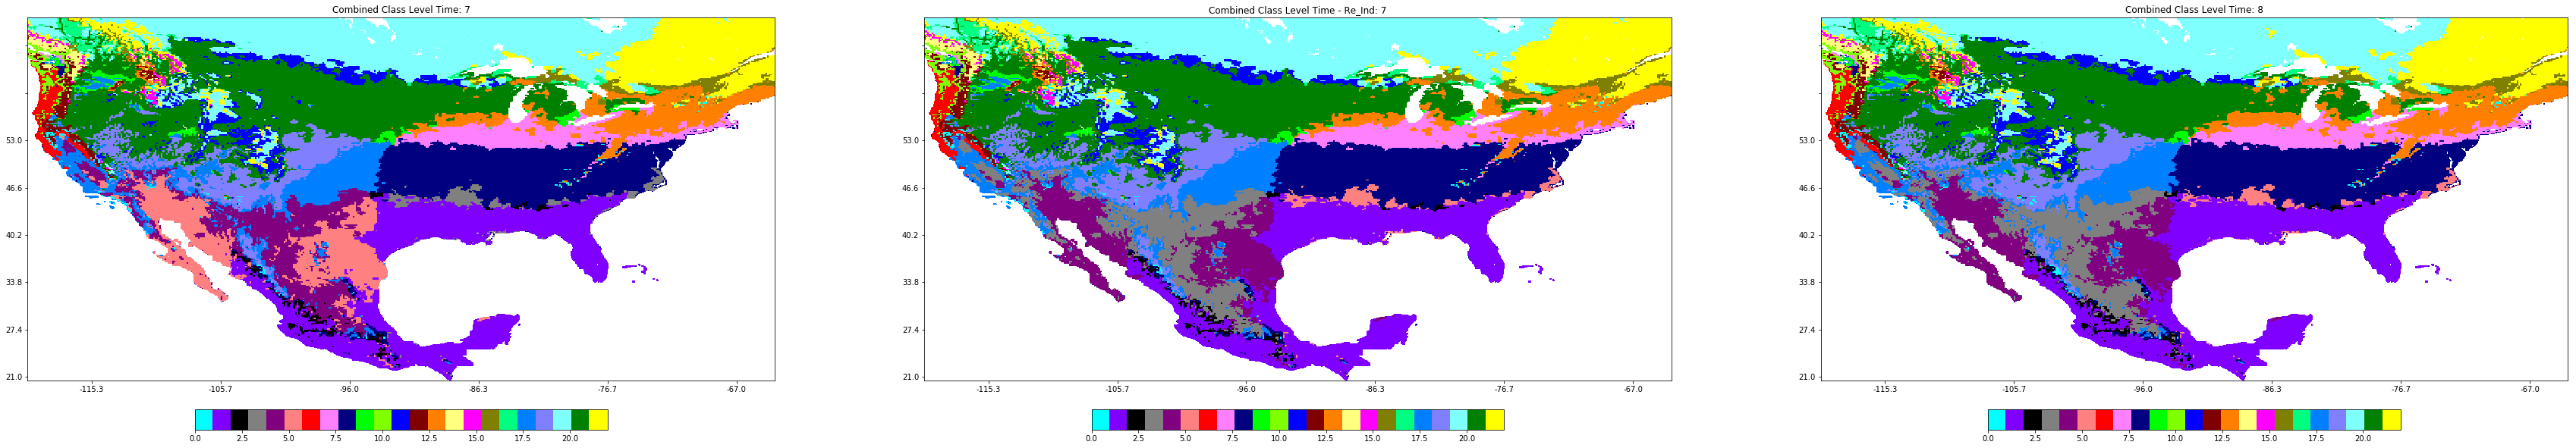

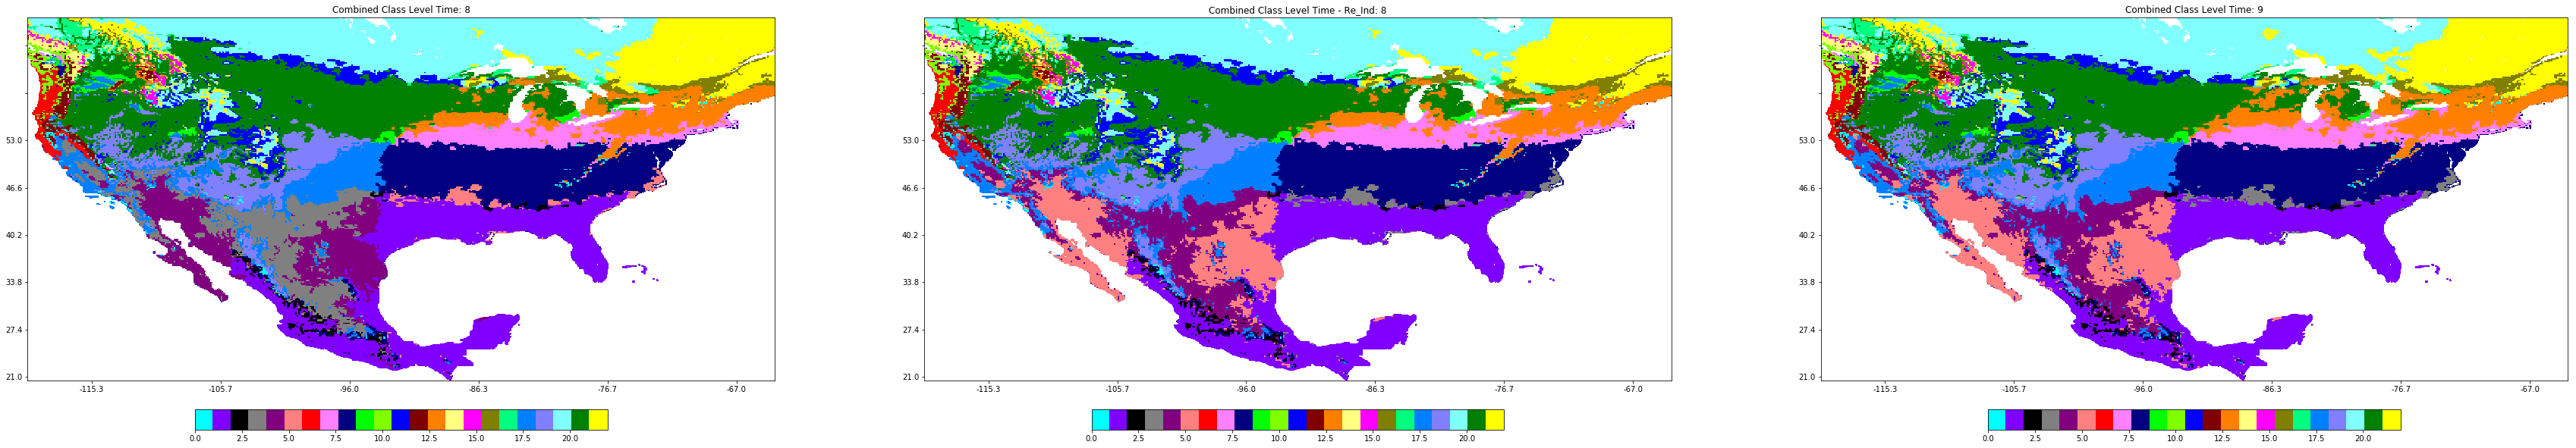

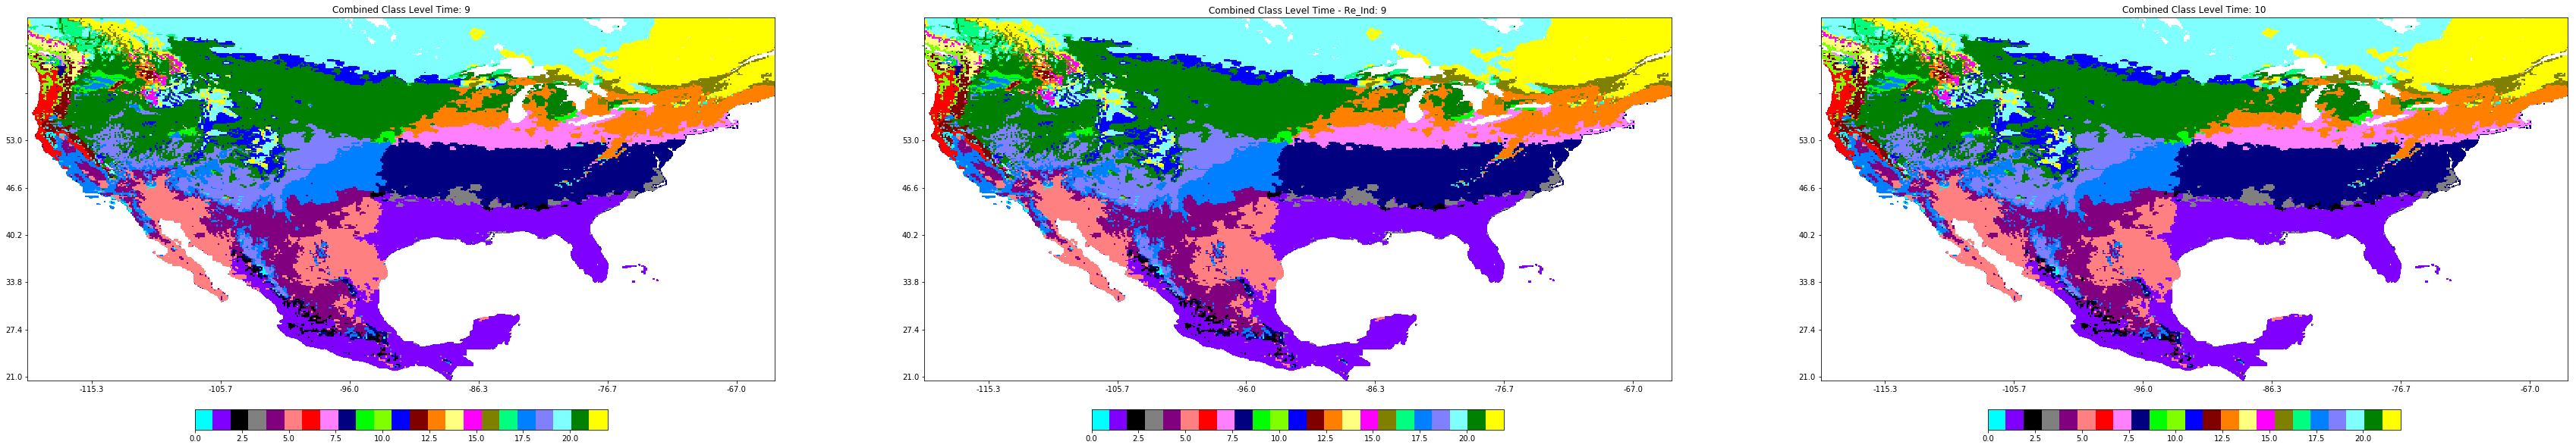

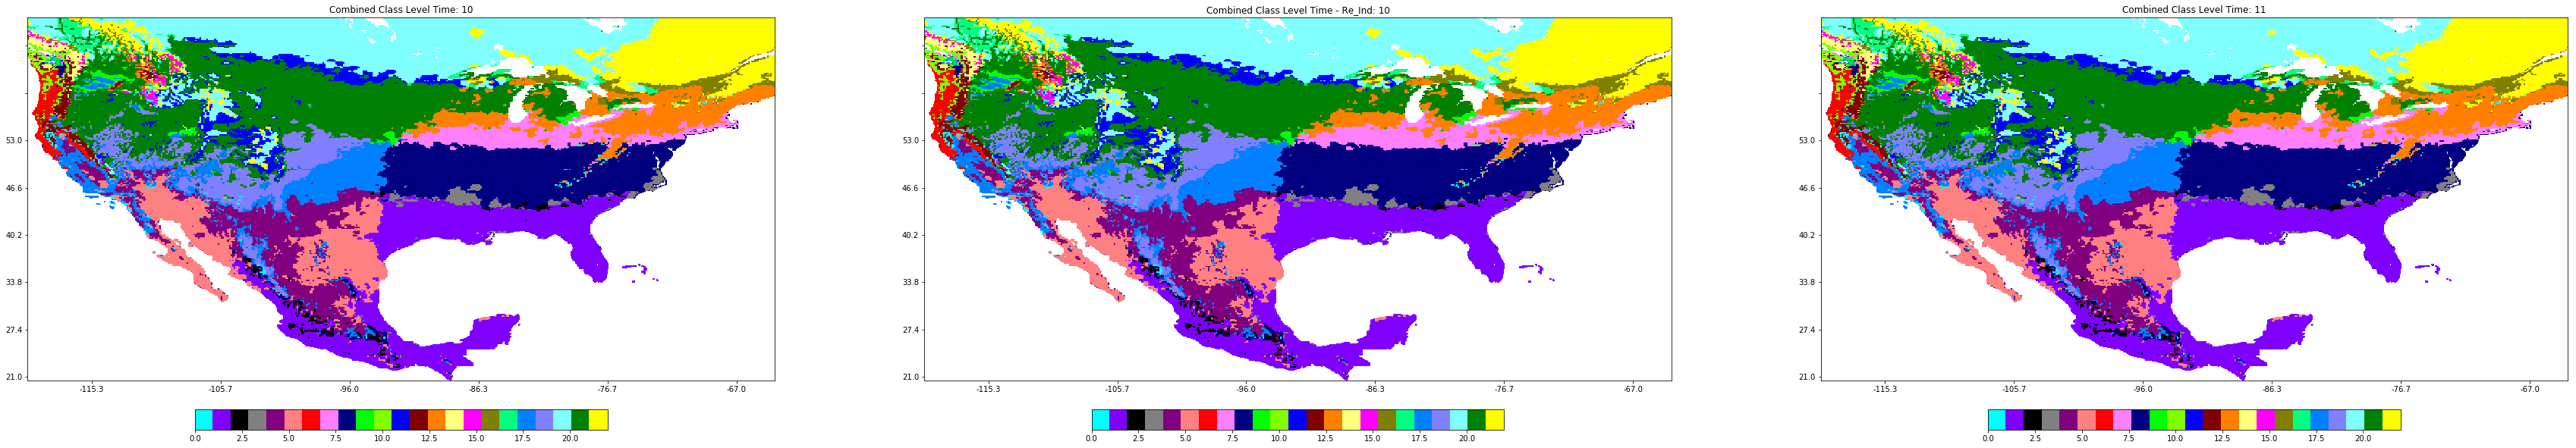

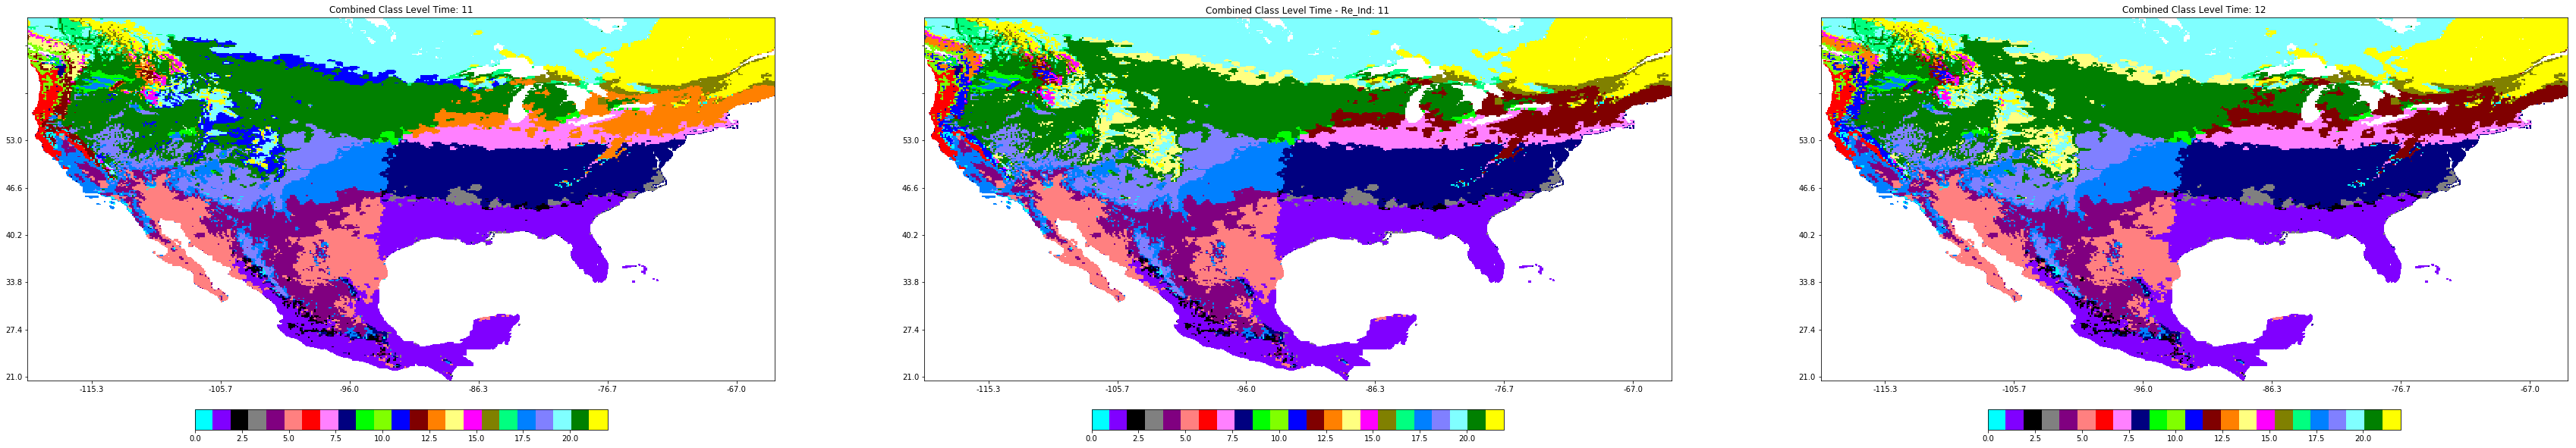

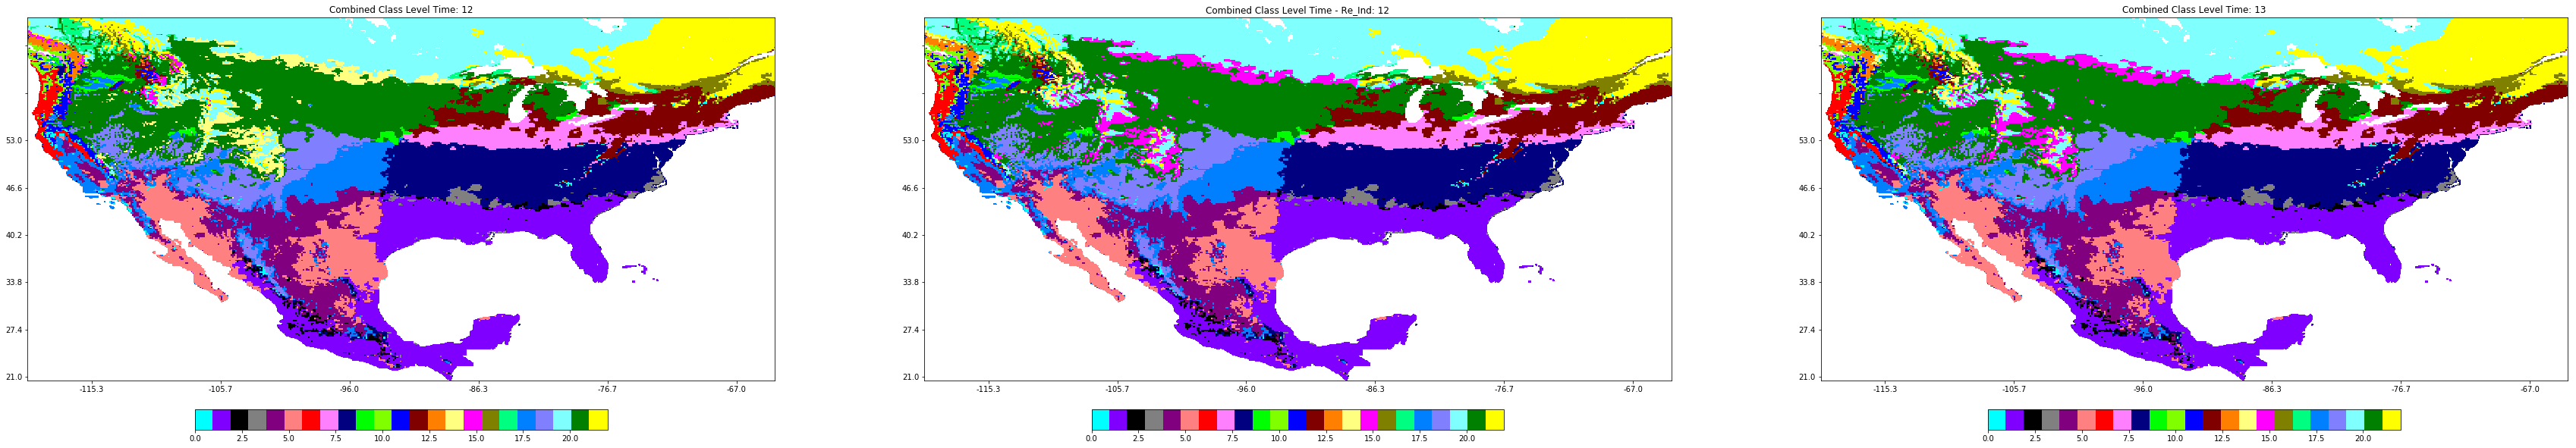

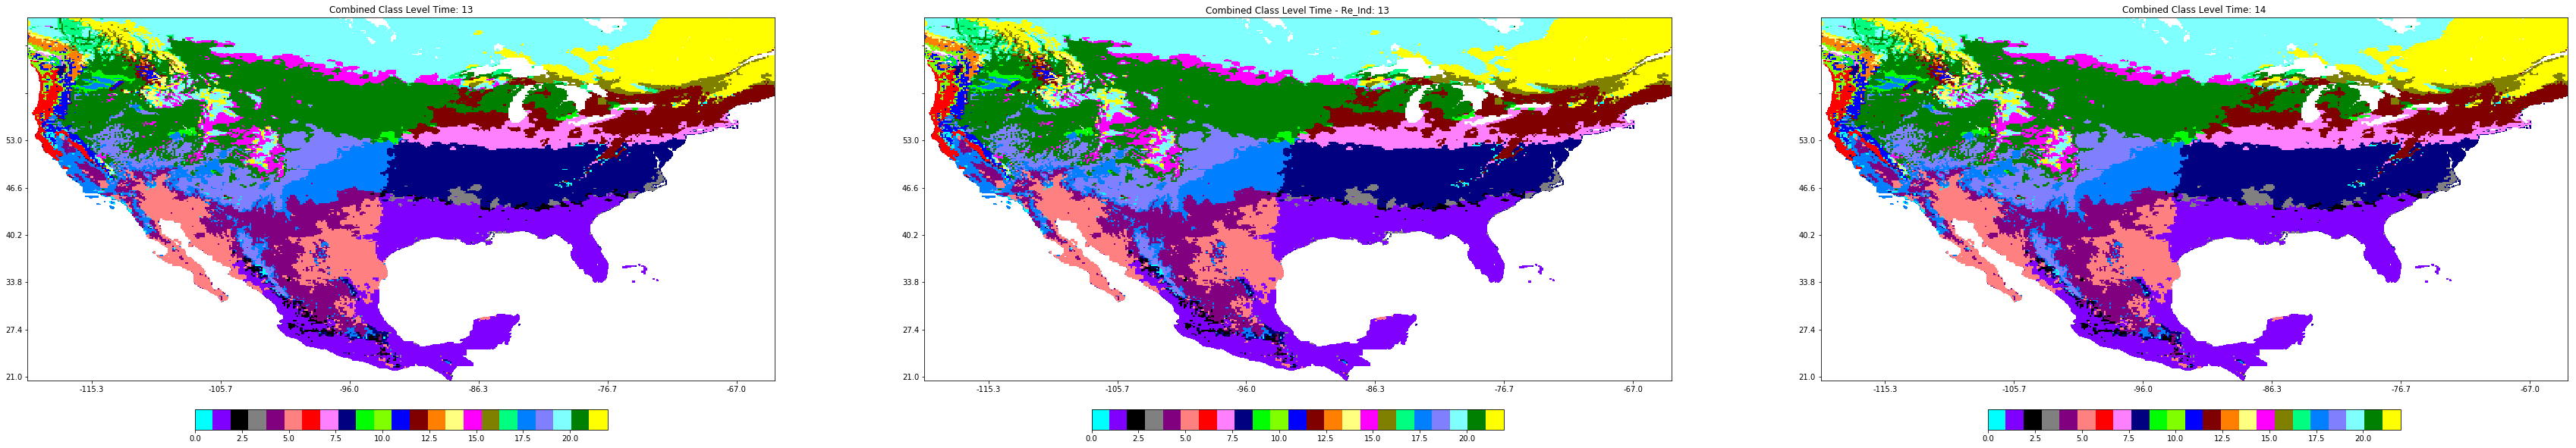

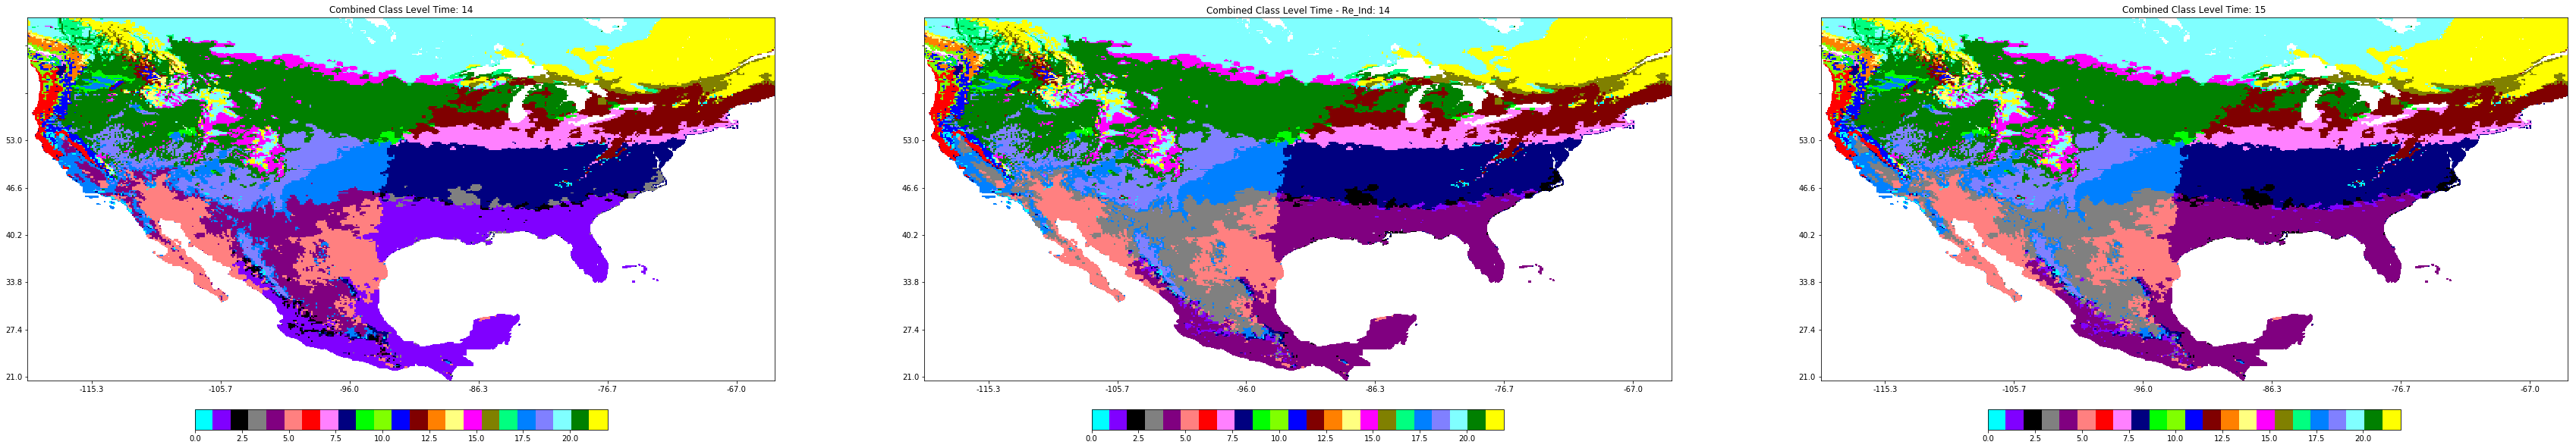

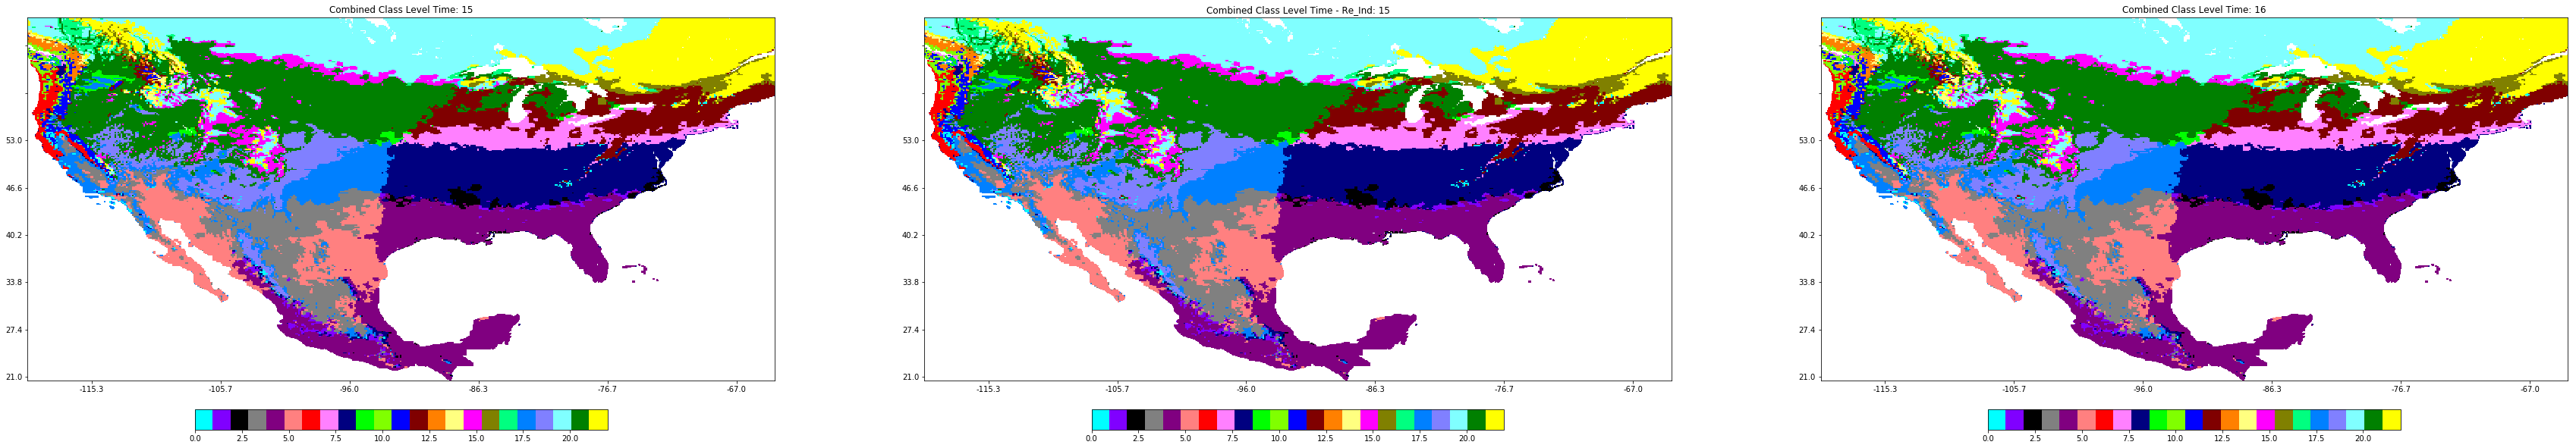

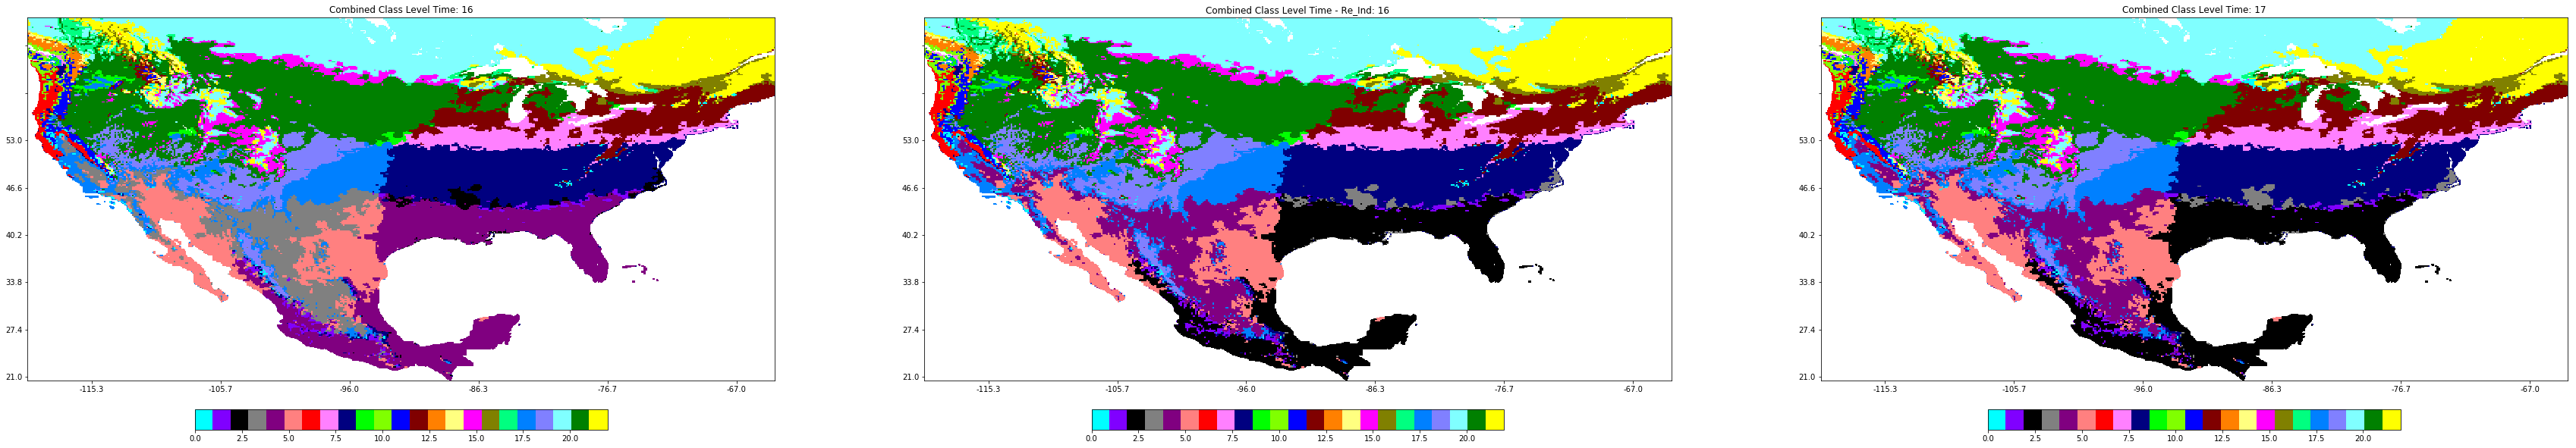

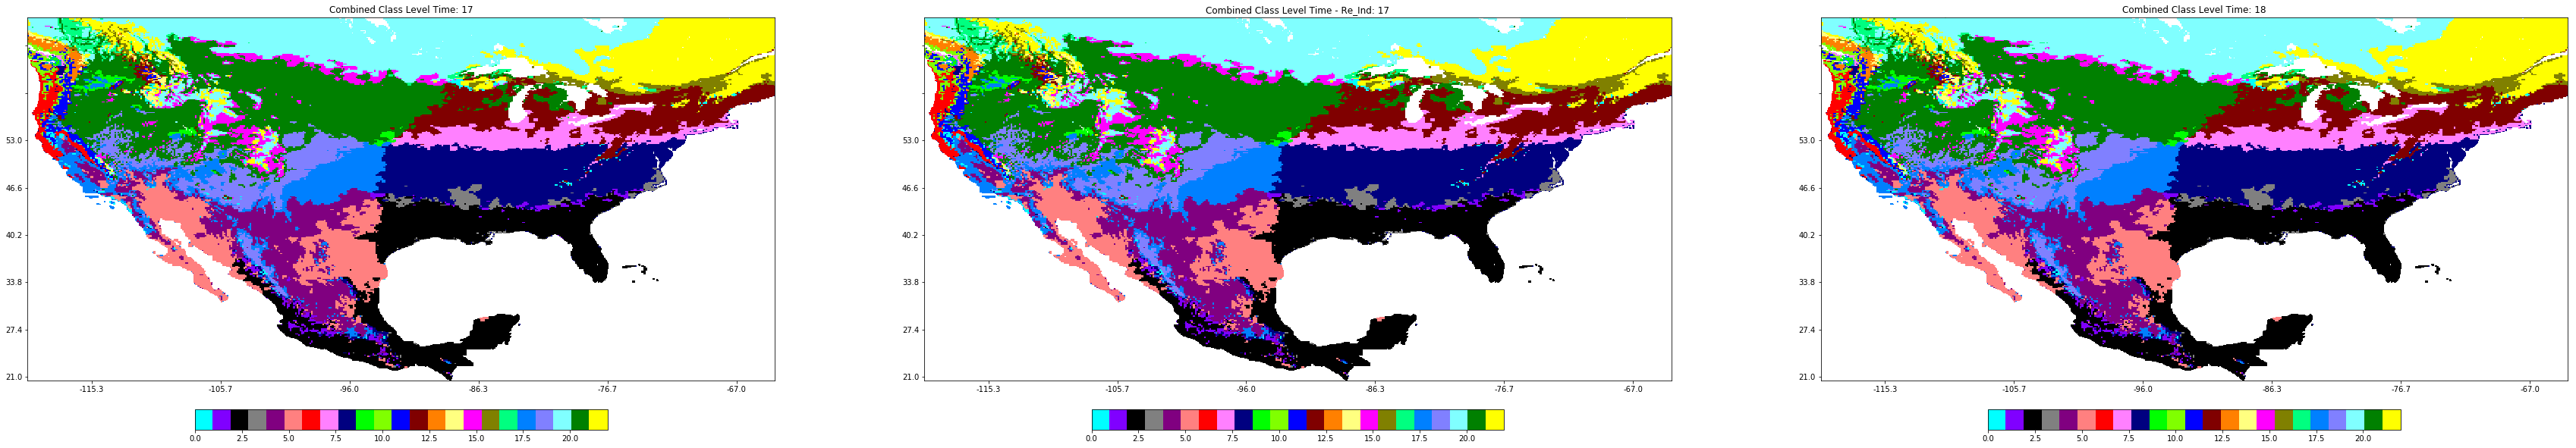

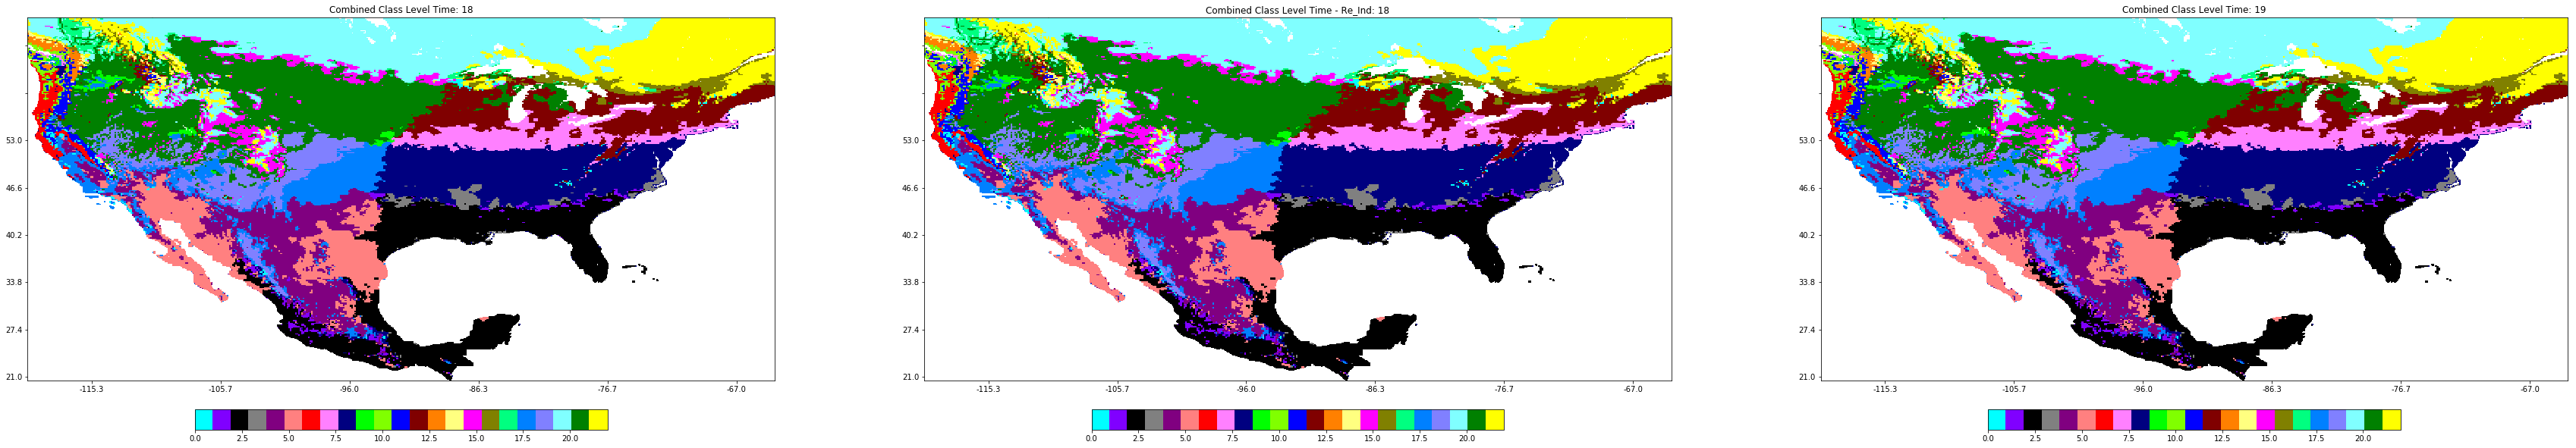

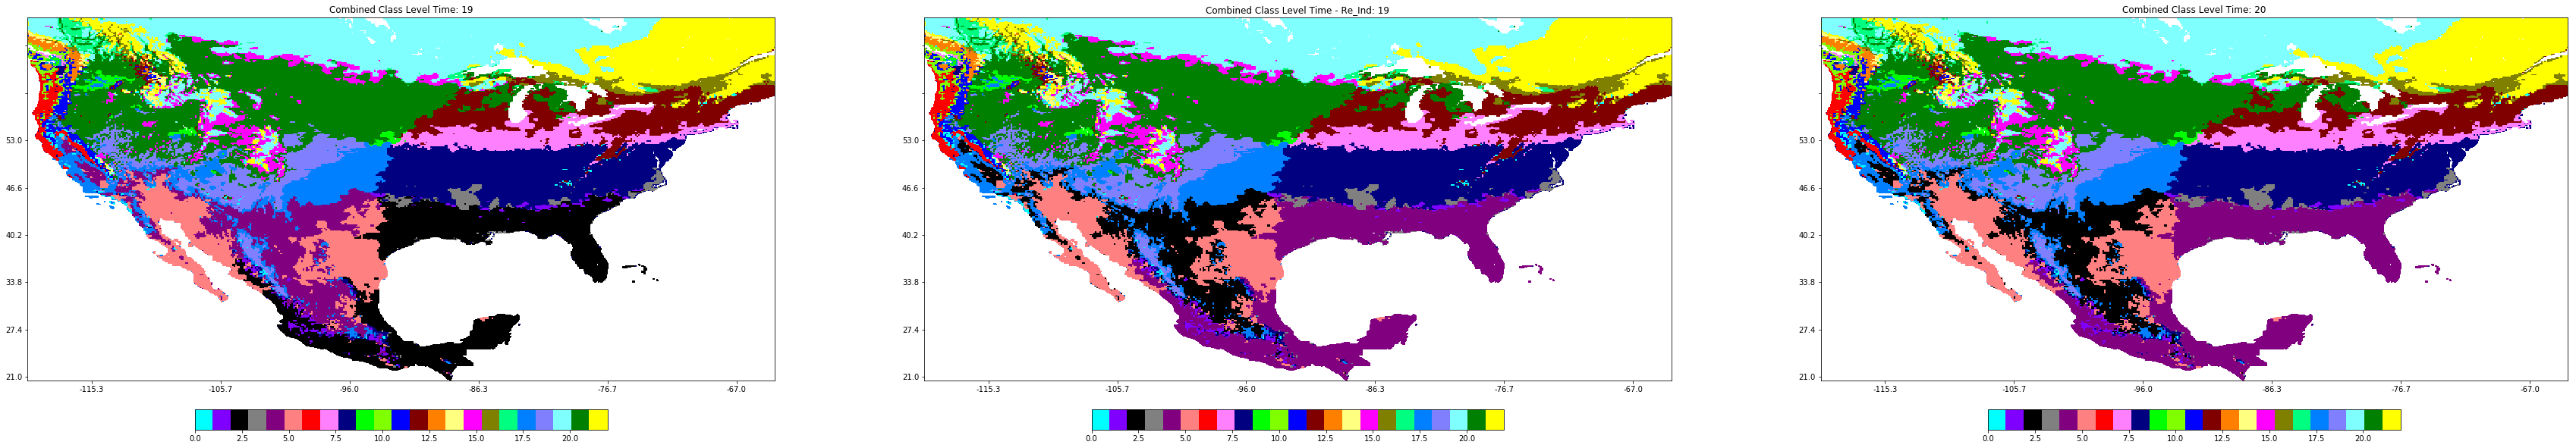

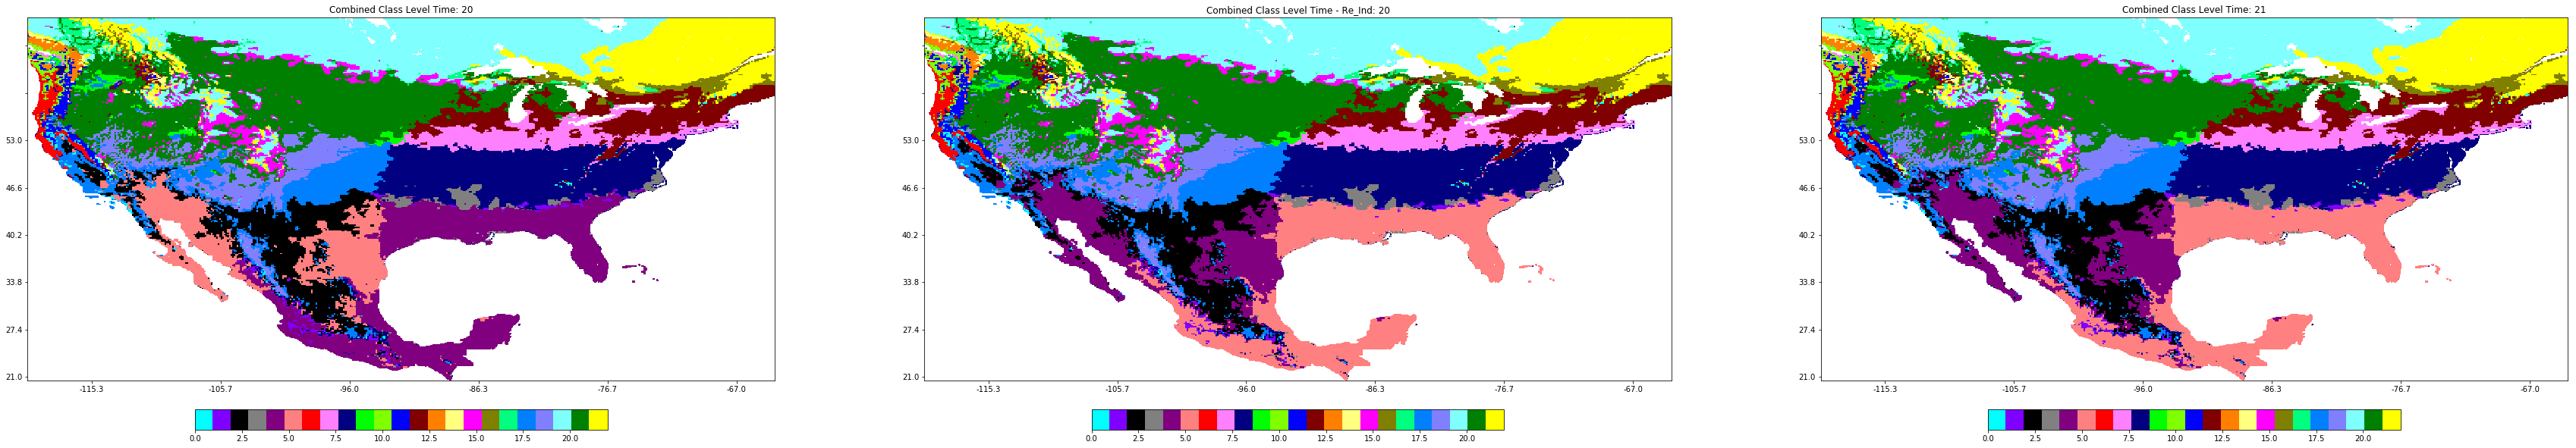

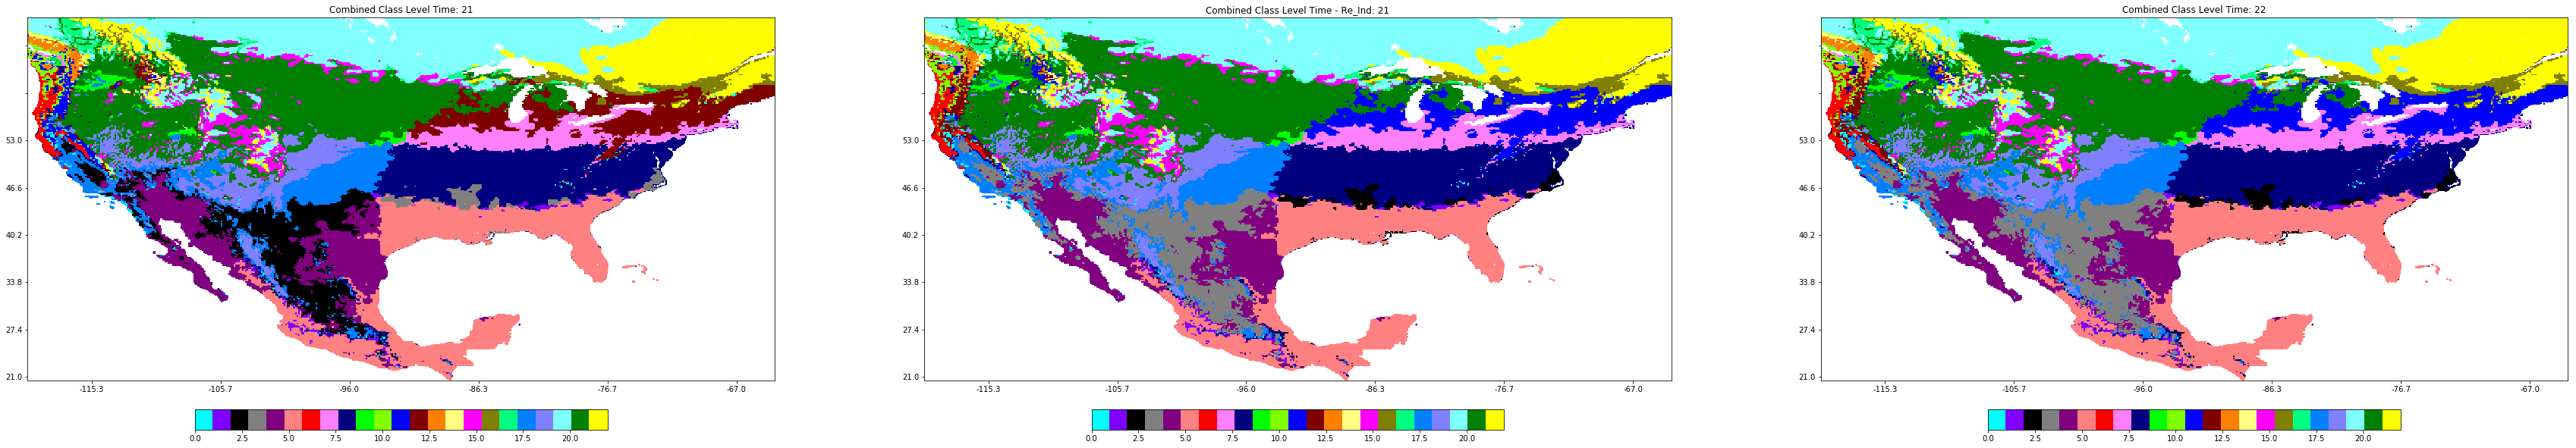

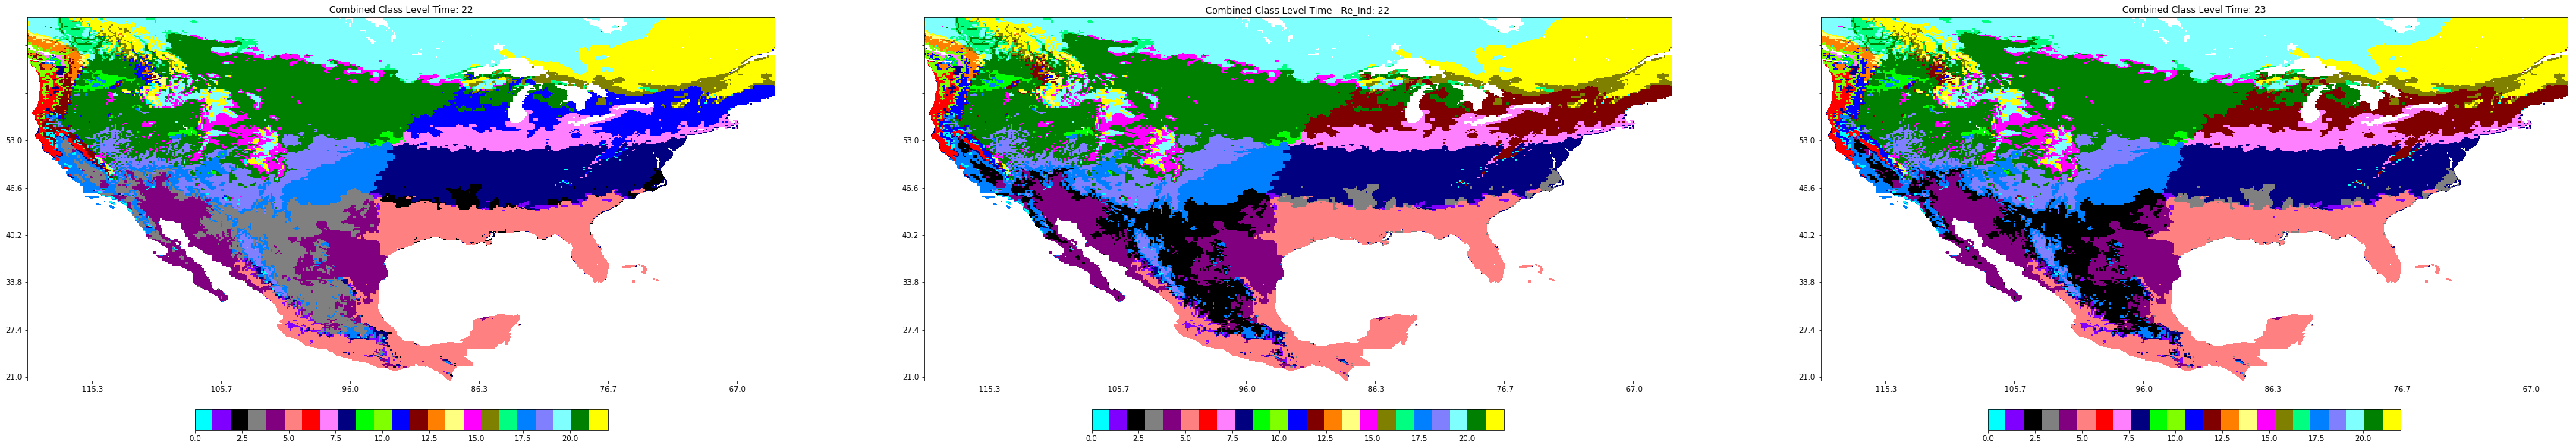

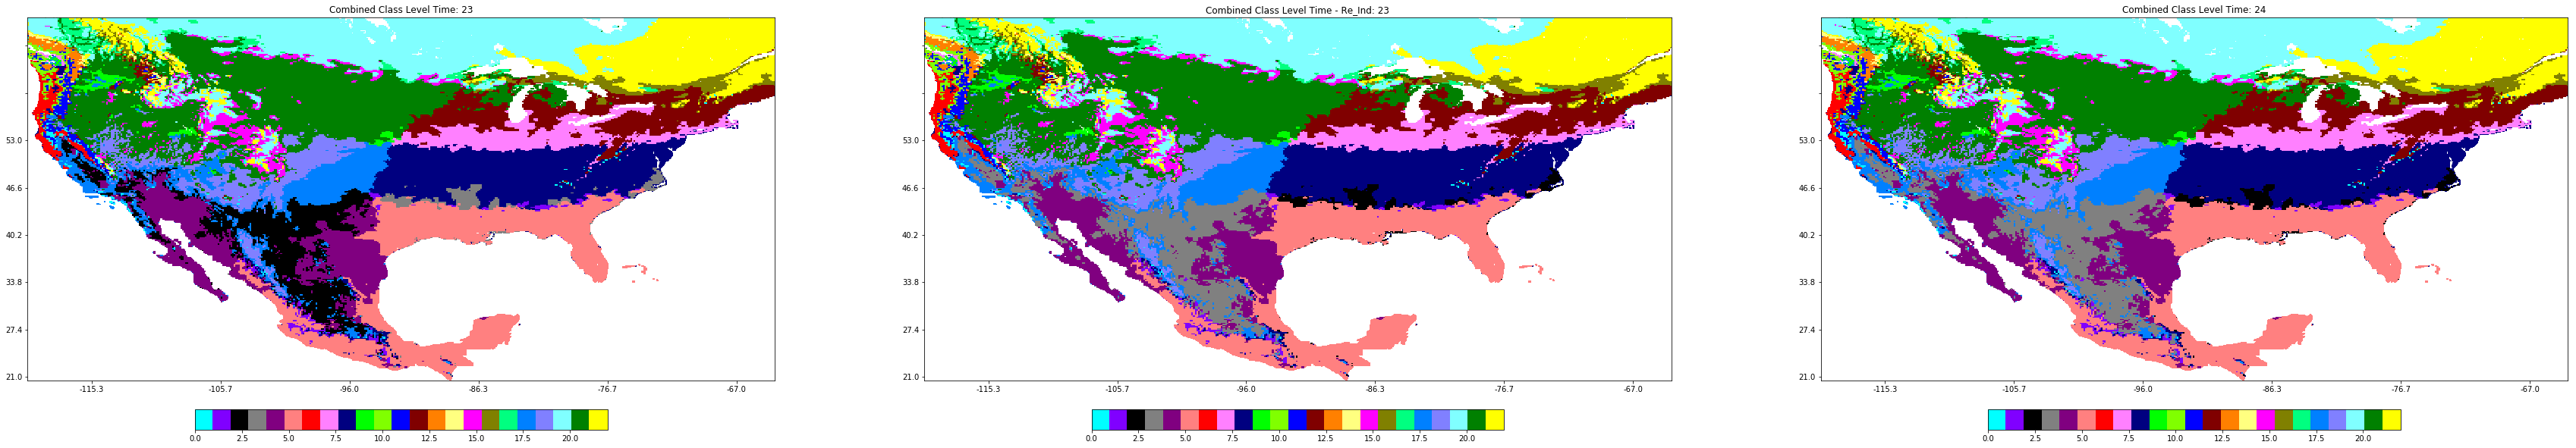

KeyboardInterrupt: 

In [1209]:
#Here we plot the initial clustering, the clustering after reindex, and the next time
for i in range(num_clusterings-1):
    
    f, ax = plt.subplots(figsize=(60, 10), ncols=3, nrows=1)
    
    ###
    #First plot is the regular combined classes:
    ###
    
    number_labels = np.nanmax(label_sets[()][i])    
    cmap = color.ListedColormap(colormap)
            #Plot Prec
    p0 = ax[0].pcolormesh(ds.lon, ds.lat, plot_sets[i], vmin=0, vmax=number_labels, cmap=cmap)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
    plt.colorbar(p0, ax=ax[0], orientation='horizontal',
                     pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
    ax[0].set_title('Combined Class Level Time: ' + str(i))

    ax[0].set_xticklabels(lon_space, minor=False)
    ax[0].set_yticklabels(lat_space, minor=False)
    #####
    #The second plot is the re_ind versions
    #####
    
    number_labels = np.nanmax(compare_label[i])    
    cmap = color.ListedColormap(colormap)
            #Plot Prec
    p0 = ax[1].pcolormesh(ds.lon, ds.lat, compare_label[i], vmin=0, vmax=number_labels, cmap=cmap)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
    plt.colorbar(p0, ax=ax[1], orientation='horizontal',
                     pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
    ax[1].set_title('Combined Class Level Time - Re_Ind: ' + str(i))

    ax[1].set_xticklabels(lon_space, minor=False)
    ax[1].set_yticklabels(lat_space, minor=False)

    #####
    #Last is the regular combined class of next time:
    #####
    
    number_labels = np.nanmax(label_sets[()][i+1])    
    cmap = color.ListedColormap(colormap)
            #Plot Prec
    p0 = ax[2].pcolormesh(ds.lon, ds.lat, plot_sets[i+1], vmin=0, vmax=number_labels, cmap=cmap)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
    plt.colorbar(p0, ax=ax[2], orientation='horizontal',
                     pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
    ax[2].set_title('Combined Class Level Time: ' + str(i+1))

    ax[2].set_xticklabels(lon_space, minor=False)
    ax[2].set_yticklabels(lat_space, minor=False)
    
    plt.show()

# Plot where biome has shifted

In [1212]:
#Compute Biome Shift:

biome_shift = {}
for i in range(num_clusterings-1):
    biome_shift[i] = plot_sets[i+1] - compare_label[i]
    biome_shift[i][biome_shift[i] !=0] =1
    biome_shift[i] = biome_shift[i] + nan_mask_slice

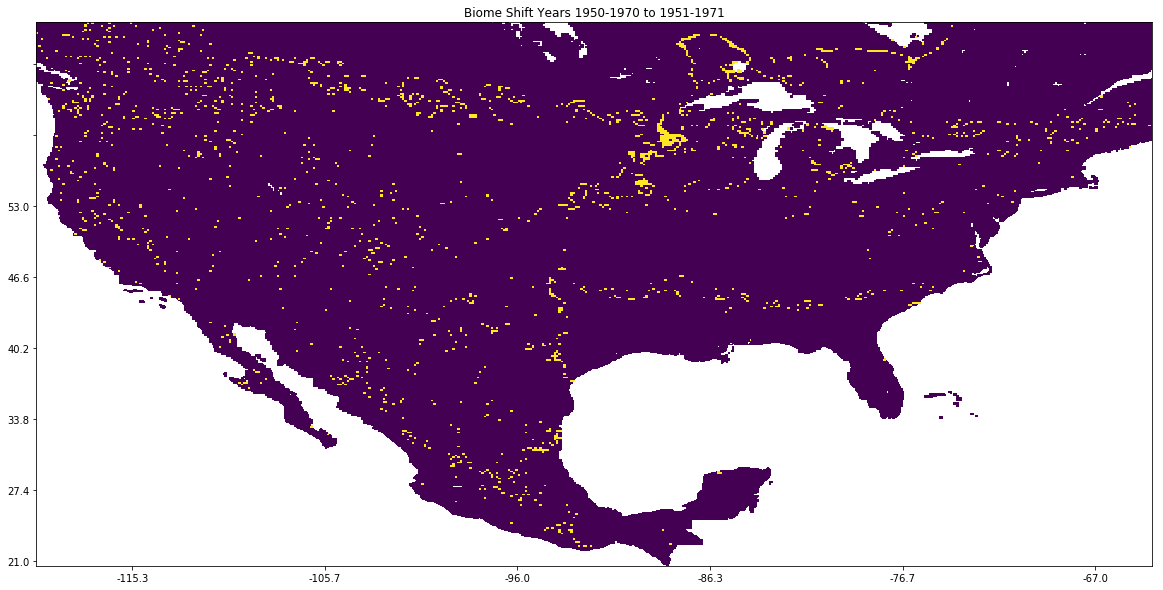

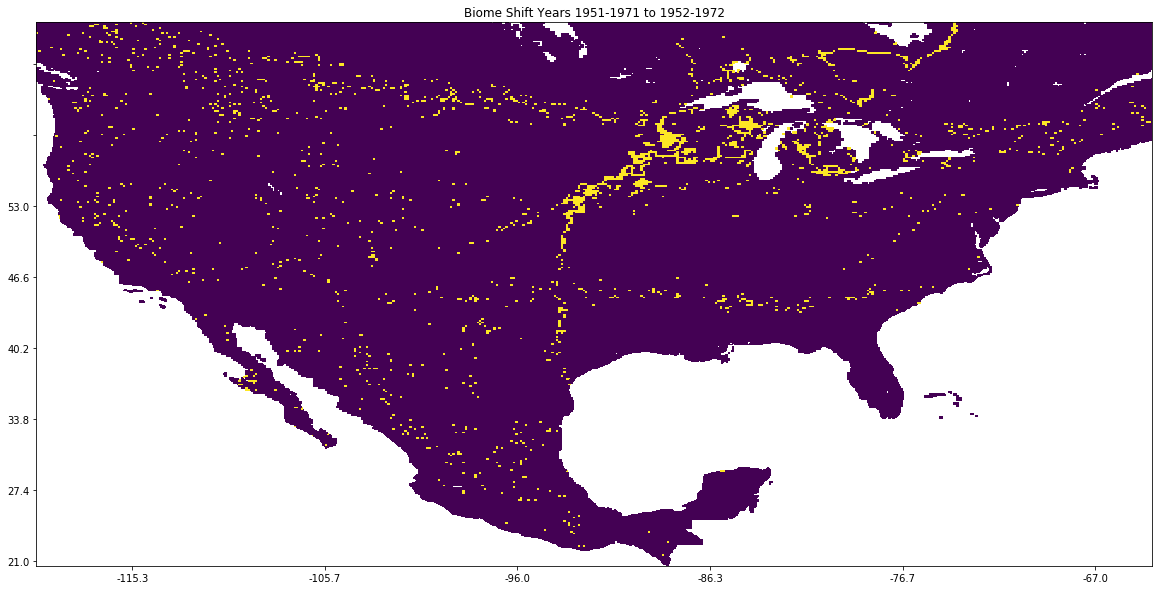

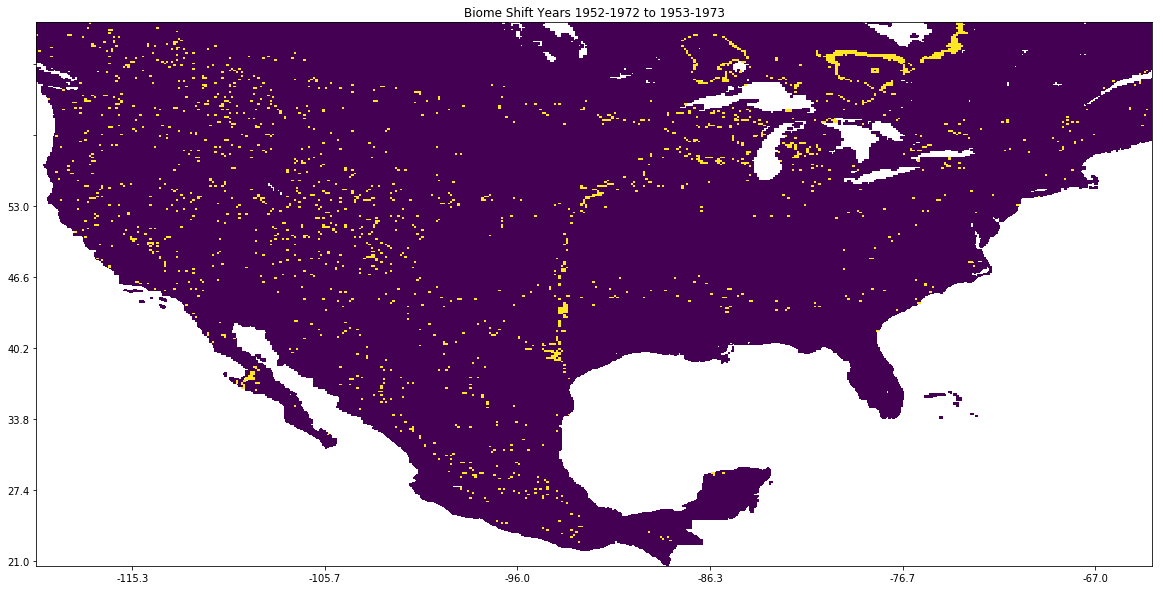

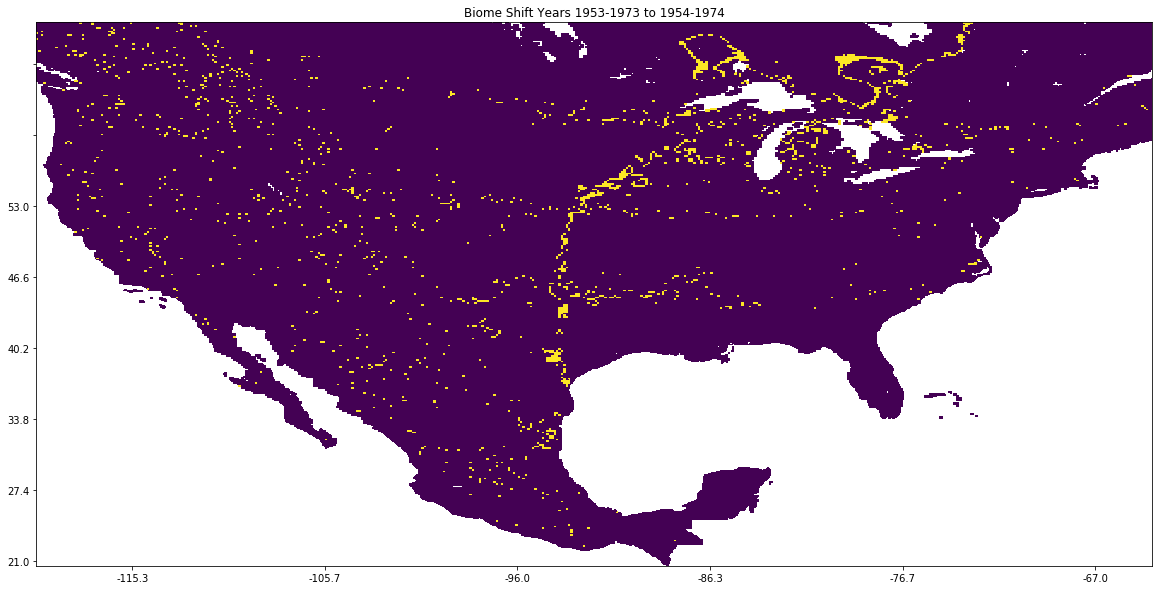

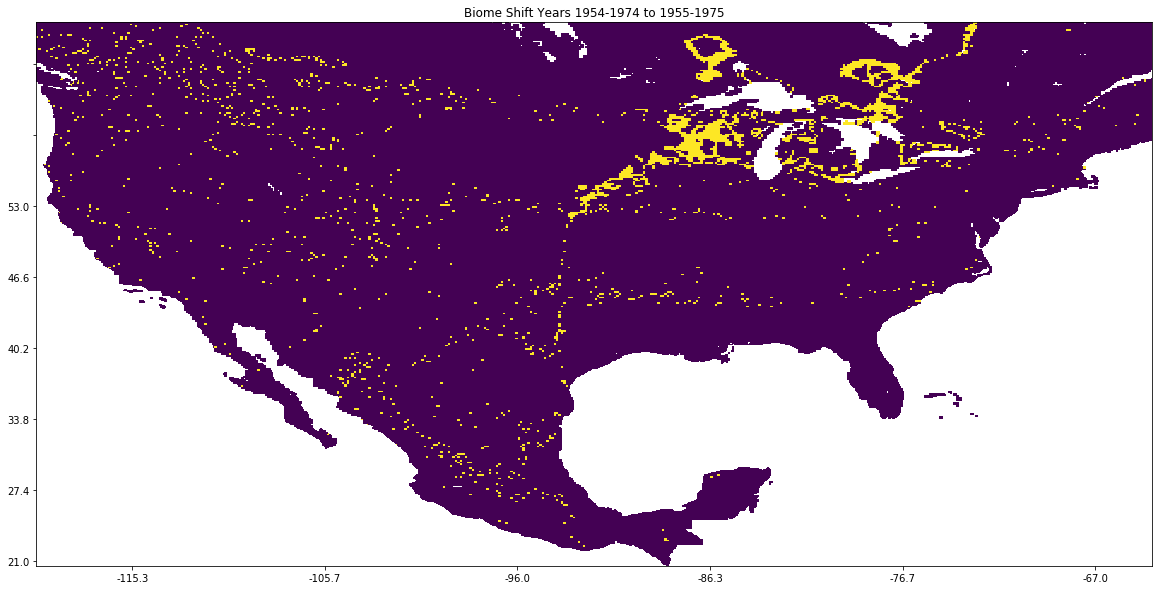

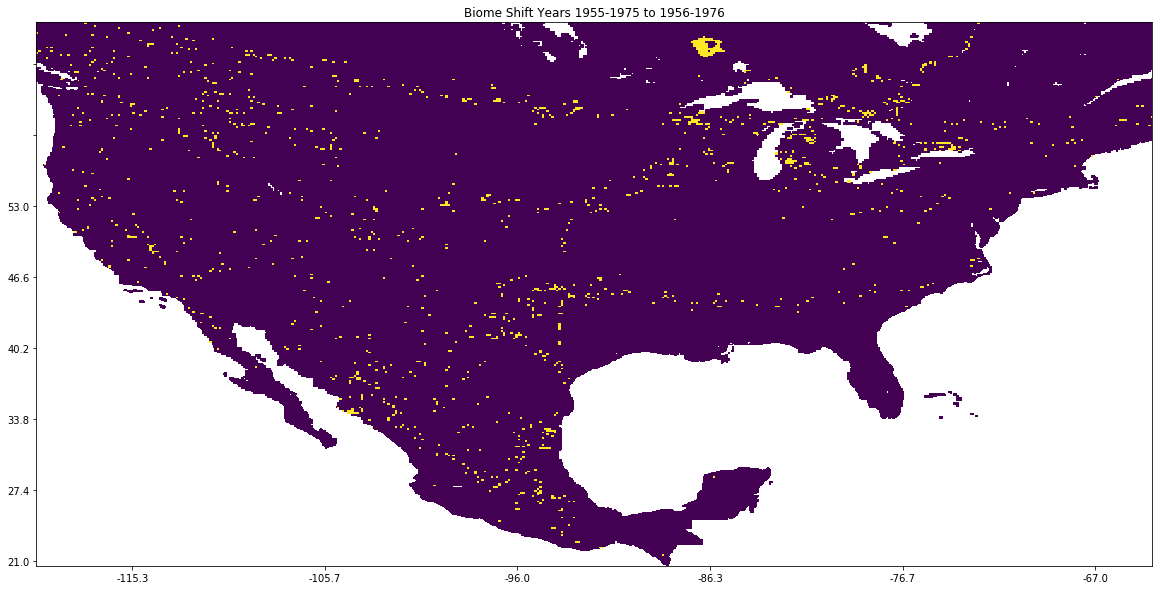

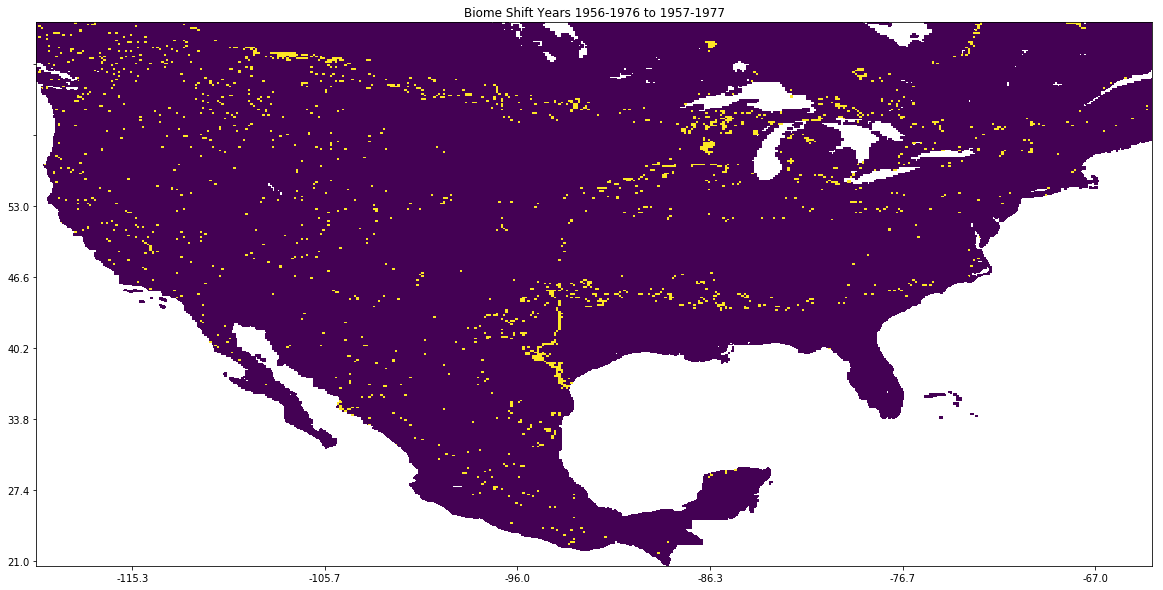

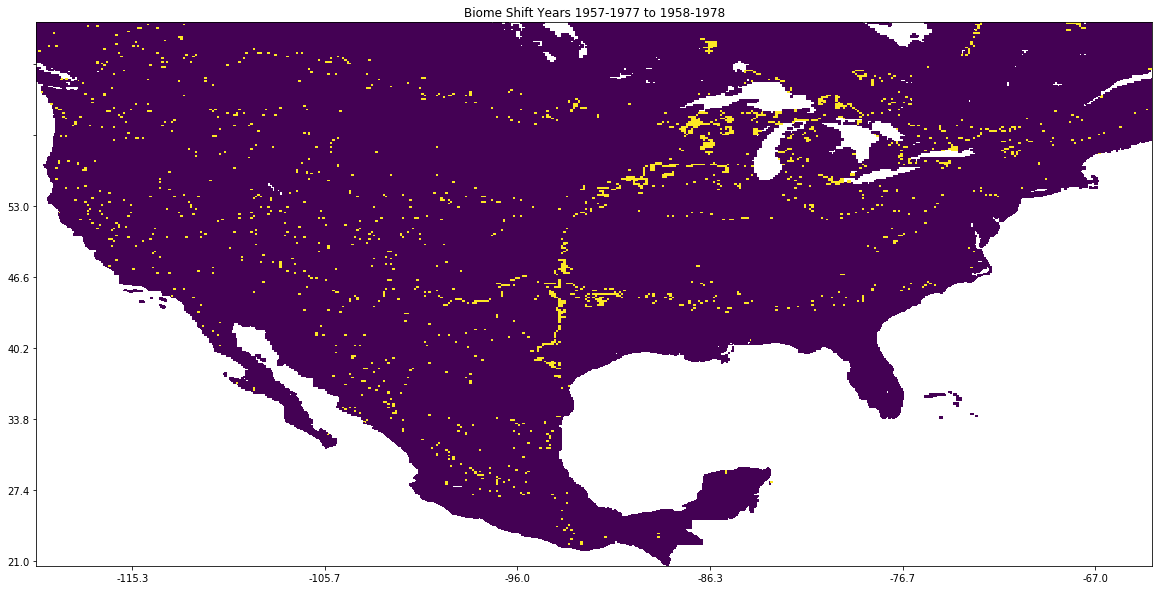

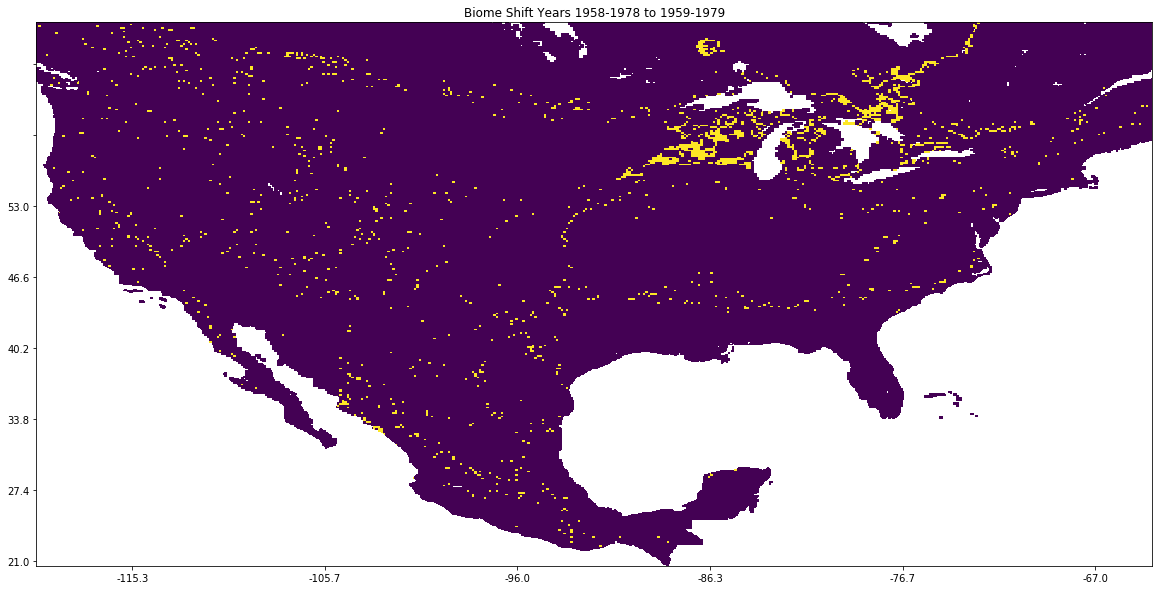

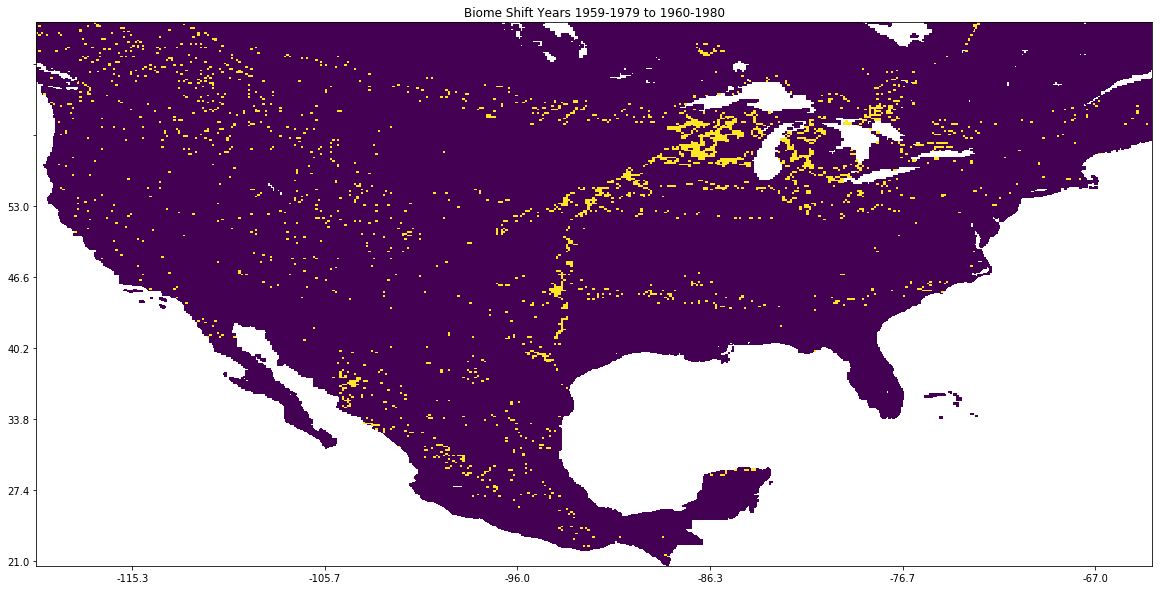

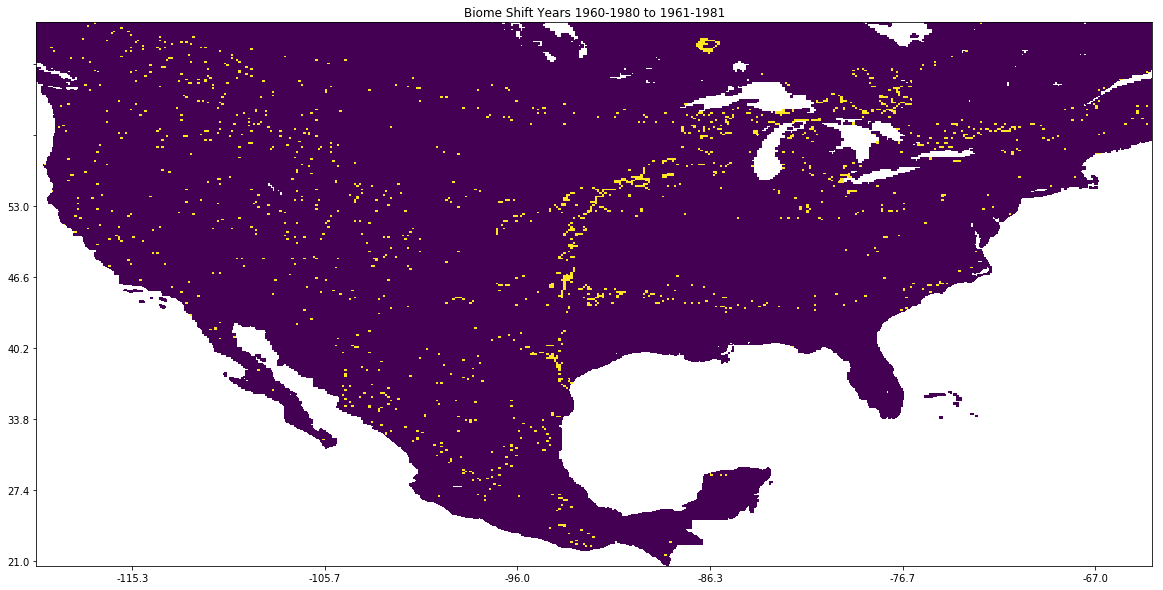

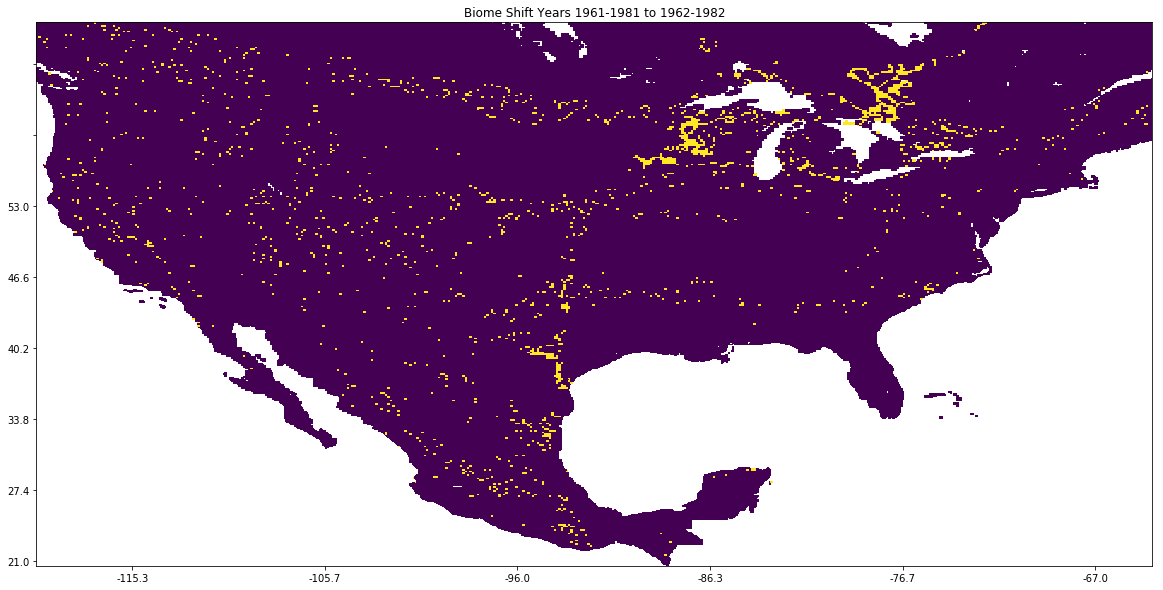

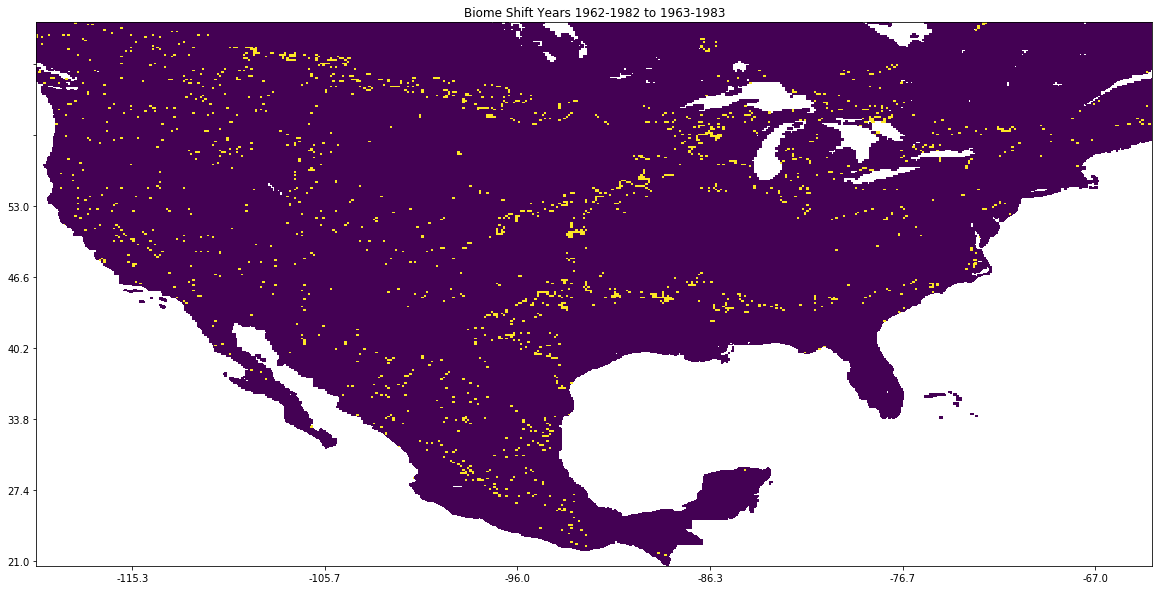

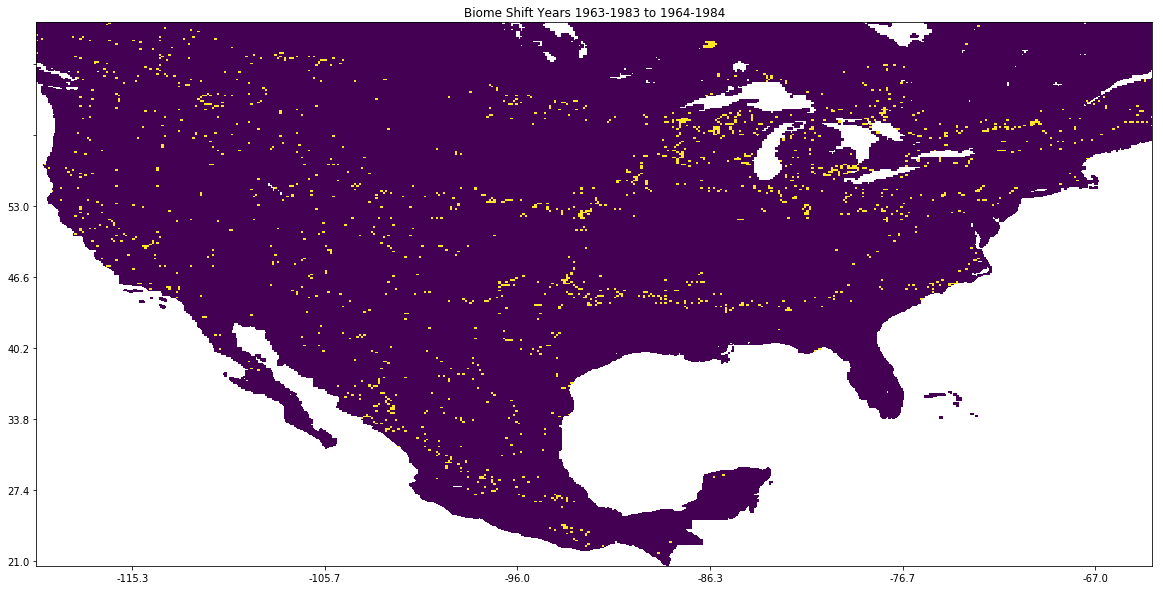

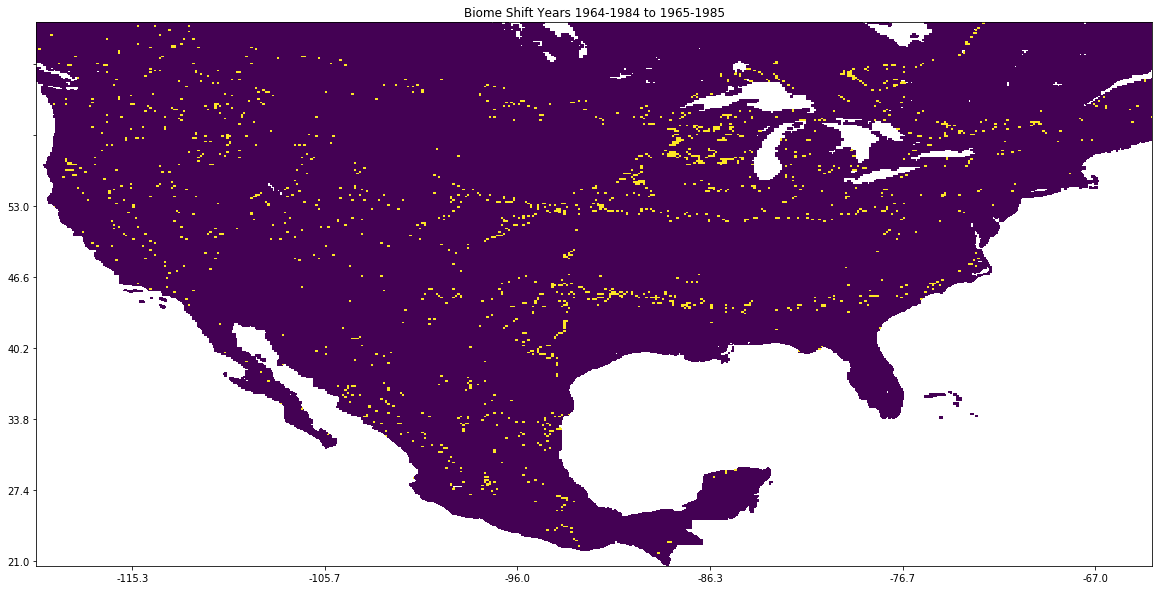

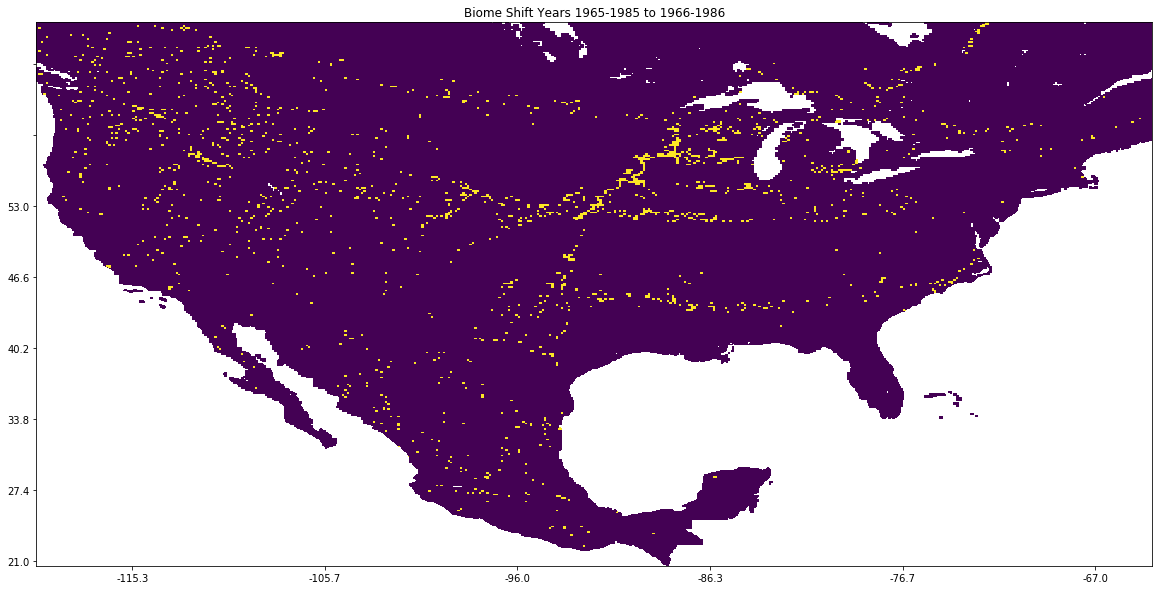

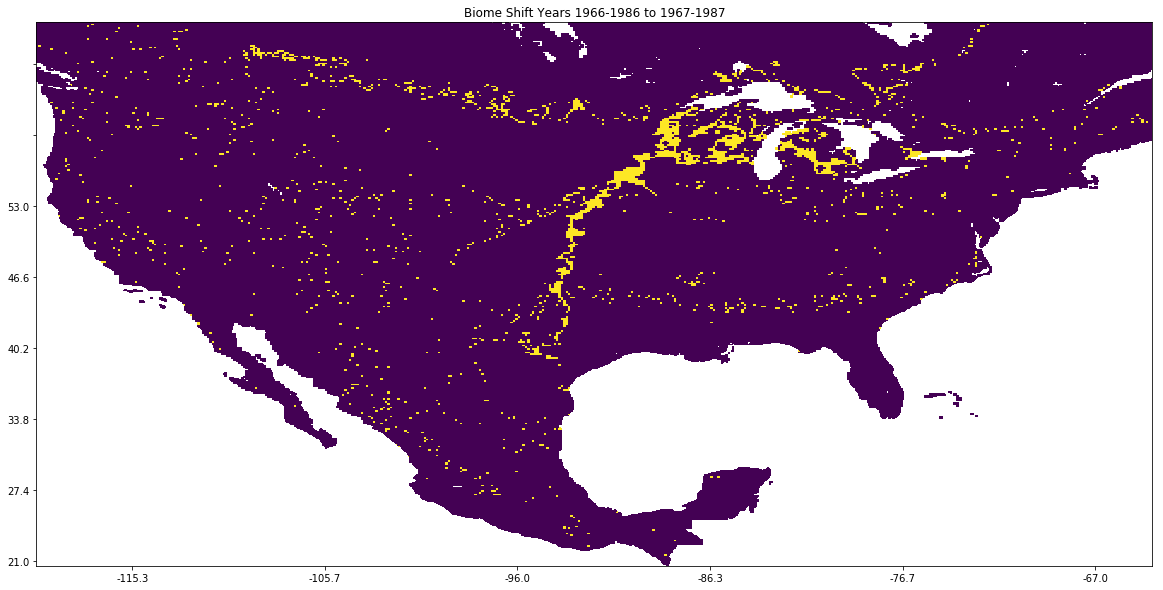

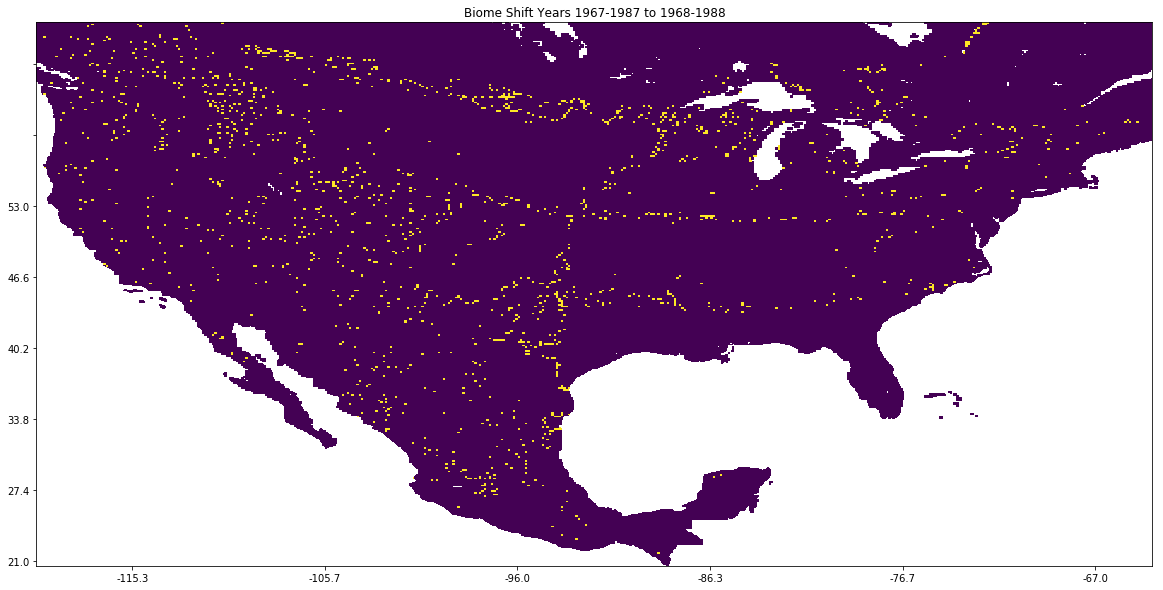

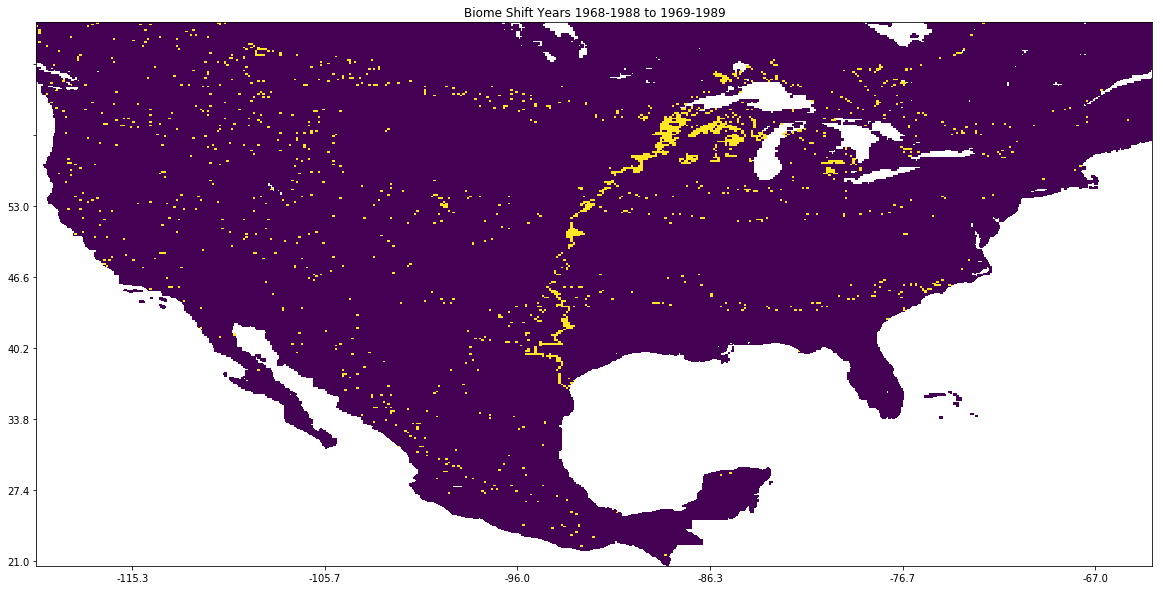

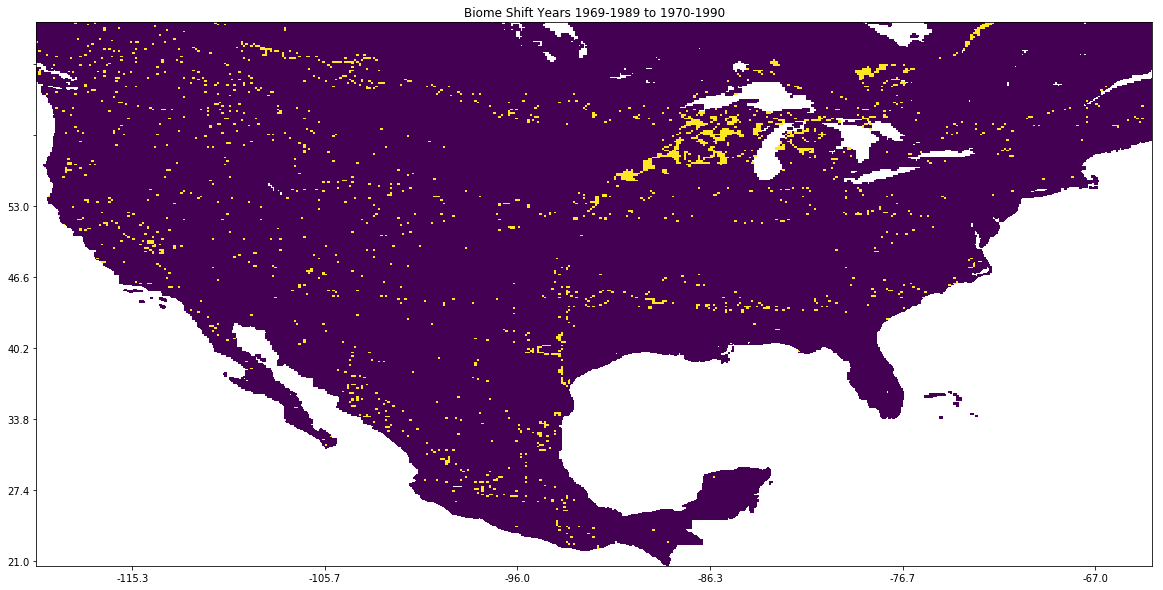

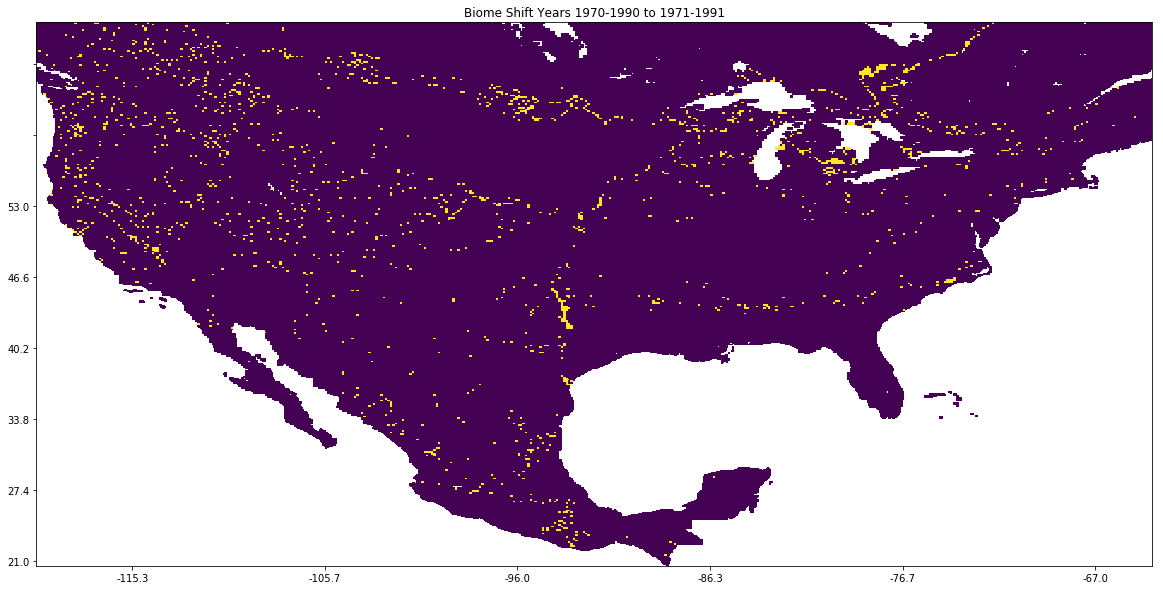

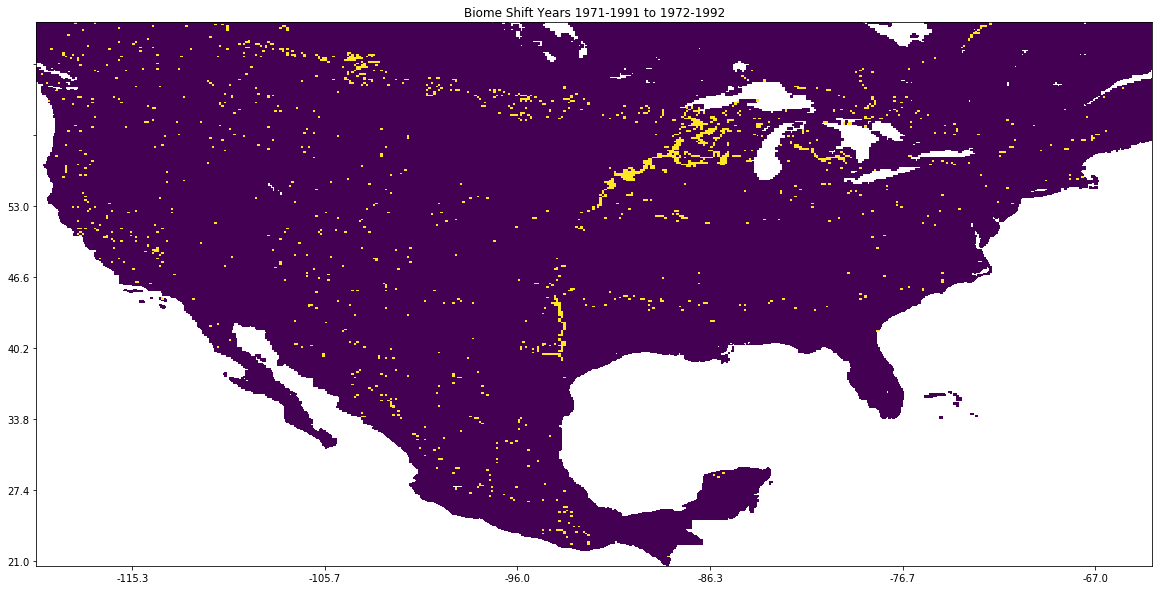

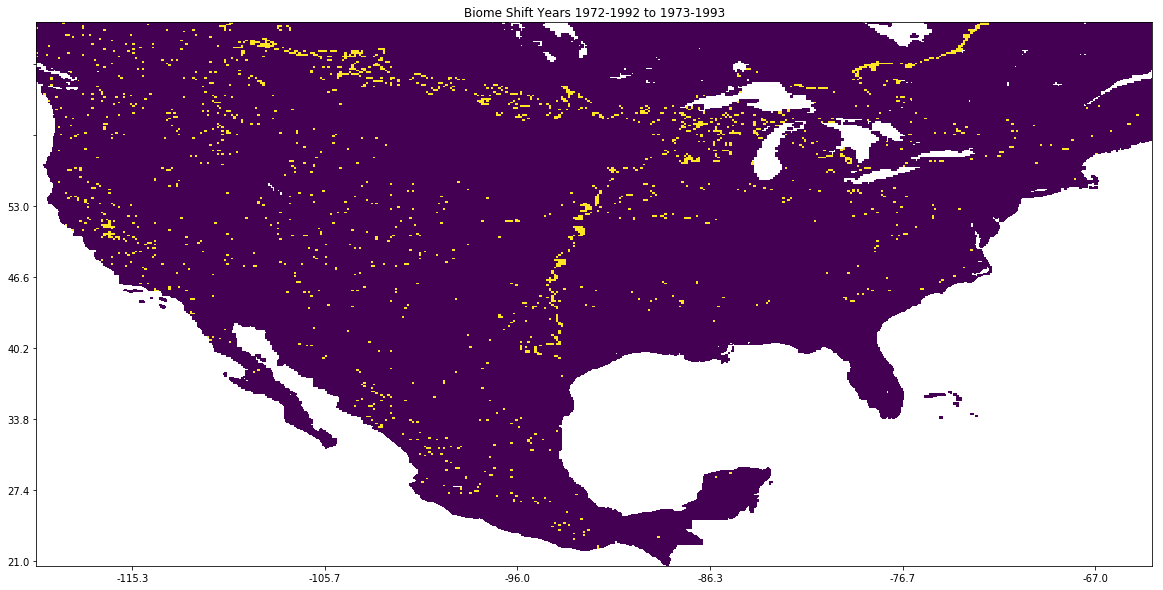

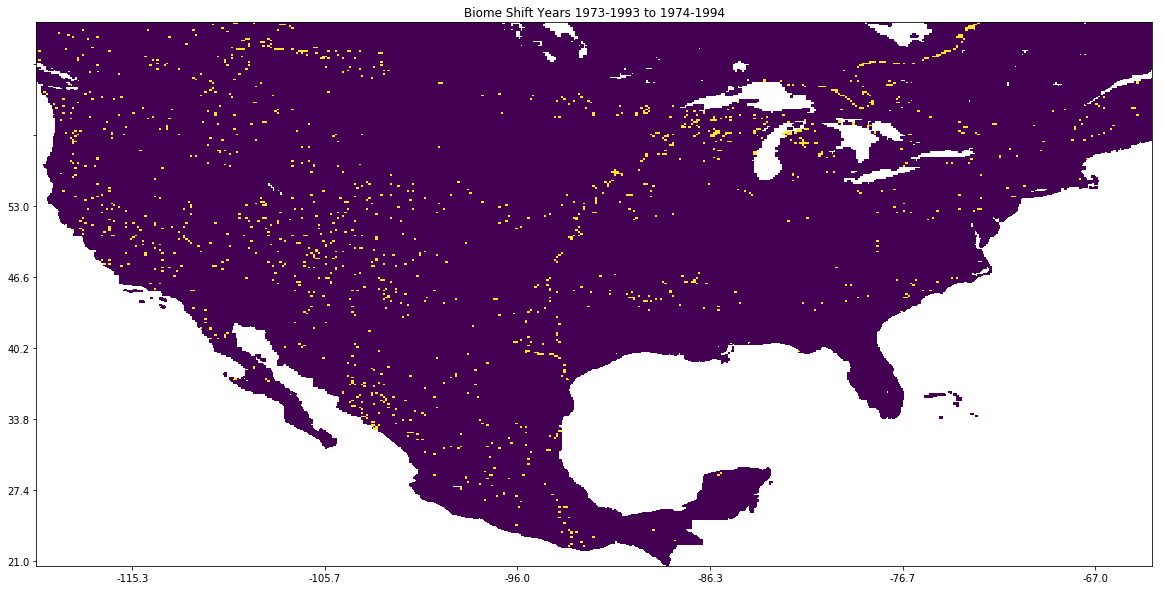

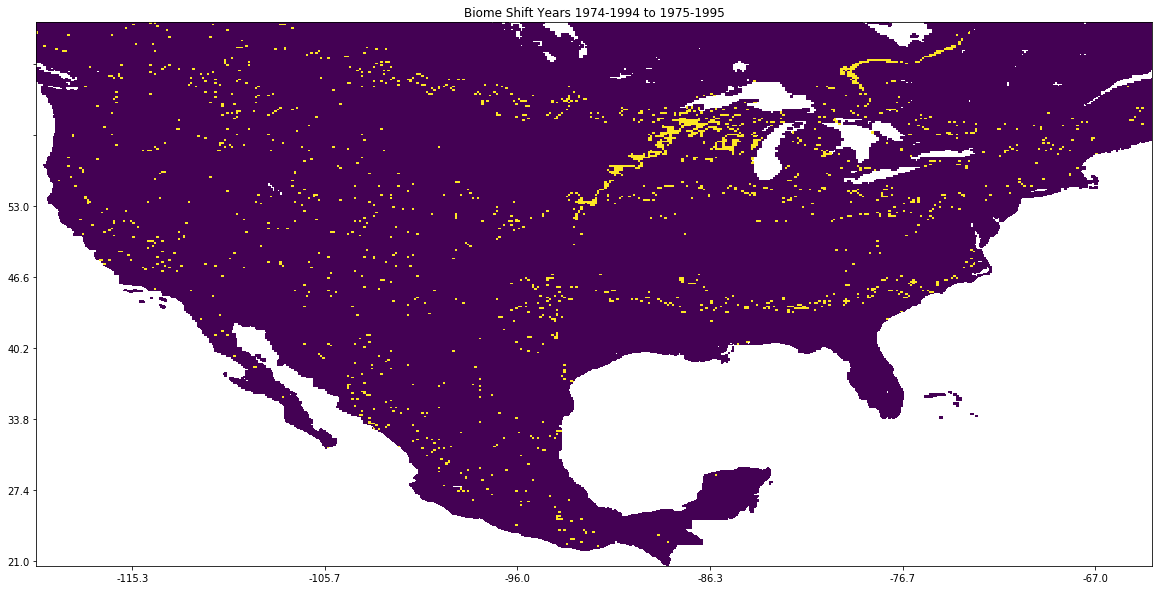

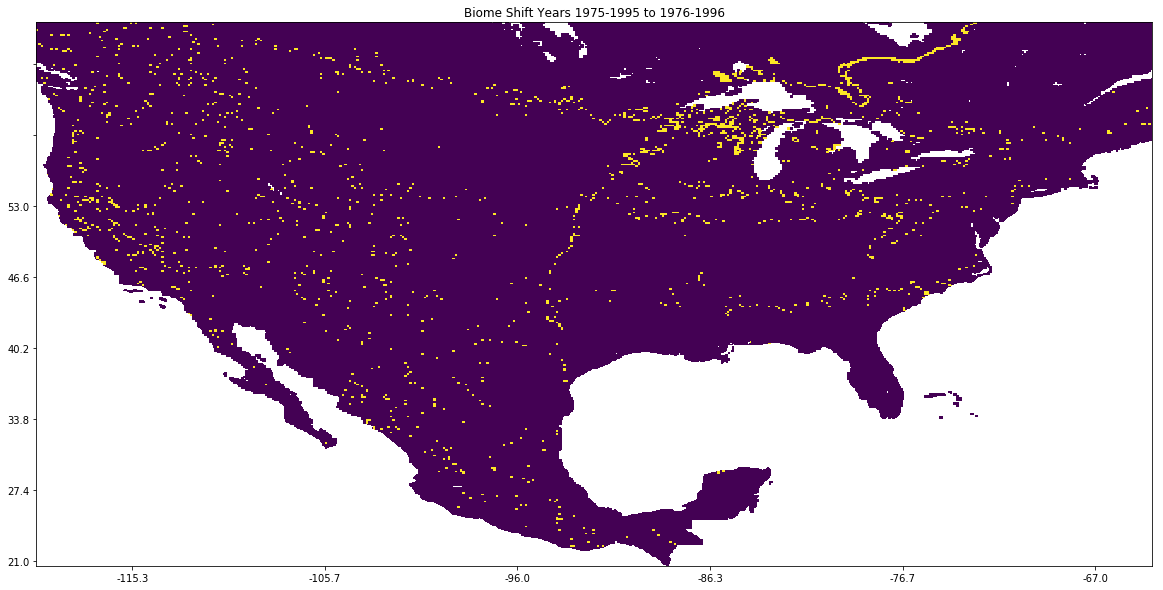

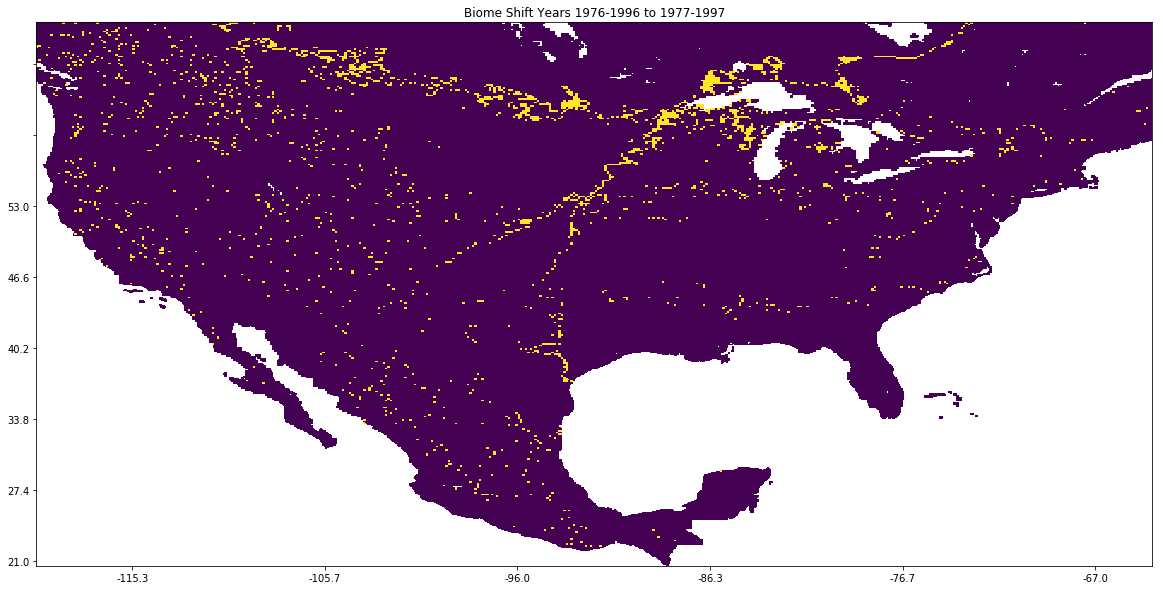

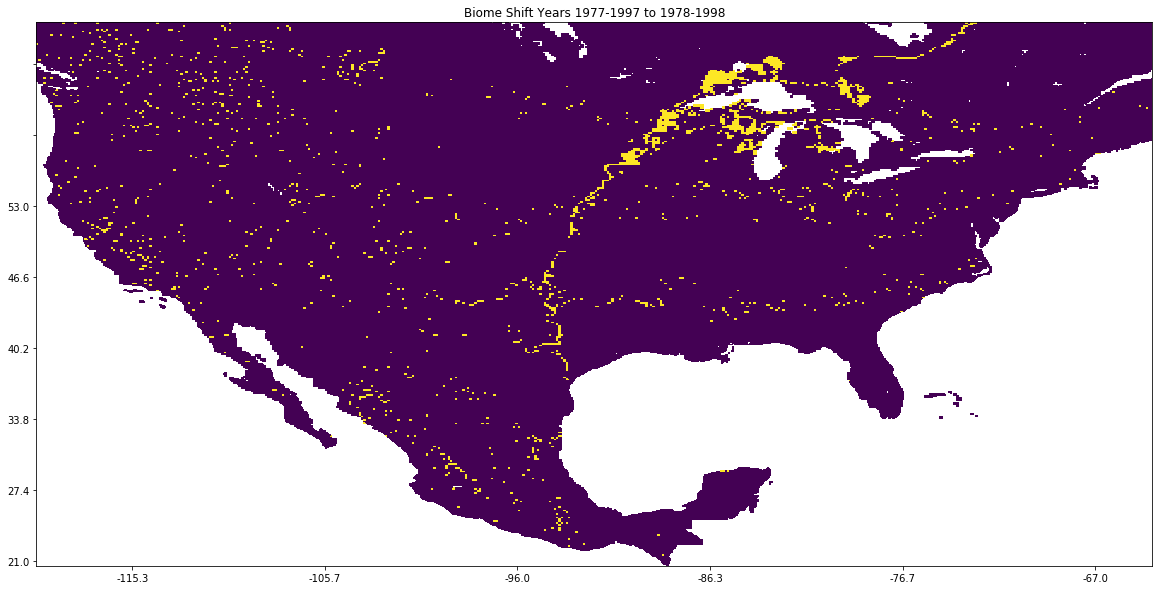

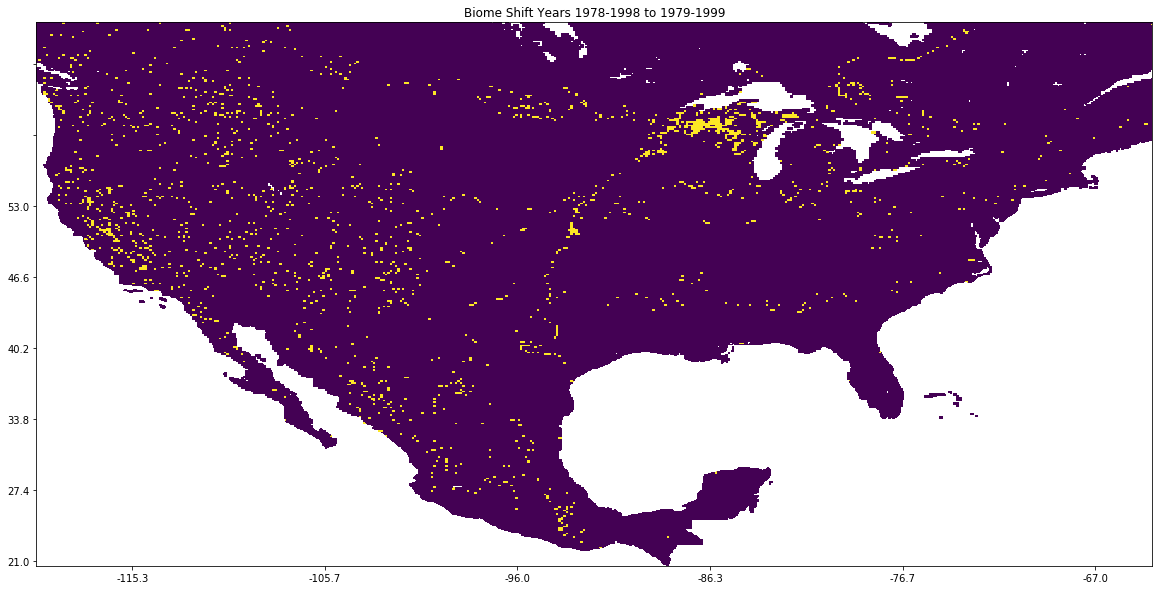

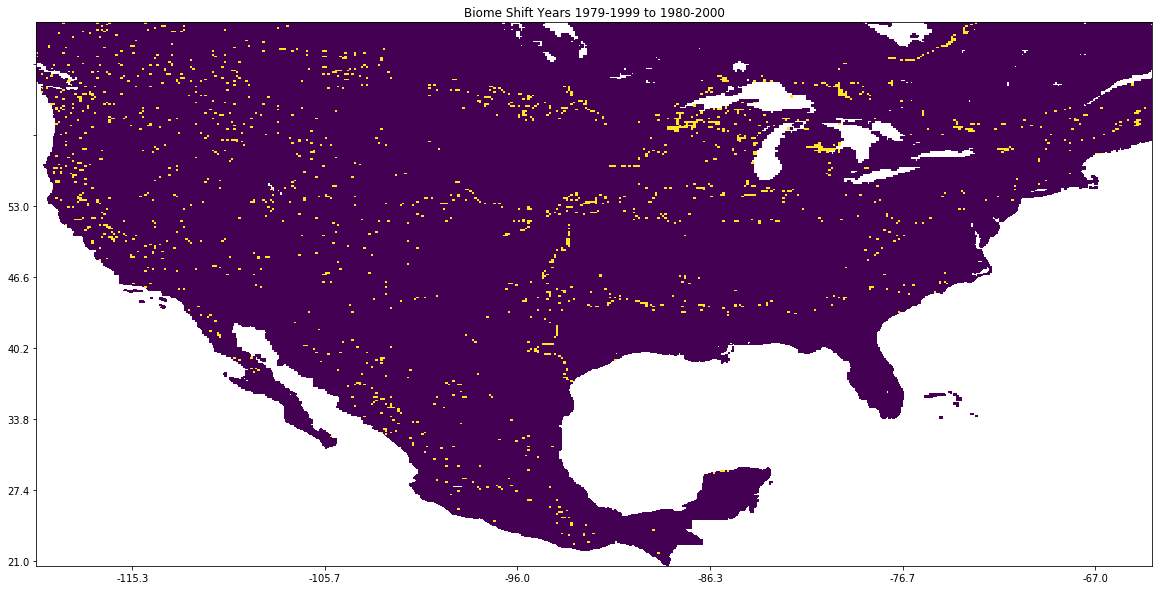

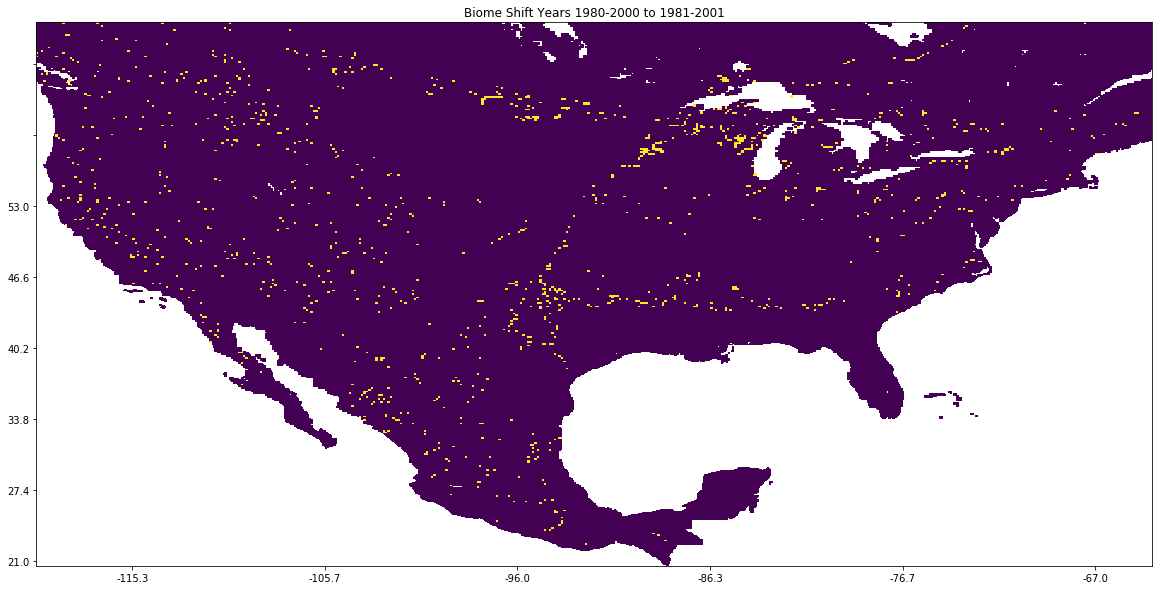

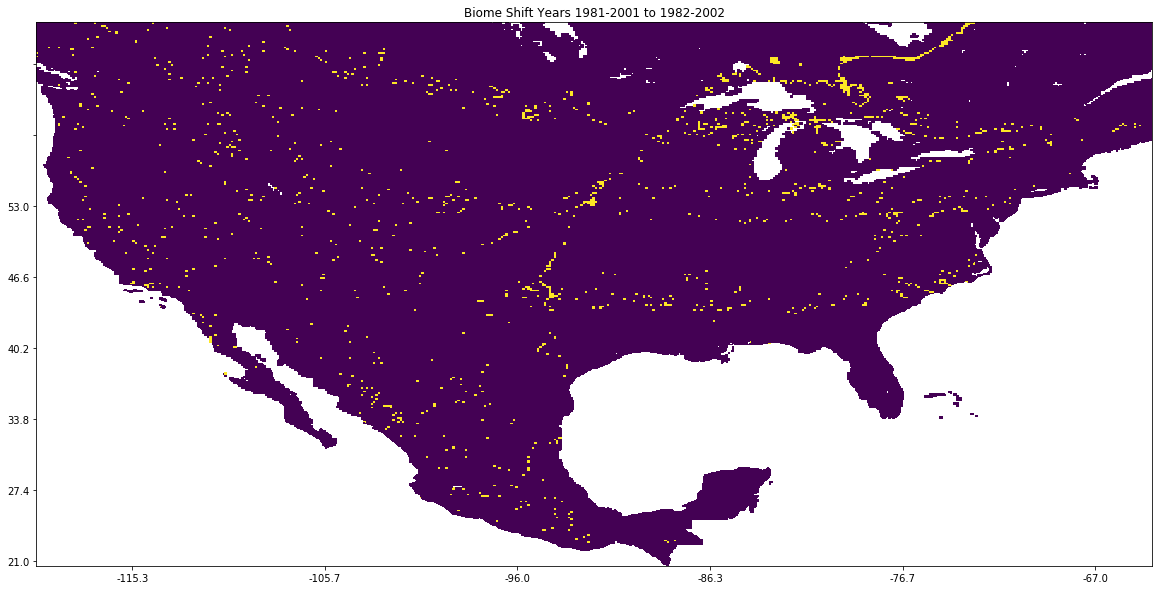

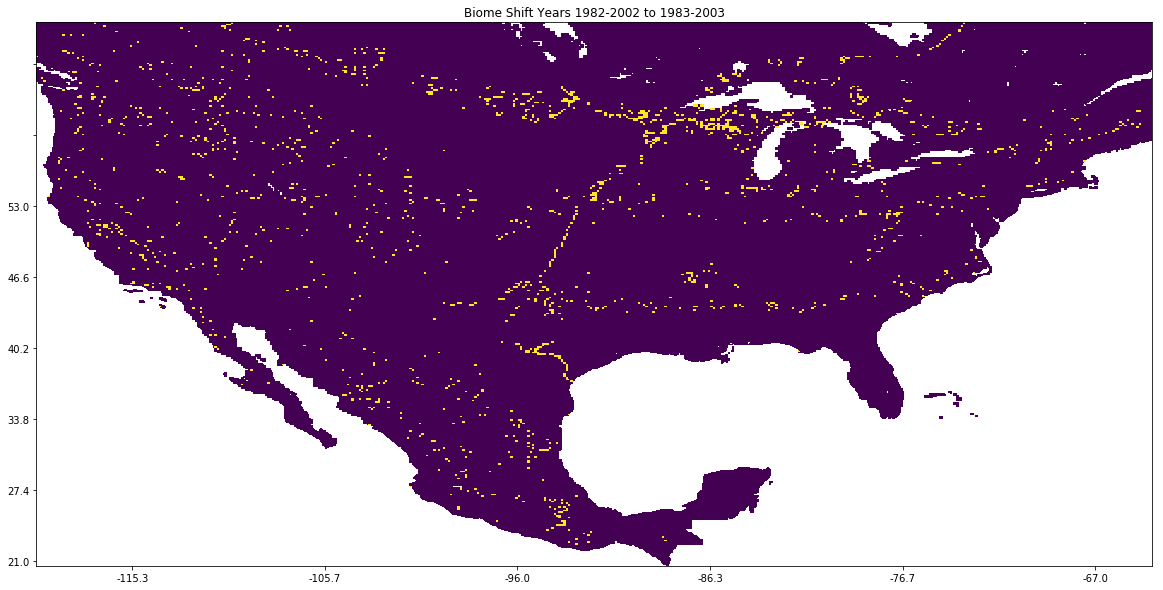

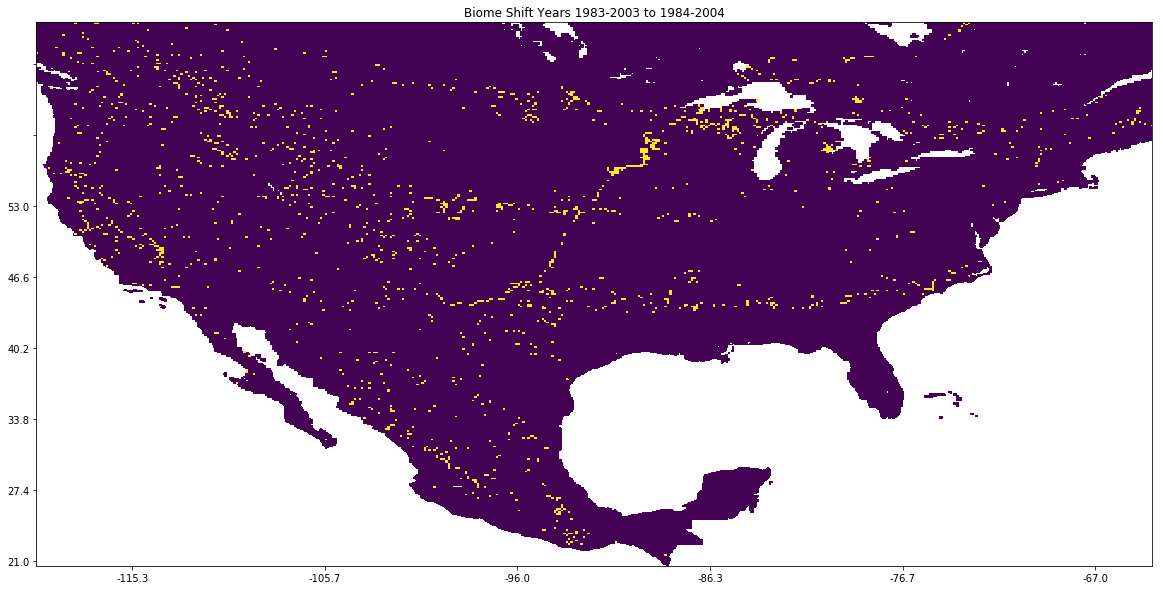

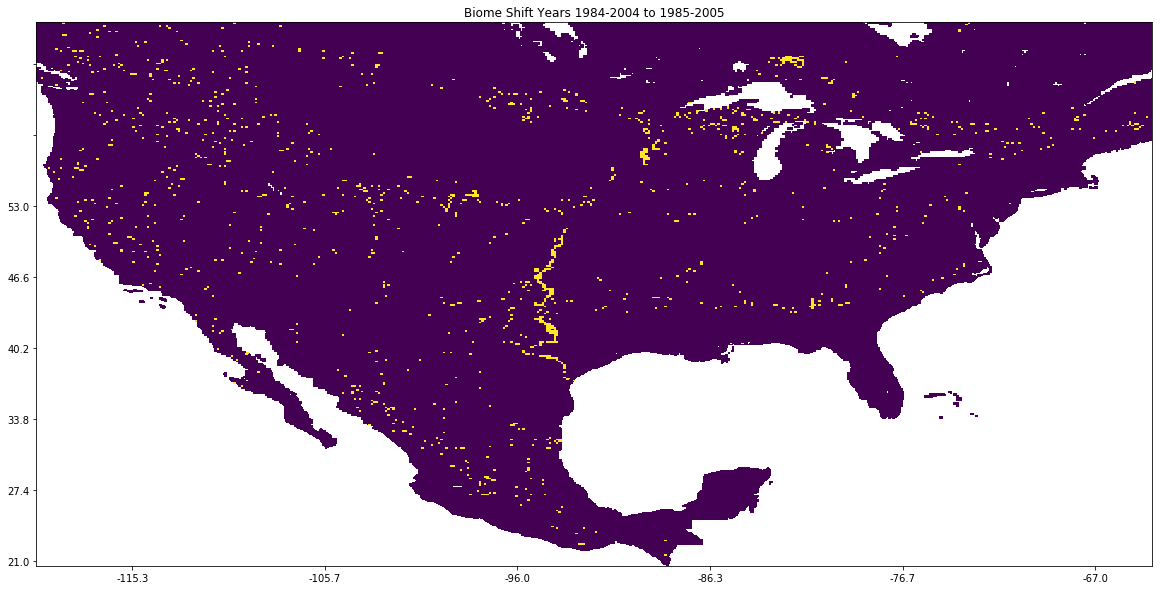

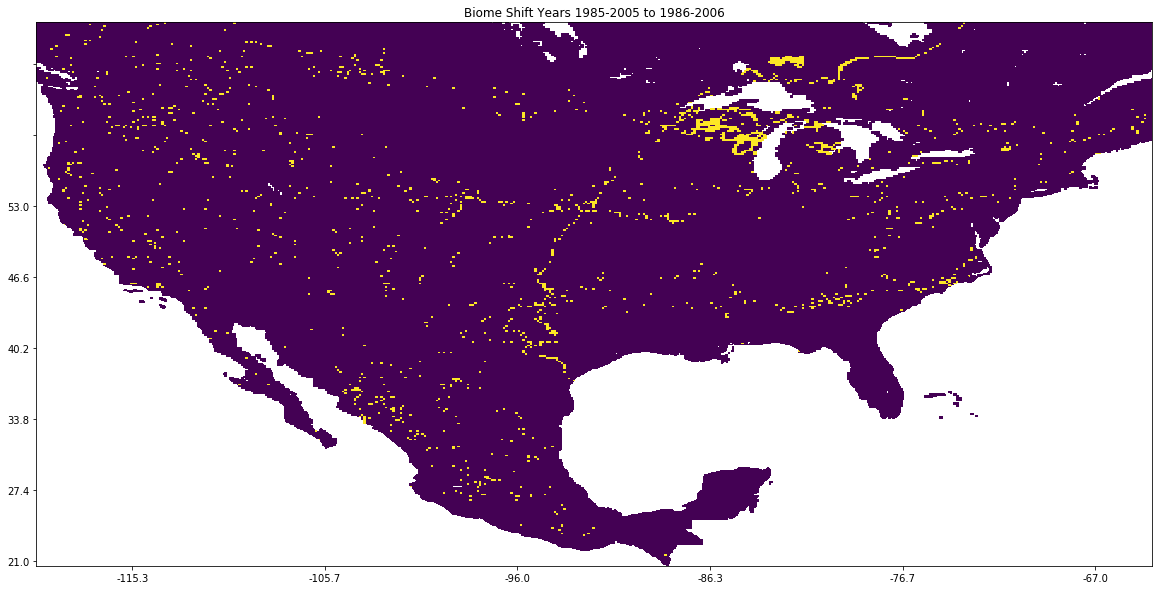

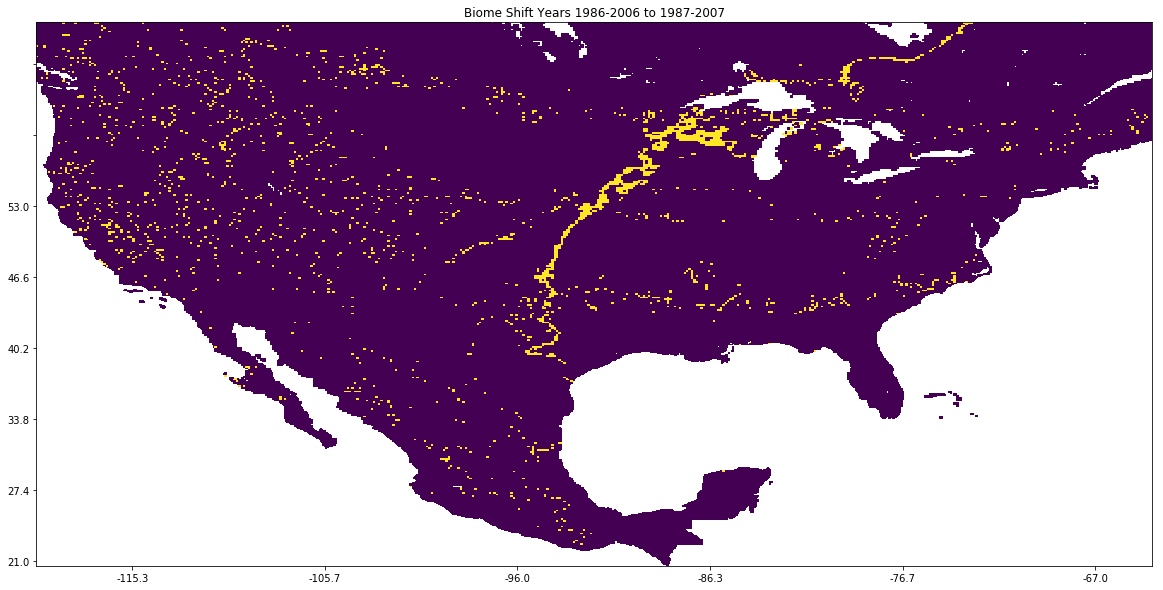

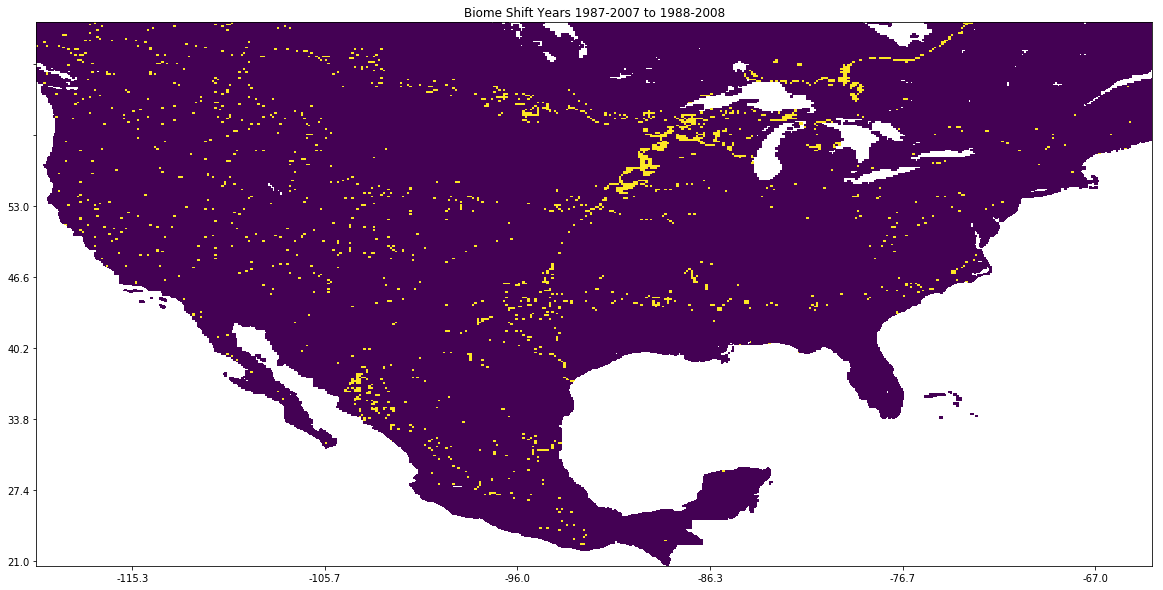

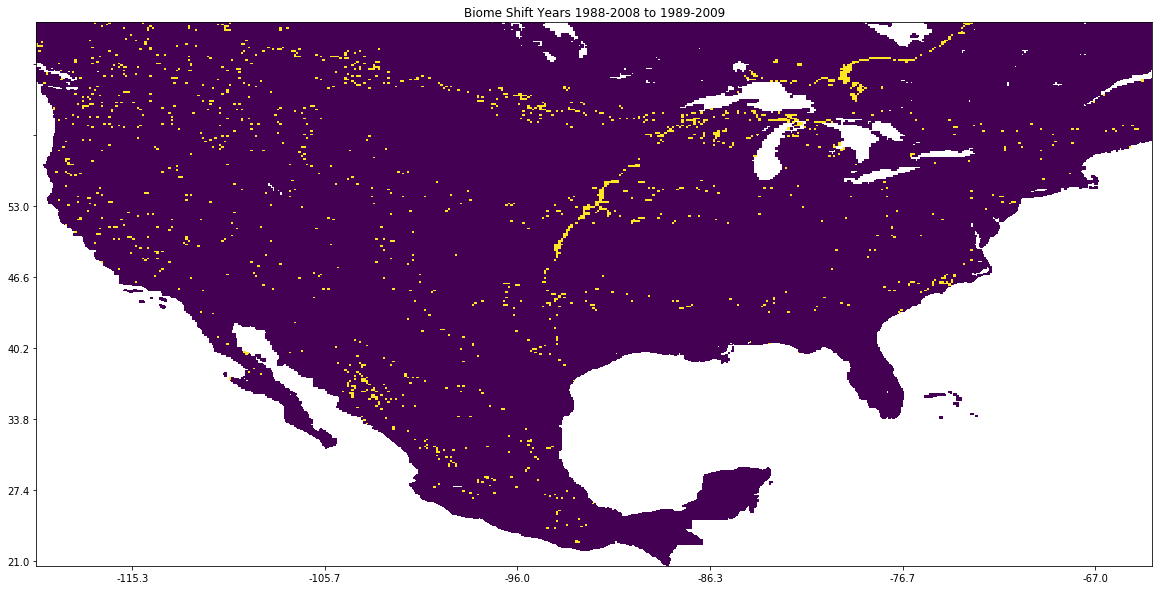

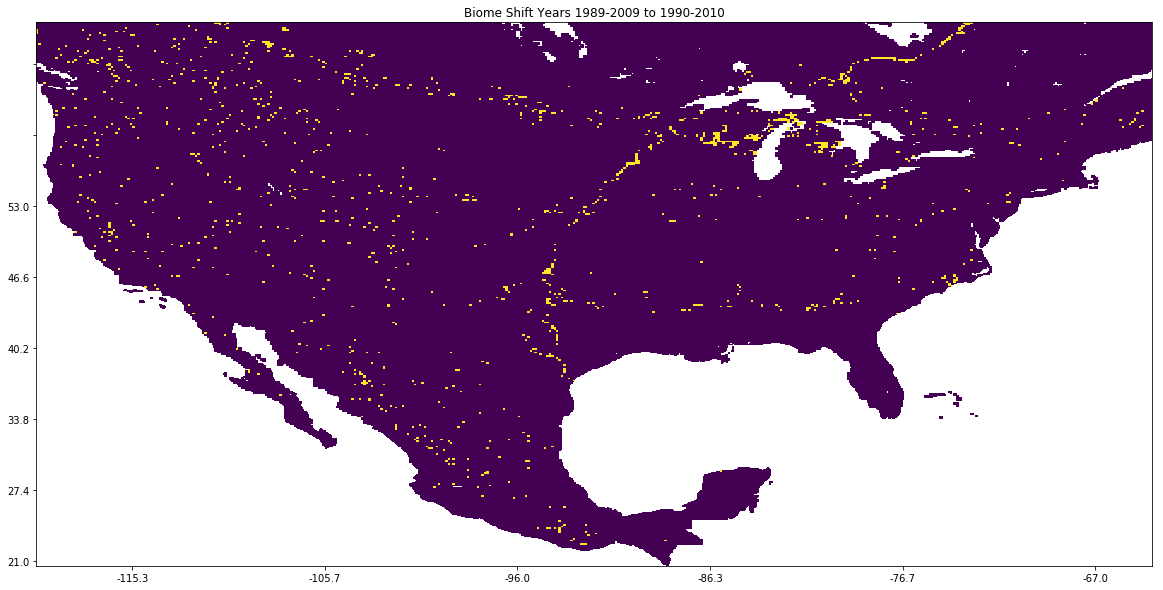

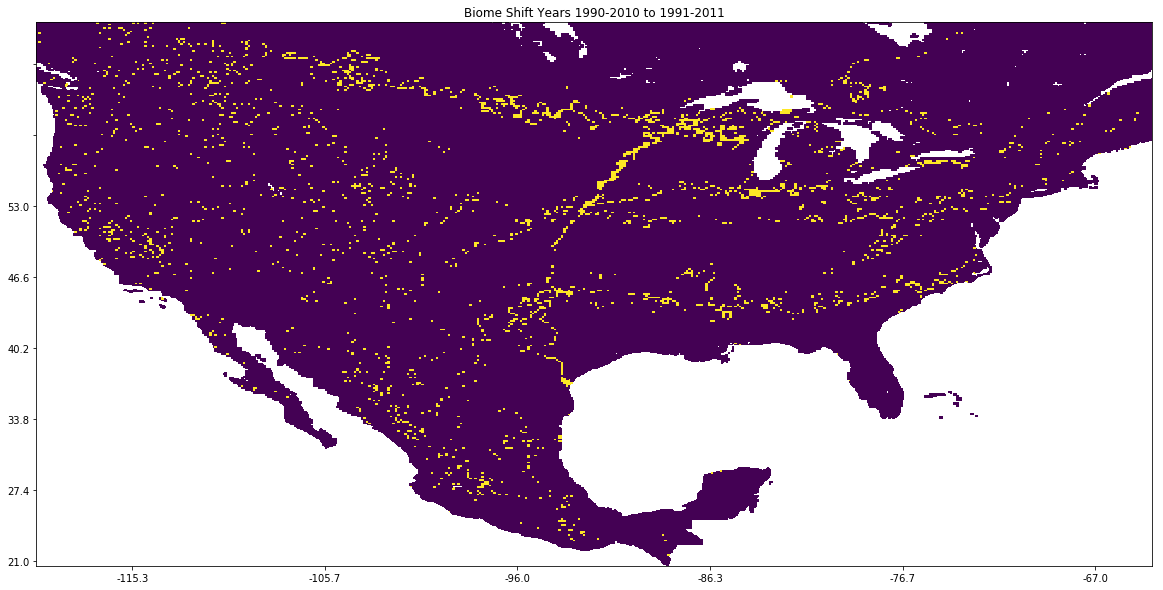

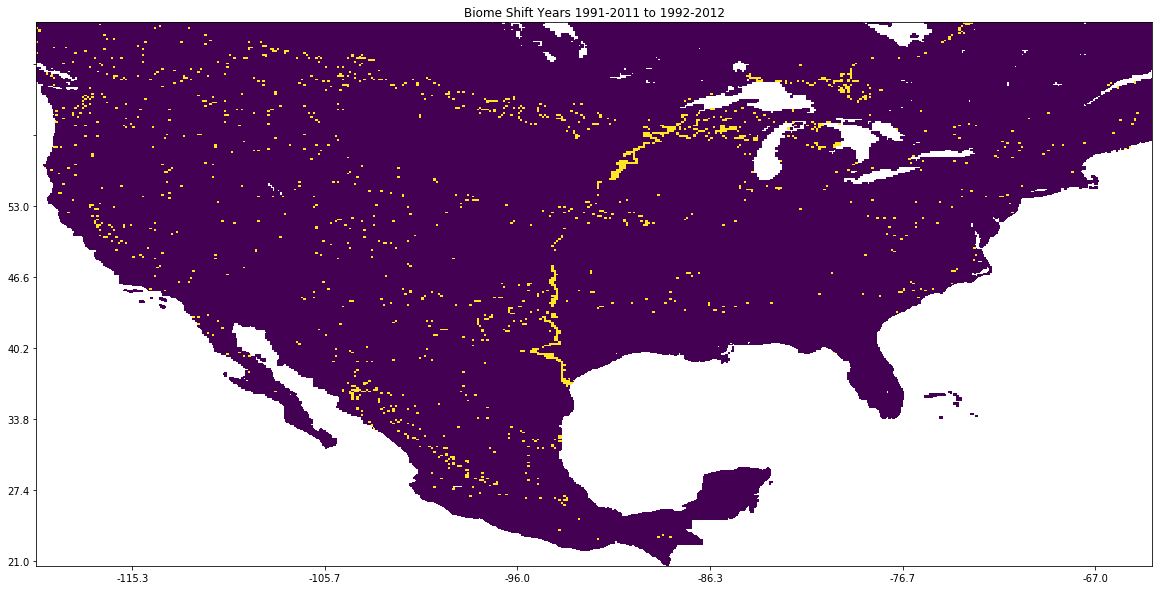

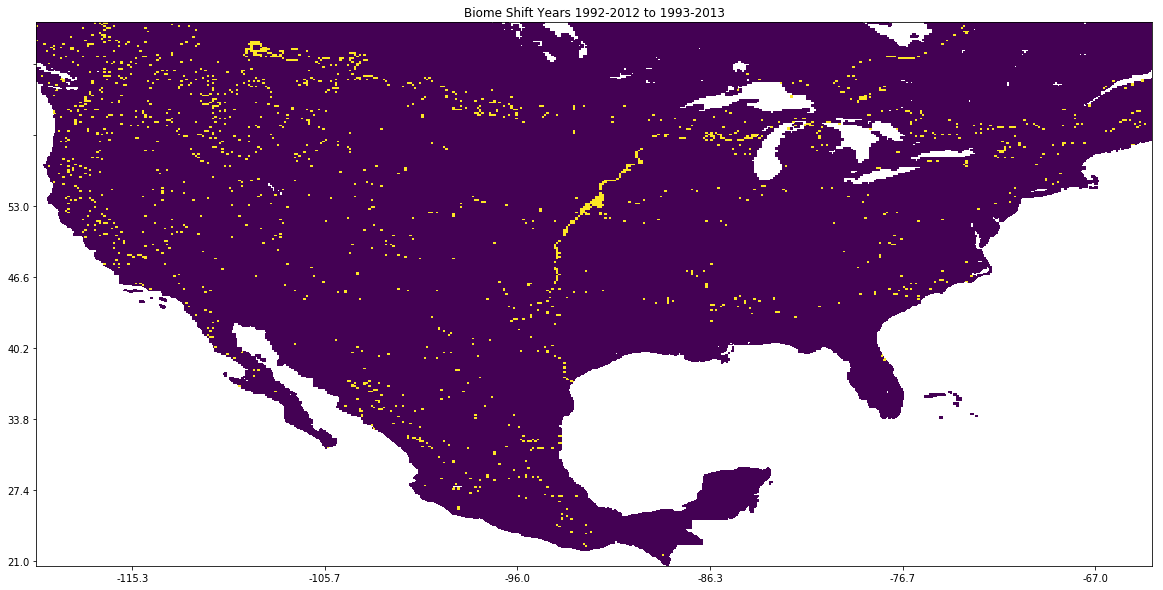

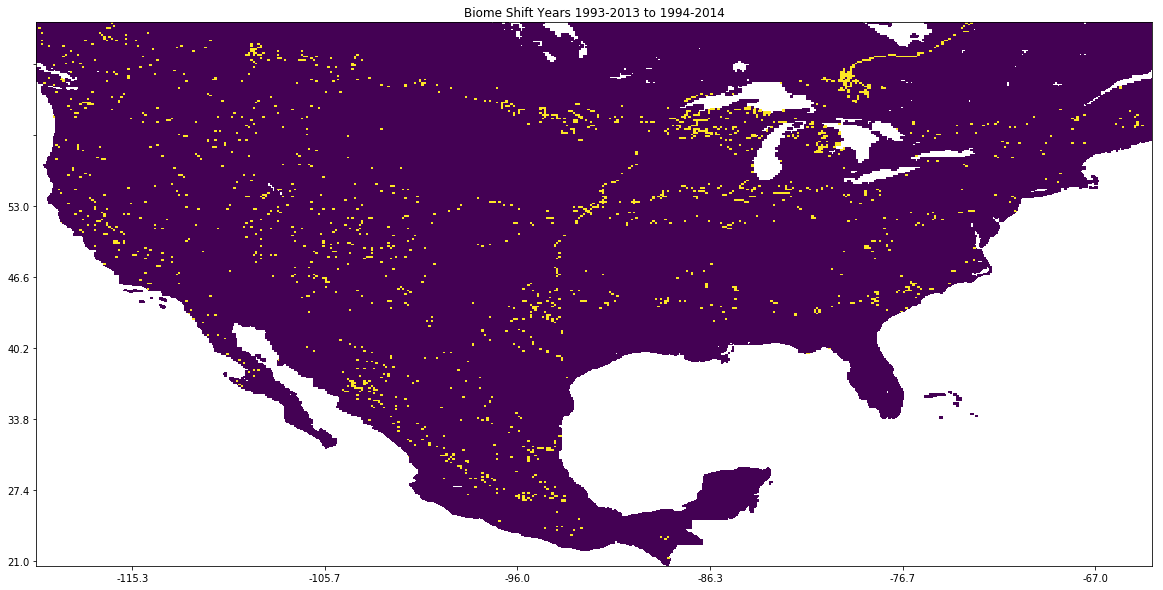

In [1215]:
#Plot the biome shift
for i in range(num_clusterings-1):
    
    f, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)
    
    ###
    #First plot is the regular combined classes:
    ###
    
    number_labels = 1
    cmap = color.ListedColormap(colormap)
            #Plot Prec
    p0 = ax.pcolormesh(ds.lon, ds.lat, biome_shift[i], vmin=0, vmax=number_labels)
        #p0 = plt.imshow(lexlabels, cmap="Set3", origin = [0,0])
    #plt.colorbar(p0, ax=ax, orientation='horizontal',
    #                 pad=0.07, fraction=0.05)
        #p.clim(0, number_labels)
    ax.set_title("Biome Shift Years " + str(1950+1*i) + "-" + str(1970 +1*i) + " to " + str(1951+1*i) + "-" + str(1971 +1*i))

    ax.set_xticklabels(lon_space, minor=False)
    ax.set_yticklabels(lat_space, minor=False)
    #####
    #The second plot is the re_ind versions
    #####
    

    
    plt.show()